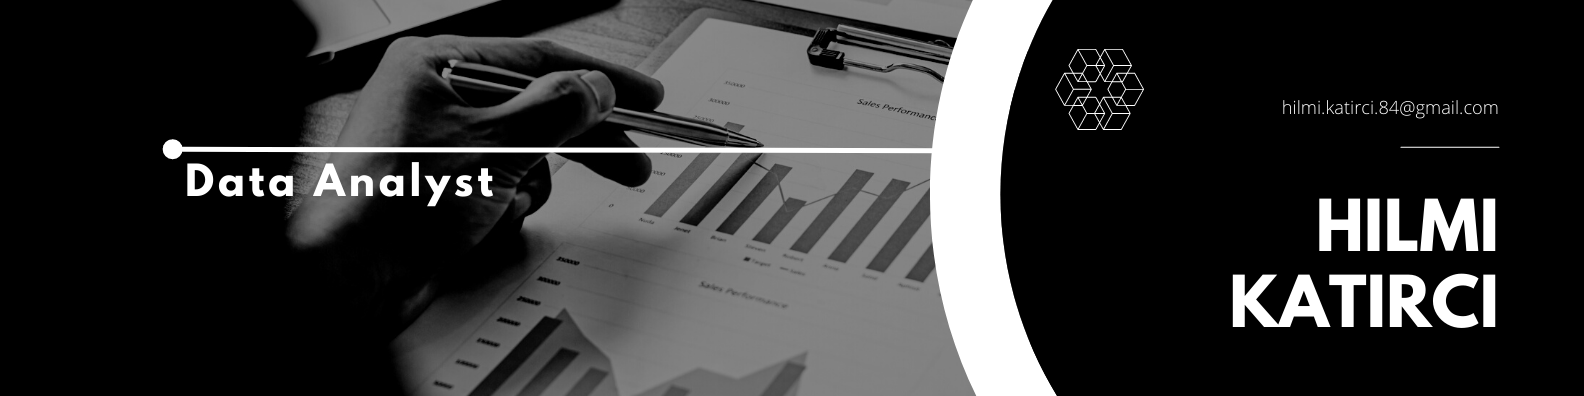

<a id="toc"></a>

## <p style="background-color:#9d4f8c; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">Content</p>

* [IMPORTING LIBRARIES NEEDED IN THIS NOTEBOOK](#0)
* [PART-03 (HANDLING WITH OUTLIERS)](#1)
* [THE EXAMINATION OF OUTLIERS IN THE COLUMNS](#2)
* [SOME SPECIFIC OUESTIONS ON ANALYSIS](#3)    
* [DUMMY OPERATION](#4)    
* [THE END OF DATA CLEANING (PART - 03)](#5)

## <p style="background-color:#9d4f8c; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">Importing Libraries Needed in This Notebook</p>

<a id="0"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>

Once you've installed NumPy, Pandas & other related you can import them as a library:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
from scipy.stats.mstats import winsorize

import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

%matplotlib inline
# %matplotlib notebook

plt.rcParams["figure.figsize"] = (10, 6)
# plt.rcParams['figure.dpi'] = 100

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 150

In [ ]:
# function for first looking to the columns

def first_looking(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()*100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print("--------------------------------")
    print(df[col].value_counts(dropna = False))

## functions to fill the missing values

In [ ]:
def fill_most(df, group_col, col_name):
    '''Fills the missing values with the most existing value (mode) in the relevant column according to single-stage grouping'''
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        mode = list(df[cond][col_name].mode())
        if mode != []:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[cond][col_name].mode()[0])
        else:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[col_name].mode()[0])
    print("Number of NaN : ", df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))

In [ ]:
def fill_prop(df, group_col, col_name):
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        df.loc[cond, col_name] = df.loc[cond, col_name].fillna(method="ffill").fillna(method="bfill")
    df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    print("Number of NaN : ", df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))

In [ ]:
def fill(df, group_col1, group_col2, col_name, method): # method can be either "mode" or "mean" or "median" or "ffill"
    
    '''Fills the missing values with "mode/mean/median/ffill/bfill method" according to double-stage grouping'''
    
    if method == "mode":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                mode1 = list(df[cond1][col_name].mode())
                mode2 = list(df[cond2][col_name].mode())
                if mode2 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond2][col_name].mode()[0])
                elif mode1 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond1][col_name].mode()[0])
                else:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[col_name].mode()[0])

    elif method == "mean":
        df[col_name].fillna(df.groupby([group_col1, group_col2])[col_name].transform("mean"), inplace = True)
        df[col_name].fillna(df.groupby(group_col1)[col_name].transform("mean"), inplace = True)
        df[col_name].fillna(df[col_name].mean(), inplace = True)
        
    elif method == "median":
        df[col_name].fillna(df.groupby([group_col1, group_col2])[col_name].transform("median"), inplace = True)
        df[col_name].fillna(df.groupby(group_col1)[col_name].transform("median"), inplace = True)
        df[col_name].fillna(df[col_name].median(), inplace = True)
        
    elif method == "ffill":           
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(method="ffill").fillna(method="bfill")
                
        for group1 in list(df[group_col1].unique()):
            cond1 = df[group_col1]==group1
            df.loc[cond1, col_name] = df.loc[cond1, col_name].fillna(method="ffill").fillna(method="bfill")            
           
        df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))

## <p style="background-color:#9d4f8c; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">PART - 03 (Handling with Outliers)</p>

<a id="1"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>

In [ ]:
df = pd.read_csv("filled_scout.csv")

In [ ]:
df.shape

(15919, 25)

In [ ]:
df.head(3).T

0  \
make_model                                                            Audi A1   
body_type                                                              Sedans   
price                                                                   15770   
km                                                                  56013.000   
Type                                                                     Used   
Fuel                                                                   Diesel   
Extras                       Alloy wheels, Catalytic Converter, Voice Control   
Gears                                                                   7.000   
age                                                                     3.000   
Previous_Owners                                                         2.000   
hp_kW                                                                  66.000   
Inspection_new                                                              1   
Paint_Type                                                           Metallic   
Upholstery_type                                                         Cloth   
Nr_of_Doors                                                             5.000   
Nr_of_Seats                                                             5.000   
Gearing_Type                                                        Automatic   
Displacement_cc                                                      1422.000   
Weight_kg                                                            1220.000   
Drive_chain                                                             front   
cons_comb                                                               3.800   
CO2_Emission                                                           99.000   
Comfort_Convenience_Package                                           Premium   
Entertainment_Media_Package                                              Plus   
Safety_Security_Package                                Safety Premium Package   

                                                                             1  \
make_model                                                             Audi A1   
body_type                                                               Sedans   
price                                                                    14500   
km                                                                   80000.000   
Type                                                                      Used   
Fuel                                                                   Benzine   
Extras                       Alloy wheels, Sport seats, Sport suspension, V...   
Gears                                                                    7.000   
age                                                                      2.000   
Previous_Owners                                                          1.000   
hp_kW                                                                  141.000   
Inspection_new                                                               0   
Paint_Type                                                            Metallic   
Upholstery_type                                                          Cloth   
Nr_of_Doors                                                              3.000   
Nr_of_Seats                                                              4.000   
Gearing_Type                                                         Automatic   
Displacement_cc                                                       1798.000   
Weight_kg                                                             1255.000   
Drive_chain                                                              front   
cons_comb                                                                5.600   
CO2_Emission                                                           129.000   
Comfort_Convenience_Package                                           Standard   
E

## <p style="background-color:#9d4f8c; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">The Examination of OUTLIERS in the Columns</p>

<a id="2"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>

## km

In [ ]:
first_looking("km")

column name    :  km
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  6692
--------------------------------
10.000       1045
1647.363      985
1.000         367
5.000         170
50.000        148
             ... 
67469.000       1
43197.000       1
10027.000       1
35882.000       1
57.000          1
Name: km, Length: 6692, dtype: int64


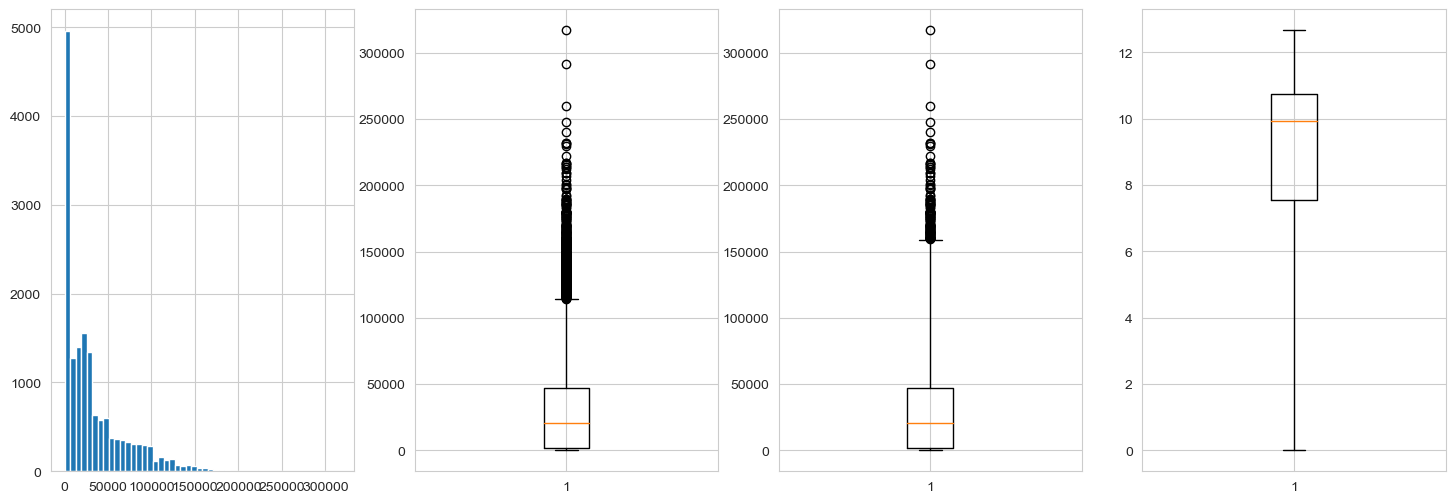

In [ ]:
plt.figure(figsize=(18, 6))

plt.subplot(141)
plt.hist(df.km, bins=50)

plt.subplot(142)
plt.boxplot(df.km)

plt.subplot(143)
plt.boxplot(df.km, whis=2.5)

plt.subplot(144)
plt.boxplot(np.log(df.km), whis=2.5)

plt.show()

In [ ]:
#df["km_logged"] = np.log(df.km)

**``km``** **is a variable with a wide range of values. We CANNOT consider the extreme values above as  genuine outliers. So let's keep these extreme values as they are.**

## Gears

In [ ]:
first_looking("Gears")

column name    :  Gears
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  10
--------------------------------
6.000     8615
5.000     4255
7.000     2810
8.000      225
9.000        6
1.000        2
3.000        2
4.000        2
2.000        1
50.000       1
Name: Gears, dtype: int64


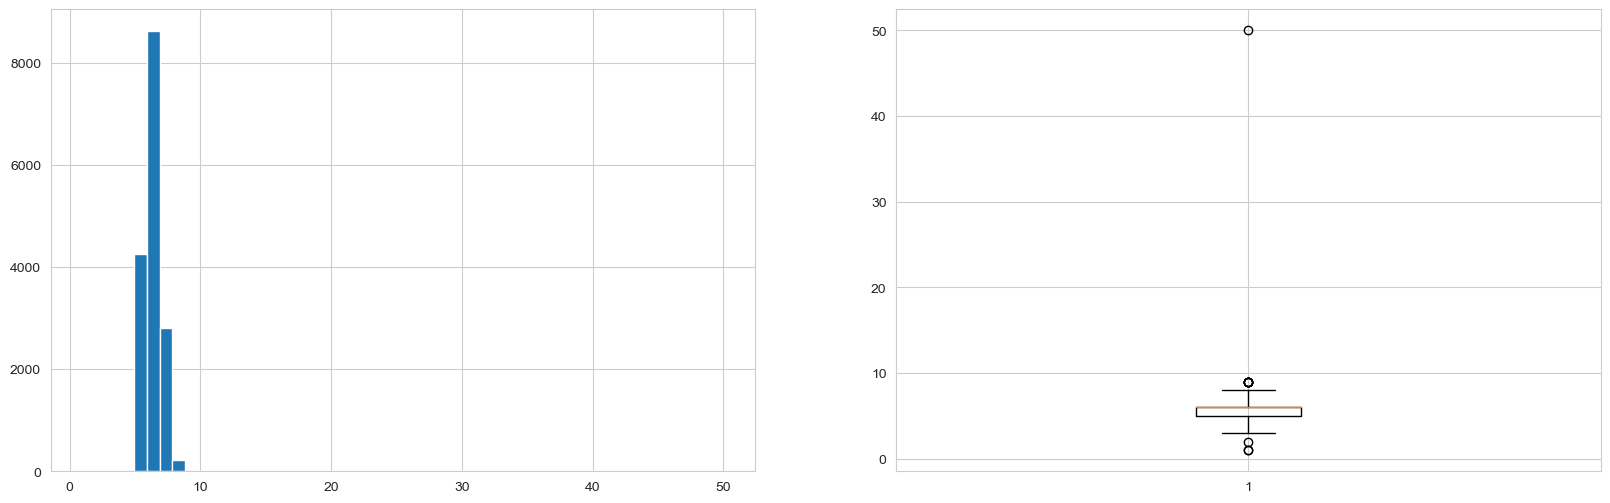

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.Gears, bins=50)

plt.subplot(122)
plt.boxplot(df.Gears, whis=2.5)

plt.show()

In [ ]:
df.Gears.describe()

count   15919.000
mean        5.940
std         0.792
min         1.000
25%         5.000
50%         6.000
75%         6.000
max        50.000
Name: Gears, dtype: float64

In [ ]:
df.sort_values(by=["Gears"], ascending=False)["Gears"].head(10)

14495   50.000
15827    9.000
15824    9.000
15814    9.000
15869    9.000
15812    9.000
15876    9.000
12463    8.000
12470    8.000
12469    8.000
Name: Gears, dtype: float64

In [ ]:
df.sort_values(by=["Gears"], ascending=True)["Gears"].head(10)

8921    1.000
14375   1.000
9812    2.000
15817   3.000
15845   3.000
15823   4.000
15822   4.000
10427   5.000
10428   5.000
10429   5.000
Name: Gears, dtype: float64

In [ ]:
# Let's check the observations having extreme Gear value.

df[(df.Gears < 5) | (df.Gears > 8)][["make_model", "body_type", "Gearing_Type", "Gears"]]

make_model body_type    Gearing_Type  Gears
8921       Opel Corsa   Compact  Semi-automatic  1.000
9812       Opel Corsa    Sedans          Manual  2.000
14375    Renault Clio   Compact       Automatic  1.000
14495    Renault Clio    Sedans          Manual 50.000
15812  Renault Espace       Van       Automatic  9.000
15814  Renault Espace       Van       Automatic  9.000
15817  Renault Espace       Van       Automatic  3.000
15822  Renault Espace       Van       Automatic  4.000
15823  Renault Espace       Van       Automatic  4.000
15824  Renault Espace       Van       Automatic  9.000
15827  Renault Espace       Van       Automatic  9.000
15845  Renault Espace       Van       Automatic  3.000
15869  Renault Espace       Van       Automatic  9.000
15876  Renault Espace       Van       Automatic  9.000

In [ ]:
# Let's check the observations belongs to "Renault Espace" model to see distribution of Gear values. 

df[(df.make_model == "Renault Espace")][["make_model", "body_type", "Gearing_Type", "Gears"]]

make_model      body_type    Gearing_Type  Gears
14928  Renault Espace            Van       Automatic  6.000
14929  Renault Espace  Station wagon       Automatic  6.000
14930  Renault Espace    Transporter       Automatic  6.000
14931  Renault Espace            Van       Automatic  6.000
14932  Renault Espace            Van       Automatic  6.000
14933  Renault Espace    Transporter       Automatic  6.000
14934  Renault Espace            Van       Automatic  6.000
14935  Renault Espace            Van       Automatic  6.000
14936  Renault Espace       Off-Road       Automatic  6.000
14937  Renault Espace            Van       Automatic  6.000
14938  Renault Espace            Van       Automatic  6.000
14939  Renault Espace    Transporter       Automatic  6.000
14940  Renault Espace            Van       Automatic  6.000
14941  Renault Espace            Van       Automatic  6.000
14942  Renault Espace            Van       Automatic  6.000
14943  Renault Espace            Van       Automatic  6.000
14944  Renault Espace            Van       Automatic  6.000
14945  Renault Espace            Van       Automatic  6.000
14946  Renault Espace    Transporter       Automatic  6.000
14947  Renault Espace            Van       Automatic  6.000
14948  Renault Espace            Van       Automatic  6.000
14949  Renault Espace            Van       Automatic  6.000
14950  Renault Espace    Transporter       Automatic  6.000
14951  Renault Espace            Van       Automatic  6.000
14952  Renault Espace  Station wagon       Automatic  6.000
14953  Renault Espace         Sedans       Automatic  6.000
14954  Renault Espace            Van       Automatic  6.000
14955  Renault Espace         Sedans       Automatic  6.000
14956  Renault Espace            Van       Automatic  6.000
14957  Renault Espace            Van       Automatic  6.000
14958  Renault Espace            Van       Automatic  6.000
14959  Renault Espace            Van       Automatic  6.000
14960  Renault Espace            Van       Automatic  6.000
14961  Renault Espace            Van       Automatic  7.000
14962  Renault Espace            Van       Automatic  6.000
14963  Renault Espace            Van       Automatic  6.000
14964  Renault Espace  Station wagon       Automatic  6.000
14965  Renault Espace  Station wagon       Automatic  7.000
14966  Renault Espace            Van       Automatic  6.000
14967  Renault Espace            Van       Automatic  6.000
14968  Renault Espace         Sedans       Automatic  7.000
14969  Renault Espace            Van       Automatic  6.000
14970  Renault Espace            Van       Automatic  6.000
14971  Renault Espace            Van       Automatic  6.000
14972  Renault Espace  Station wagon       Automatic  6.000
14973  Renault Espace            Van       Automatic  6.000
14974  Renault Espace  Station wagon       Automatic  7.000
14975  Renault Espace            Van       Automatic  6.000
14976  Renault Espace            Van       Automatic  6.000
14977  Renault Espace  Station wagon       Automatic  7.000
14978  Renault Espace  Station wagon       Automatic  6.000
14979  Renault Espace            Van       Automatic  6.000
14980  Renault Espace            Van       Automatic  6.000
14981  Renault Espace            Van       Automatic  6.000
14982  Renault Espace            Van       Automatic  6.000
14983  Renault Espace            Van       Automatic  6.000
14984  Renault Espace            Van       Automatic  7.000
14985  Renault Espace         Sedans       Automatic  6.000
14986  Renault Espace            Van       Automatic  6.000
14987  Renault Espace    Transporter       Automatic  6.000
14988  Renault Espace            Van       Automatic  6.000
14989  Renault Espace            Van       Automatic  6.000
14990  Renault Espace            Van       Automatic  7.000
14991  Renault Espace  Station wagon       Automatic  6.000
14992  Renault Espace            Van       Automatic  6.000
14993  Renault Espace            Van       Automati

**Is it possible that there have been modern cars with manual/automatic transmissions with 1, 2, 3, 4, 9, 50 gears?**

Most modern cars with manual transmissions have 5 or 6 forward gears. Most modern cars with automatic transmissions have 5–8 forward gears. A few have as many as 10 [Source](https://www.quora.com/What-are-maximum-number-of-transmission-gears).
Contemporary manual transmissions for cars typically use five or six forward gears ratios and one reverse gear, however, transmissions with between two and seven gears have been produced at times [Source](https://en.wikipedia.org/wiki/Manual_transmission).

In [ ]:
df["Gears"].replace([1, 2, 3, 4, 9, 50], np.nan, inplace=True)

In [ ]:
df.Gears.isnull().sum()

14

In [ ]:
fill(df, "make_model", "body_type", "Gears", "mode")

Number of NaN :  0
------------------
6.000    8625
5.000    4259
7.000    2810
8.000     225
Name: Gears, dtype: int64


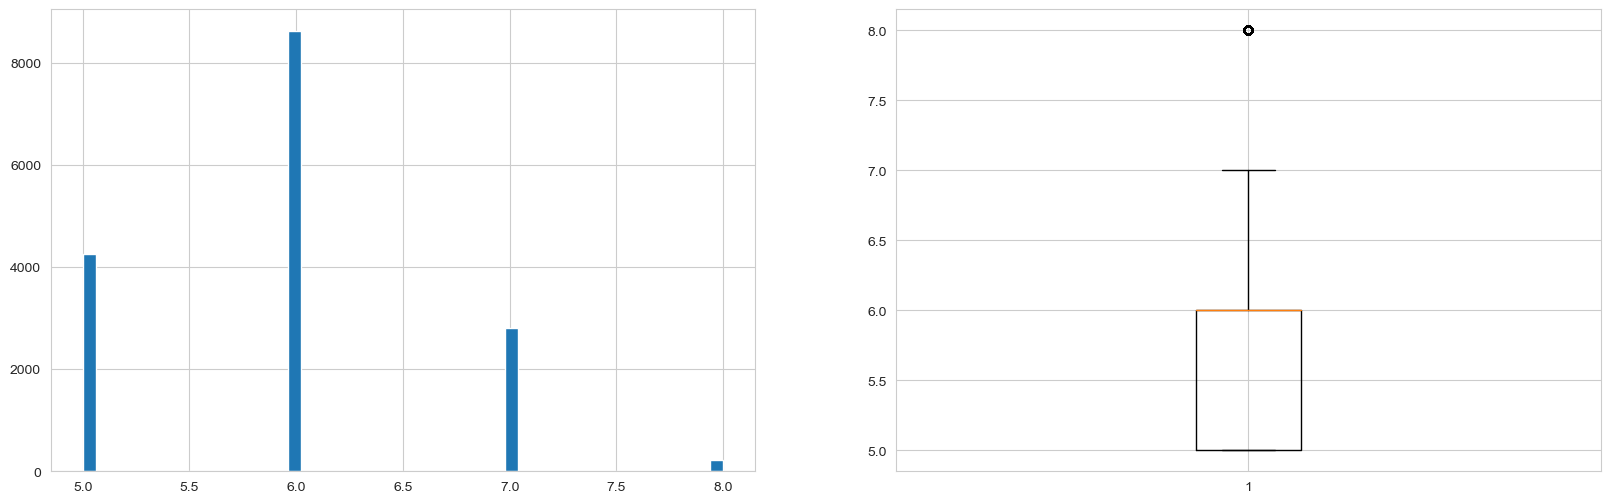

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.Gears, bins=50)

plt.subplot(122)
plt.boxplot(df.Gears, whis=1.5)

plt.show()

## displacement_cc

In [ ]:
first_looking("Displacement_cc")

column name    :  Displacement_cc
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  77
--------------------------------
1598.000     5044
999.000      2467
1398.000     1387
1399.000      768
1229.000      678
1956.000      670
1461.000      667
1490.000      559
1422.000      467
1197.000      372
898.000       351
1395.000      320
1968.000      301
1149.000      288
1618.000      212
1798.000      210
1498.000      196
1600.000      130
1248.000      110
1997.000      103
1364.000      102
1400.000       90
998.000        72
1500.000       50
2000.000       46
1000.000       40
1.000          36
1998.000       25
2480.000       20
1200.000       18
1984.000       18
1397.000       11
899.000        11
160.000         6
929.000         5
1499.000        5
997.000         4
1596.000        4
139.000         4
900.000         4
1599.000        3
1199.000        3
1396.000        3
1495.000        2
1589.000        2
1300.000        2
2.000  

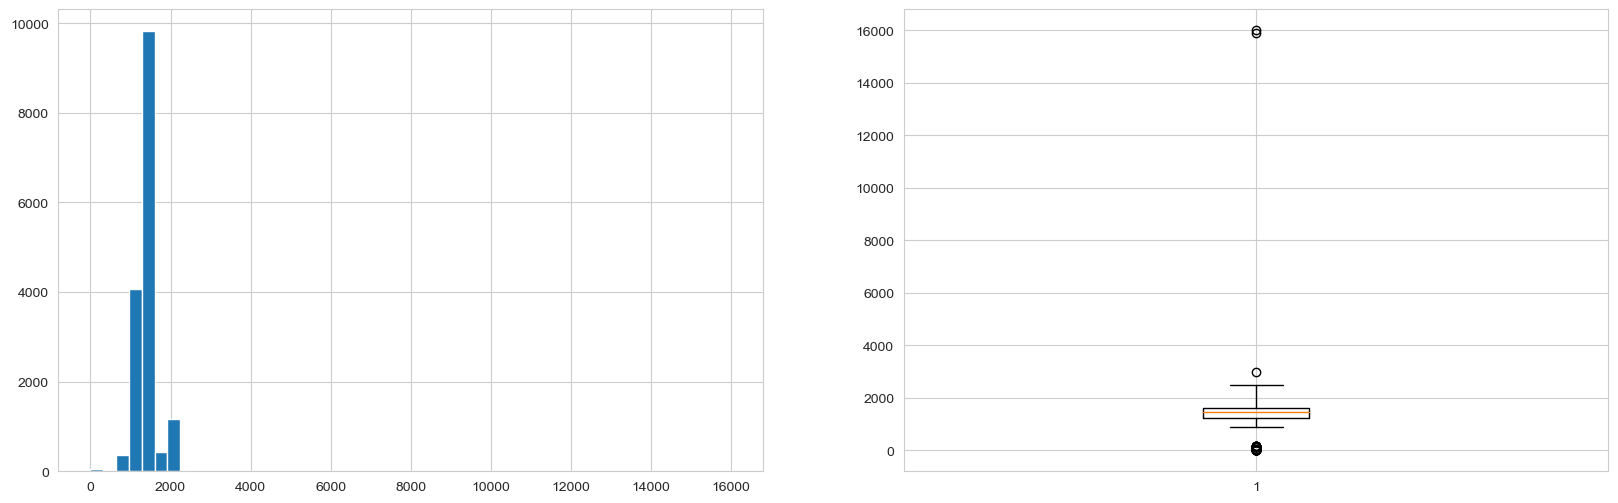

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.Displacement_cc, bins=50)

plt.subplot(122)
plt.boxplot(df.Displacement_cc, whis=2.5)

plt.show()

In [ ]:
df.Displacement_cc.describe()

count   15919.000
mean     1425.609
std       329.720
min         1.000
25%      1229.000
50%      1461.000
75%      1598.000
max     16000.000
Name: Displacement_cc, dtype: float64

In [ ]:
df.sort_values(by=["Displacement_cc"], ascending=False)["Displacement_cc"].head(5)

10932   16000.000
7169    15898.000
10771    2967.000
3595     2480.000
3587     2480.000
Name: Displacement_cc, dtype: float64

In [ ]:
df.sort_values(by=["Displacement_cc"], ascending=True)["Displacement_cc"].head(55)

12790     1.000
14319     1.000
14315     1.000
12849     1.000
12848     1.000
12835     1.000
12823     1.000
12815     1.000
12800     1.000
12798     1.000
12796     1.000
12786     1.000
12783     1.000
12781     1.000
12769     1.000
12768     1.000
12750     1.000
12670     1.000
12604     1.000
12554     1.000
12501     1.000
12499     1.000
12484     1.000
12473     1.000
12467     1.000
14284     1.000
14320     1.000
14321     1.000
14314     1.000
14322     1.000
14328     1.000
14327     1.000
13904     1.000
14325     1.000
14326     1.000
14324     1.000
10559     2.000
14198     2.000
13912    54.000
10194   122.000
7810    139.000
7812    139.000
7811    139.000
7809    139.000
8128    140.000
15578   160.000
15576   160.000
15574   160.000
15575   160.000
15577   160.000
15579   160.000
13653   890.000
14694   898.000
14342   898.000
14695   898.000
Name: Displacement_cc, dtype: float64

In [ ]:
outlier_bool_list = df.Displacement_cc.isin([1, 2, 54, 122, 139, 140, 160, 16000, 15898])

In [ ]:
outlier_bool_list

0        False
1        False
2        False
3        False
4        False
         ...  
15914    False
15915    False
15916    False
15917    False
15918    False
Name: Displacement_cc, Length: 15919, dtype: bool

In [ ]:
df.loc[outlier_bool_list, "Displacement_cc"] = np.nan

In [ ]:
df.Displacement_cc.isnull().sum()

53

In [ ]:
fill(df, "make_model", "body_type", "Displacement_cc", "mode")

Number of NaN :  0
------------------
1598.000    5077
999.000     2467
1398.000    1388
1399.000     772
1461.000     682
1229.000     678
1956.000     670
1490.000     559
1422.000     467
1197.000     372
898.000      351
1395.000     320
1968.000     301
1149.000     288
1618.000     212
1798.000     210
1498.000     196
1600.000     130
1248.000     110
1997.000     103
1364.000     102
1400.000      90
998.000       72
1500.000      50
2000.000      46
1000.000      40
1998.000      25
2480.000      20
1984.000      18
1200.000      18
1397.000      11
899.000       11
929.000        5
1499.000       5
997.000        4
900.000        4
1596.000       4
1599.000       3
1396.000       3
1199.000       3
1589.000       2
1300.000       2
1495.000       2
995.000        2
890.000        1
1333.000       1
1580.000       1
1995.000       1
1533.000       1
1100.000       1
1198.000       1
1496.000       1
1368.000       1
1896.000       1
1584.000       1
1568.000       1
996.000   

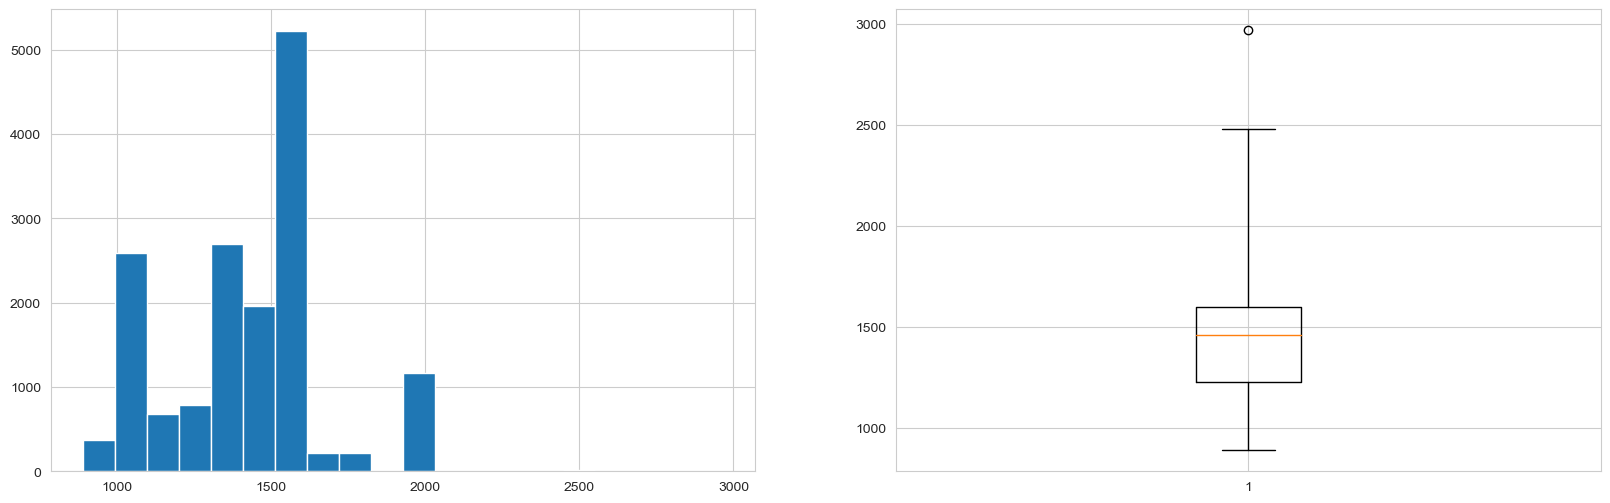

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.Displacement_cc, bins=20)

plt.subplot(122)
plt.boxplot(df.Displacement_cc, whis=2.5)

plt.show()

## Weight_kg

In [ ]:
first_looking("Weight_kg")

column name    :  Weight_kg
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  434
--------------------------------
1163.000    1582
1360.000    1419
1487.000     966
1135.000     837
1425.000     744
1180.000     694
1273.000     656
1165.000     603
1503.000     561
1734.000     556
1087.000     291
1335.000     242
1365.000     211
1199.000     205
1350.000     156
1119.000     153
1355.000     136
1260.000     127
1280.000     127
1275.000     112
1278.000     110
1255.000     108
1200.000     107
1522.000     103
1659.000     102
1195.000      96
1120.000      93
1403.000      91
1701.000      87
1250.000      85
1685.000      83
1441.000      82
1308.000      80
1285.000      80
1613.000      75
1110.000      75
1279.000      72
1364.000      70
1345.000      67
1733.000      65
1325.000      64
1141.000      64
1209.000      64
1071.000      64
1230.000      63
1845.000      56
1090.000      54
1052.000      53
1154.000      52
1664.00

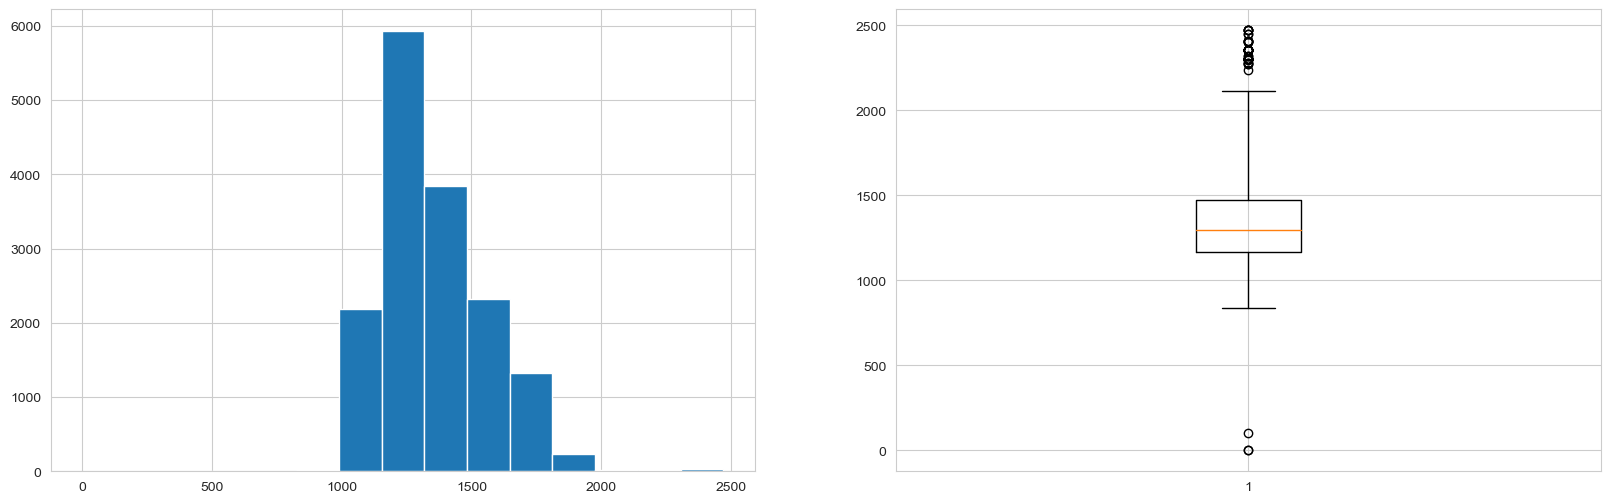

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.Weight_kg, bins=15)

plt.subplot(122)
plt.boxplot(df.Weight_kg, whis=2.5)

plt.show()

In [ ]:
df.Weight_kg.describe()

count   15919.000
mean     1337.432
std       200.466
min         1.000
25%      1165.000
50%      1295.000
75%      1472.000
max      2471.000
Name: Weight_kg, dtype: float64

In [ ]:
df["Weight_kg"].sort_values().head(10)

8355      1.000
12779     1.000
1143    102.000
8857    840.000
14313   900.000
13513   977.000
13555   977.000
14654   980.000
14105   980.000
13999   980.000
Name: Weight_kg, dtype: float64

In [ ]:
df["Weight_kg"].replace([1, 102], np.nan, inplace = True)

In [ ]:
df["Weight_kg"].isnull().sum()

3

In [ ]:
fill(df, "make_model", "body_type", "Weight_kg", "mode")

Number of NaN :  0
------------------
1163.000    1583
1360.000    1419
1487.000     967
1135.000     837
1425.000     744
1180.000     695
1273.000     656
1165.000     603
1503.000     561
1734.000     556
1087.000     291
1335.000     242
1365.000     211
1199.000     205
1350.000     156
1119.000     153
1355.000     136
1280.000     127
1260.000     127
1275.000     112
1278.000     110
1255.000     108
1200.000     107
1522.000     103
1659.000     102
1195.000      96
1120.000      93
1403.000      91
1701.000      87
1250.000      85
1685.000      83
1441.000      82
1308.000      80
1285.000      80
1613.000      75
1110.000      75
1279.000      72
1364.000      70
1345.000      67
1733.000      65
1071.000      64
1141.000      64
1209.000      64
1325.000      64
1230.000      63
1845.000      56
1090.000      54
1052.000      53
1154.000      52
1664.000      52
1513.000      51
1065.000      50
1237.000      49
1440.000      46
1205.000      46
1088.000      46
1265.000  

In [ ]:
df["Weight_kg"].isnull().sum()

0

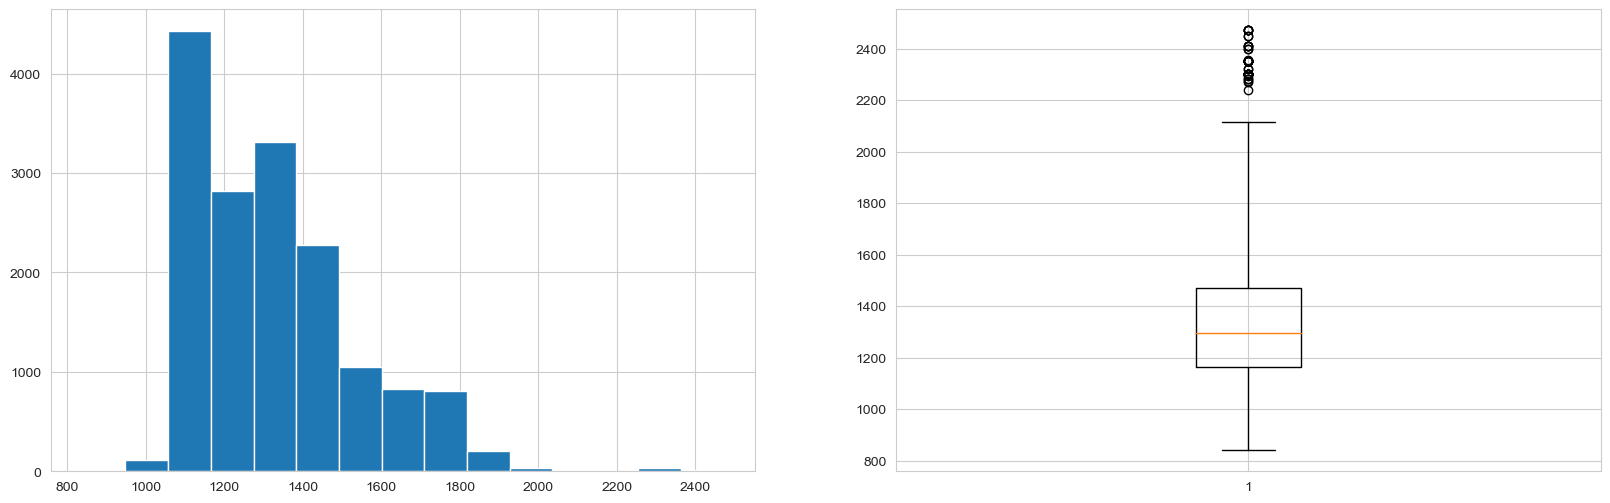

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.Weight_kg, bins=15)

plt.subplot(122)
plt.boxplot(df.Weight_kg, whis=2.5)

plt.show()

## hp_kW

In [ ]:
first_looking("hp_kW")

column name    :  hp_kW
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  80
--------------------------------
85.000     2543
66.000     2124
81.000     1403
100.000    1314
110.000    1113
70.000      890
125.000     711
51.000      696
55.000      589
118.000     550
92.000      466
121.000     392
147.000     380
77.000      353
56.000      294
54.000      276
103.000     253
87.000      232
165.000     194
88.000      177
60.000      160
162.000      98
74.000       81
96.000       72
71.000       59
101.000      47
67.000       40
154.000      39
122.000      35
119.000      30
164.000      27
135.000      24
52.000       22
82.000       22
1.000        20
78.000       20
294.000      18
146.000      18
141.000      16
57.000       10
120.000       8
104.000       8
112.000       7
191.000       7
155.000       6
117.000       6
184.000       5
65.000        4
90.000        4
76.000        4
168.000       3
98.000        3
149.000      

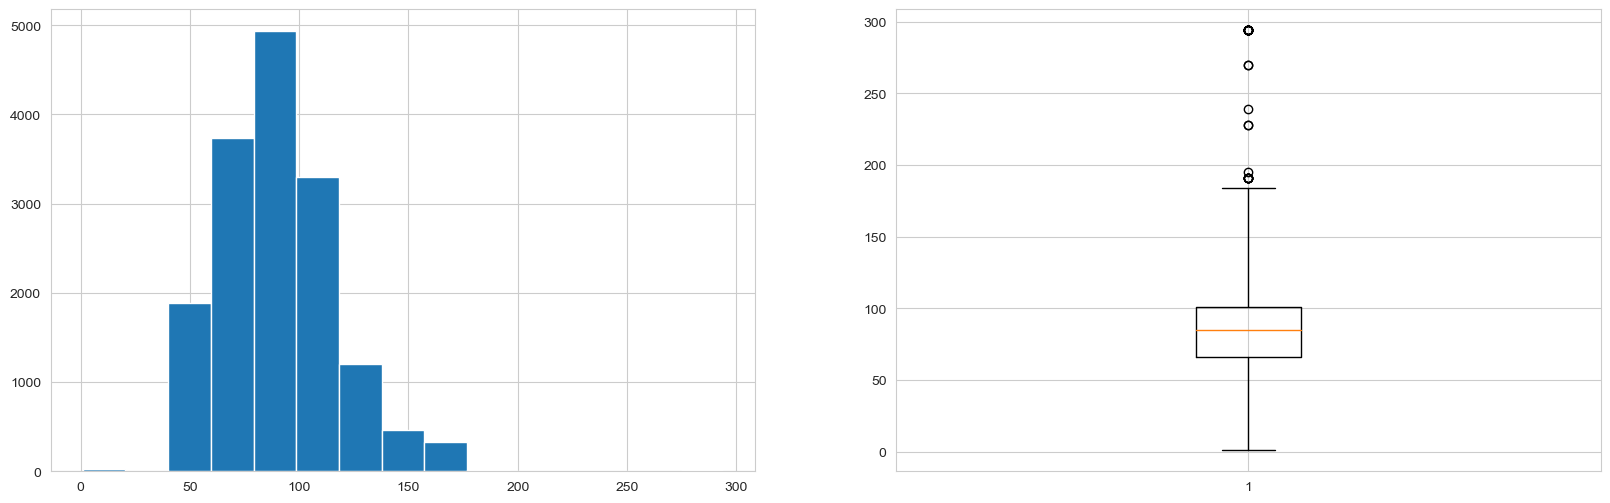

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.hp_kW, bins=15)

plt.subplot(122)
plt.boxplot(df.hp_kW, whis=2.5)

plt.show()

In [ ]:
df.hp_kW.describe()

count   15919.000
mean       88.374
std        26.844
min         1.000
25%        66.000
50%        85.000
75%       101.000
max       294.000
Name: hp_kW, dtype: float64

In [ ]:
df.hp_kW.sort_values().head(50)

6034     1.000
6946     1.000
7014     1.000
9285     1.000
9287     1.000
6005     1.000
9288     1.000
7018     1.000
9289     1.000
9290     1.000
9292     1.000
9299     1.000
10610    1.000
10580    1.000
10579    1.000
10468    1.000
15155    1.000
15156    1.000
7019     1.000
7016     1.000
13885    4.000
3913     9.000
8857    40.000
13759   40.000
8408    44.000
10282   51.000
10283   51.000
10284   51.000
10285   51.000
10286   51.000
10287   51.000
9145    51.000
10288   51.000
10346   51.000
10281   51.000
10330   51.000
9026    51.000
9025    51.000
10342   51.000
10289   51.000
9159    51.000
9384    51.000
9158    51.000
10290   51.000
10291   51.000
10345   51.000
10280   51.000
10279   51.000
10278   51.000
10264   51.000
Name: hp_kW, dtype: float64

In [ ]:
np.sort(df.hp_kW.unique())

array([  1.,   4.,   9.,  40.,  44.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  60.,  63.,  65.,  66.,  67.,  70.,  71.,  74.,  75.,  76.,
        77.,  78.,  80.,  81.,  82.,  84.,  85.,  86.,  87.,  88.,  89.,
        90.,  92.,  93.,  96.,  98., 100., 101., 103., 104., 110., 112.,
       115., 117., 118., 119., 120., 121., 122., 123., 125., 127., 132.,
       133., 135., 137., 140., 141., 143., 146., 147., 149., 150., 154.,
       155., 162., 163., 164., 165., 167., 168., 184., 191., 195., 228.,
       239., 270., 294.])

In [ ]:
df.hp_kW.loc[df.hp_kW < 40] = np.nan

In [ ]:
df.hp_kW.isnull().sum()

22

In [ ]:
fill(df, "make_model", "body_type", "hp_kW", "mode")

Number of NaN :  0
------------------
85.000     2544
66.000     2124
81.000     1403
100.000    1317
110.000    1117
70.000      890
125.000     715
51.000      703
55.000      589
118.000     552
92.000      466
121.000     392
147.000     380
77.000      353
56.000      295
54.000      276
103.000     253
87.000      232
165.000     194
88.000      177
60.000      160
162.000      98
74.000       81
96.000       72
71.000       59
101.000      47
67.000       40
154.000      39
122.000      35
119.000      30
164.000      27
135.000      24
52.000       22
82.000       22
78.000       20
294.000      18
146.000      18
141.000      16
57.000       10
120.000       8
104.000       8
112.000       7
191.000       7
155.000       6
117.000       6
184.000       5
65.000        4
76.000        4
90.000        4
98.000        3
168.000       3
149.000       3
80.000        3
93.000        3
143.000       2
86.000        2
140.000       2
150.000       2
228.000       2
270.000       2
53

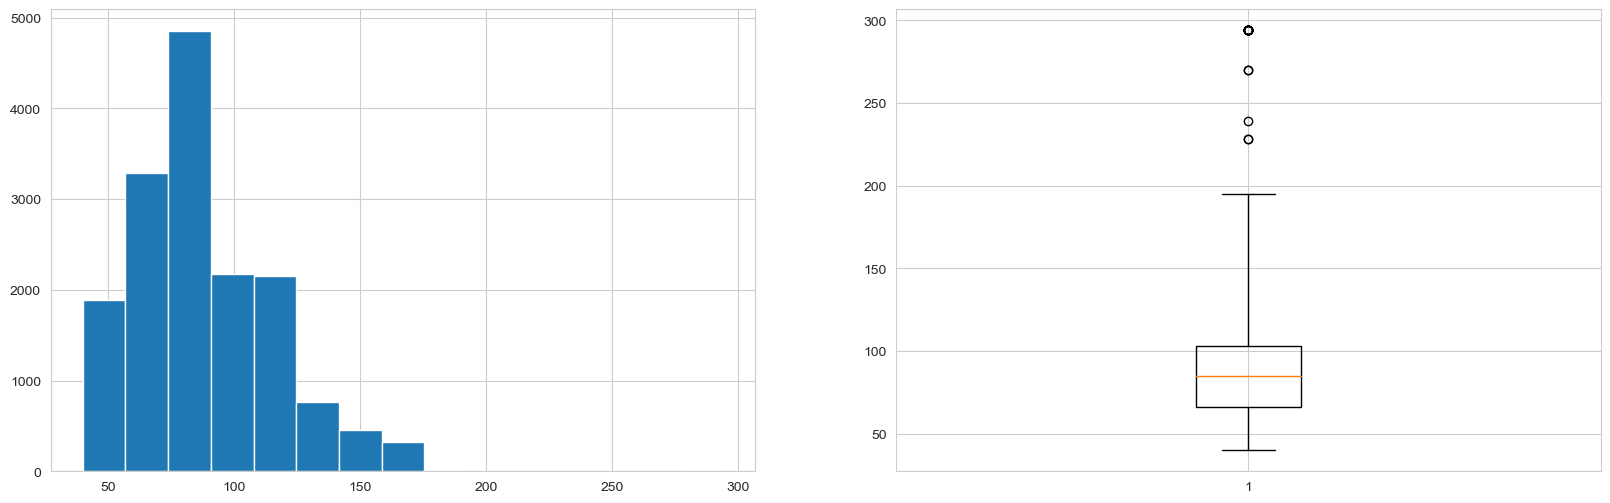

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.hp_kW, bins=15)

plt.subplot(122)
plt.boxplot(df.hp_kW, whis=2.5)

plt.show()

## CO2_Emission

In [ ]:
first_looking("CO2_Emission")

column name    :  CO2_Emission
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  124
--------------------------------
120.000      1000
104.000       782
97.000        631
99.000        593
124.000       574
102.000       501
85.000        456
103.000       445
128.000       425
106.000       418
105.000       401
117.000       394
114.000       390
119.000       381
107.000       379
137.000       376
108.000       362
129.000       356
126.000       353
118.000       270
110.000       266
127.000       257
135.000       252
113.000       237
111.000       237
109.000       234
139.000       224
140.000       218
141.000       214
92.000        198
123.000       189
130.000       180
150.000       174
112.000       171
143.000       171
95.000        161
116.000       157
98.000        156
131.000       151
153.000       149
101.000       147
136.000       145
133.000       145
125.000       133
134.000       130
145.000       126
149.000  

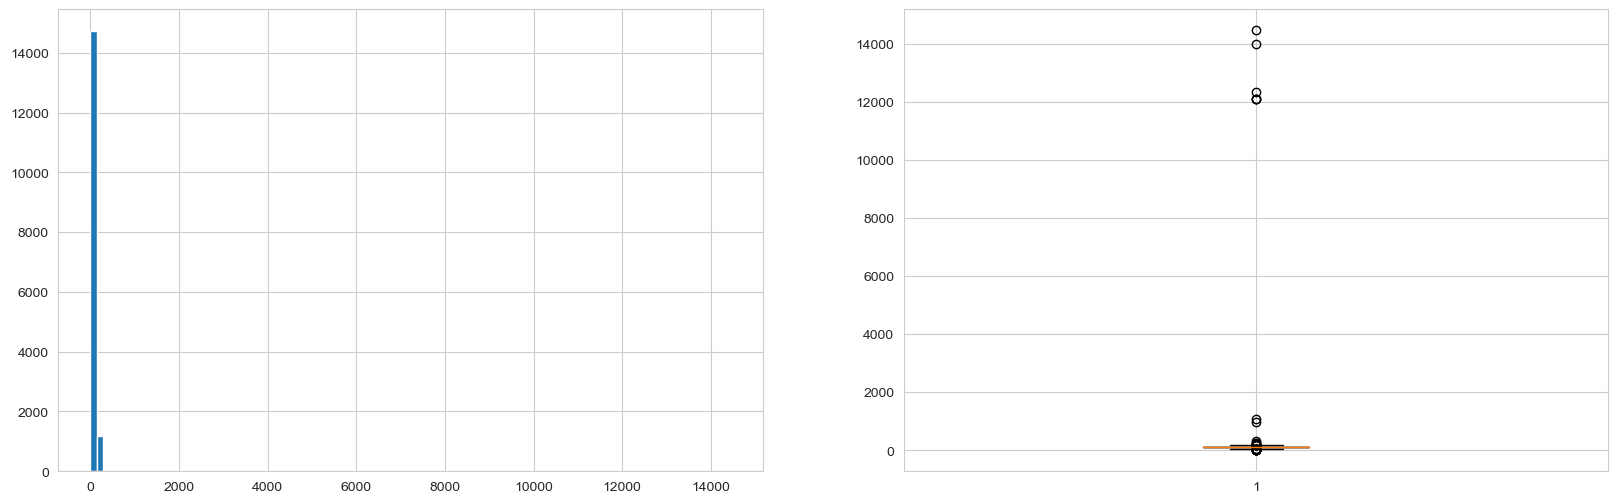

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.CO2_Emission, bins=100)

plt.subplot(122)
plt.boxplot(df.CO2_Emission, whis=2.5)

plt.show()

In [ ]:
df.CO2_Emission.describe()

count   15919.000
mean      122.619
std       248.534
min         0.000
25%       104.000
50%       117.000
75%       129.000
max     14457.000
Name: CO2_Emission, dtype: float64

In [ ]:
df.CO2_Emission.value_counts().sort_index()

0.000           2
1.000           1
5.000           3
14.000          1
36.000          5
45.000          1
51.000          1
80.000          1
82.000         25
84.000          2
85.000        456
87.000          6
88.000         15
89.000         19
90.000         35
91.000         31
92.000        198
93.000         66
94.000         42
95.000        161
96.000         22
97.000        631
98.000        156
99.000        593
100.000        55
101.000       147
102.000       501
103.000       445
104.000       782
105.000       401
106.000       418
107.000       379
108.000       362
109.000       234
110.000       266
111.000       237
112.000       171
113.000       237
114.000       390
115.000        86
116.000       157
117.000       394
118.000       270
119.000       381
120.000      1000
121.000        82
122.000        84
123.000       189
124.000       574
125.000       133
126.000       353
127.000       257
128.000       425
129.000       356
130.000       180
131.000   

In [ ]:
df.groupby(["make_model", "body_type", "CO2_Emission"]).price.describe()

count      mean       std  \
make_model     body_type     CO2_Emission                               
Audi A1        Compact       90.000         1.000 12880.000       NaN   
                             91.000         5.000 13038.000  1108.927   
                             92.000         1.000 12479.000       NaN   
                             94.000         5.000 13960.000  1232.071   
                             97.000       113.000 15449.593  2445.755   
                             98.000        33.000 16574.364  2637.087   
                             99.000        19.000 16043.947  2257.403   
                             100.000        4.000 16127.500  1583.401   
                             102.000      170.000 16551.159  2943.687   
                             103.000       30.000 21233.033  1794.551   
                             104.000      126.000 17411.413  3149.373   
                             105.000       14.000 22234.857   812.264   
                             106.000      112.000 19622.223  3864.432   
                             107.000       13.000 16527.692  1620.412   
                             108.000       42.000 23587.095  3375.693   
                             109.000       34.000 17029.324  2514.314   
                             110.000       51.000 26340.373  2434.738   
                             111.000      138.000 23765.283  3477.921   
                             112.000       25.000 19960.360  2676.262   
                             113.000        5.000 20388.000  2796.188   
                             114.000        1.000 15490.000       NaN   
                             115.000        7.000 24067.857  6950.650   
                             116.000       20.000 23580.950  2813.103   
                             117.000        8.000 19094.875  2942.954   
                             118.000        2.000 13615.000    91.924   
                             119.000        1.000 12550.000       NaN   
                             120.000       27.000 15850.000     0.000   
                             121.000        2.000 18710.000  3224.407   
                             122.000        1.000 20881.000       NaN   
                             123.000       17.000 19308.647  3816.070   
                             126.000        1.000 19999.000       NaN   
                             127.000        2.000 19888.000     0.000   
                             134.000        2.000 22495.000   841.457   
                             136.000        2.000 29088.000   128.693   
                             137.000        2.000 28660.000   282.843   
                             142.000        2.000 28750.000   268.701   
                             331.000        1.000 12990.000       NaN   
               Coupe         97.000         2.000 14925.000  1378.858   
               Sedans        89.000         4.000 16572.500   288.141   
                             90.000         3.000 14396.333   532.382   
                             91.000        14.000 14228.500  1438.927   
                             92.000        42.000 15764.548  1578.276   
                             94.000        12.000 15710.000  2522.329   
                             95.000         2.000 13070.000  2305.168   
                             97.000       315.000 14905.857  1996.270   
                             98.000        66.000 16021.848  1512.571   
                             99.000       148.000 16132.919  2295.535   
                             100.000        3.000 14490.000     0.000   
                             101.000        5.000 19228.000  1683.574   
                             102.000      198.000 17497.909  2518.189   
                             103.000       10.000 17725.000  3092.084   
                             104.000      256.000 20179.859  3917.247   
                             105.000       55.000 19634.273  2174.292   
                             

In [ ]:
cond = ((df.CO2_Emission < 36) | (df.CO2_Emission > 330))

df.loc[cond, "CO2_Emission"] = np.nan

In [ ]:
df.CO2_Emission.isnull().sum()

16

In [ ]:
fill(df, "make_model", "body_type", "CO2_Emission", "median")

Number of NaN :  0
------------------
120.000    1000
104.000     782
97.000      631
99.000      593
124.000     574
102.000     501
85.000      456
103.000     445
128.000     425
106.000     420
105.000     402
117.000     394
114.000     390
119.000     384
107.000     379
137.000     376
108.000     362
129.000     357
126.000     353
118.000     270
110.000     266
127.000     257
135.000     252
113.000     237
111.000     237
109.000     234
139.000     224
140.000     218
141.000     214
92.000      198
123.000     189
130.000     180
150.000     174
112.000     171
143.000     171
95.000      161
116.000     157
98.000      156
131.000     152
153.000     149
101.000     147
136.000     145
133.000     145
125.000     133
134.000     130
145.000     126
149.000     117
147.000     109
132.000     100
115.000      86
122.000      84
121.000      82
138.000      79
93.000       66
168.000      58
142.000      58
100.000      55
148.000      48
94.000       42
154.000      40
14

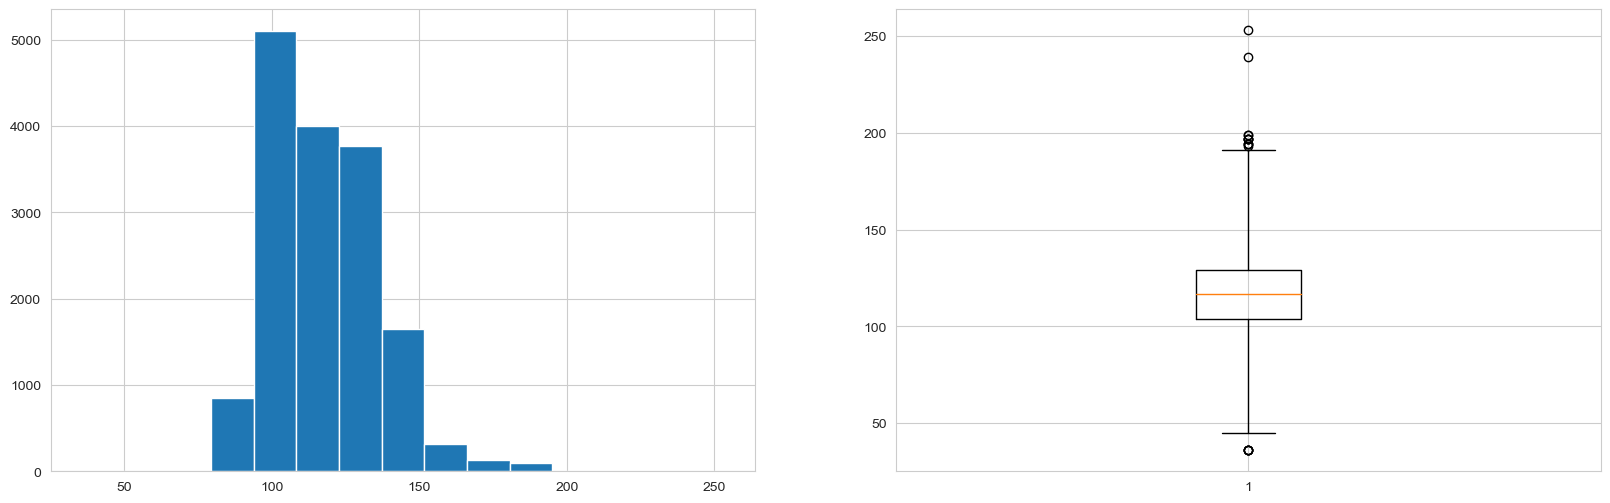

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.CO2_Emission, bins=15)

plt.subplot(122)
plt.boxplot(df.CO2_Emission, whis=2.5)

plt.show()

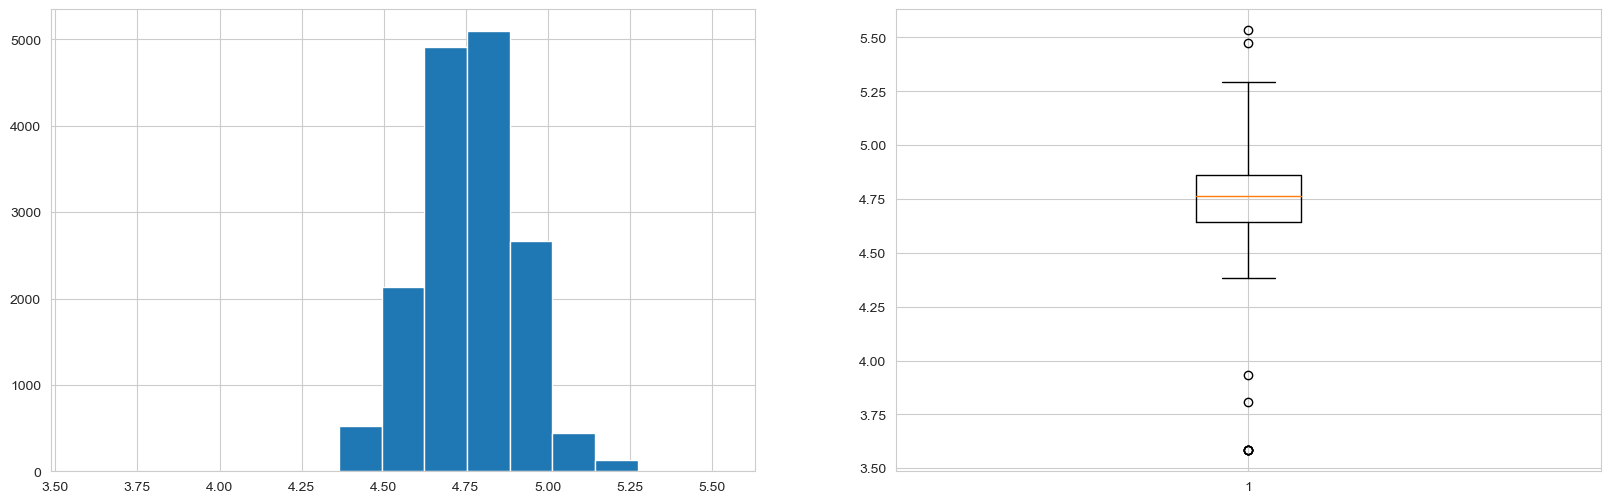

In [ ]:
plt.figure(figsize = (20, 6))

plt.subplot(121)
plt.hist(np.log(df.CO2_Emission), bins=15)

plt.subplot(122)
plt.boxplot(np.log(df.CO2_Emission), whis=2.5)

plt.show()

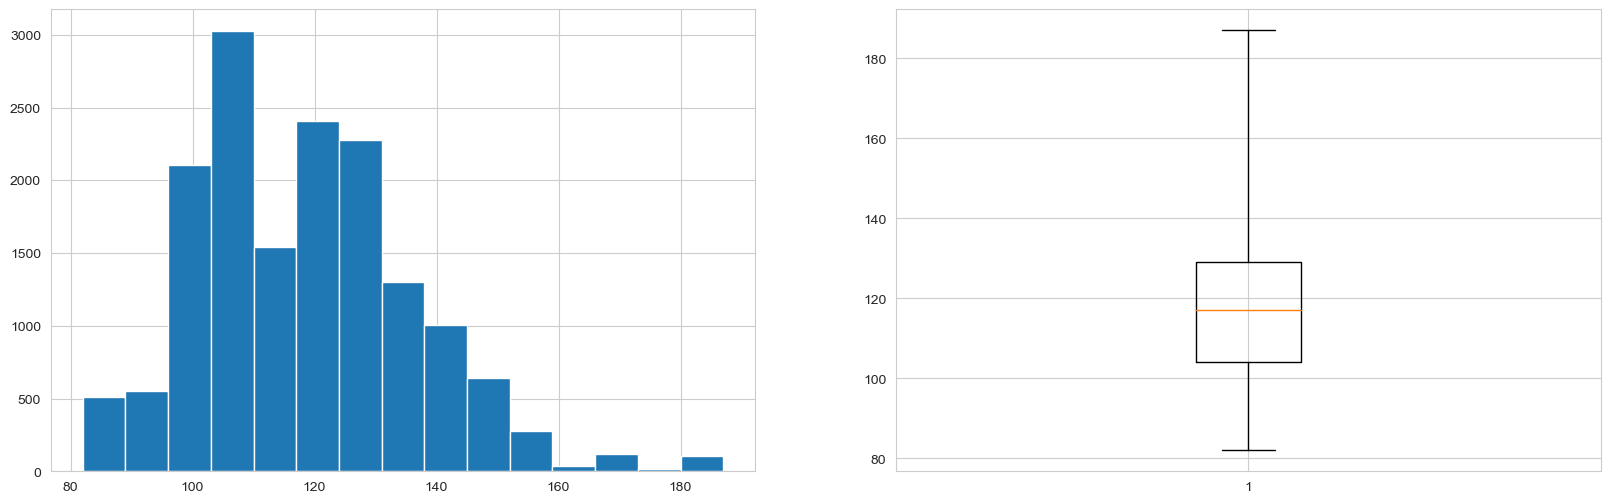

In [ ]:
plt.figure(figsize = (20, 6))

plt.subplot(121)
plt.hist(winsorize(df.CO2_Emission, (0.001, 0.003)), bins = 15)

plt.subplot(122)
plt.boxplot(winsorize(df.CO2_Emission, (0.001, 0.003)), whis=2.5)

plt.show()

## cons_comb

In [ ]:
first_looking("cons_comb")

column name    :  cons_comb
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  63
--------------------------------
5.400    990
4.000    905
3.900    846
4.700    785
5.600    781
5.100    769
3.800    678
5.200    666
4.400    624
4.800    580
5.000    553
4.600    539
4.500    524
4.900    495
3.300    446
3.700    441
4.200    436
5.900    395
5.300    390
5.500    383
5.700    342
4.100    342
6.000    331
4.300    308
3.500    288
6.200    260
3.600    232
6.100    182
6.300    181
5.800    165
6.800    156
6.600    148
3.400    130
5.350    101
6.400     75
3.000     69
7.400     66
6.500     43
6.700     43
7.100     38
6.900     27
3.200     25
3.650     20
8.300     20
5.150     19
7.600     14
7.000     10
5.850      7
3.100      7
7.200      6
7.800      6
8.000      5
1.600      5
8.600      4
3.950      3
8.700      3
7.900      3
7.300      2
8.100      2
5.450      2
4.550      1
9.100      1
7.500      1
Name: cons_comb, dtype

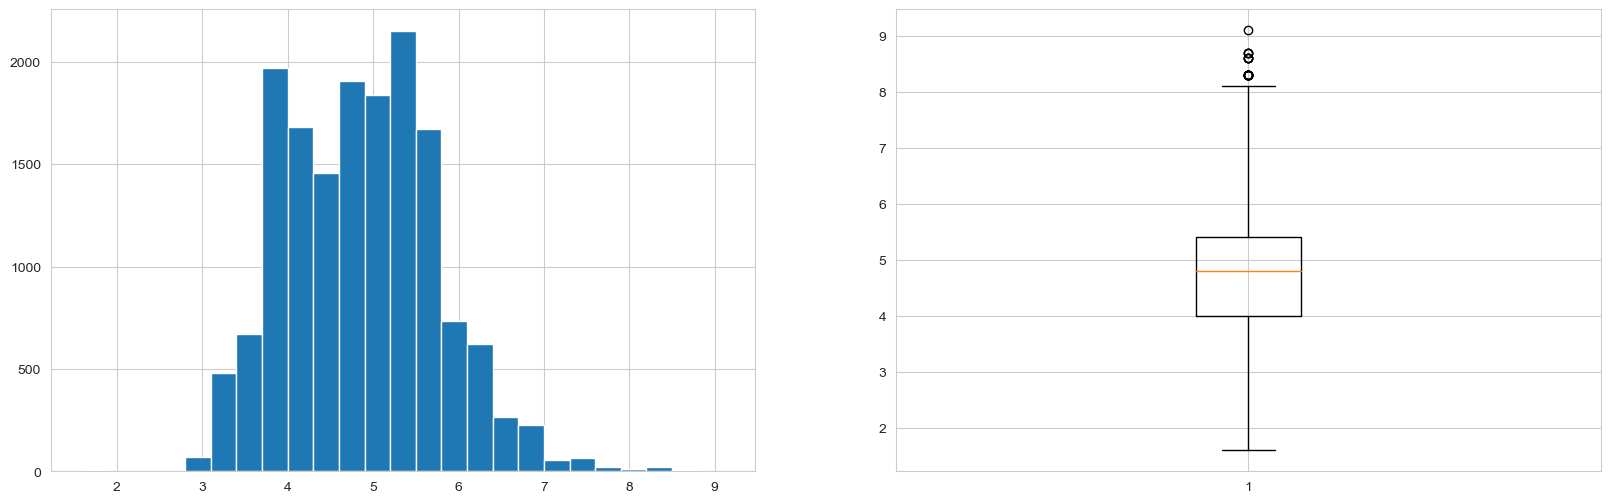

In [ ]:
plt.figure(figsize = (20, 6))

plt.subplot(121)
plt.hist(df.cons_comb, bins = 25)

plt.subplot(122)
plt.boxplot(df.cons_comb, whis = 2)

plt.show()

In [ ]:
df.cons_comb.describe()

count   15919.000
mean        4.823
std         0.890
min         1.600
25%         4.000
50%         4.800
75%         5.400
max         9.100
Name: cons_comb, dtype: float64

In [ ]:
df.cons_comb.sort_values().head(10)

3615    1.600
13397   1.600
3612    1.600
3356    1.600
3617    1.600
8805    3.000
13493   3.000
6240    3.000
6241    3.000
13494   3.000
Name: cons_comb, dtype: float64

In [ ]:
df.cons_comb.sort_values().tail(10)

10515   8.300
3601    8.300
10789   8.600
12553   8.600
12422   8.600
12530   8.600
12054   8.700
10817   8.700
12529   8.700
10771   9.100
Name: cons_comb, dtype: float64

**Considering our domain knowledge, we can conclude that min value of 3 and max value of 9.10 are normal.**

## Nr_of_Doors

In [ ]:
first_looking("Nr_of_Doors")

column name    :  Nr_of_Doors
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  6
--------------------------------
5.000    11787
4.000     3079
3.000      832
2.000      219
1.000        1
7.000        1
Name: Nr_of_Doors, dtype: int64


In [ ]:
df.Nr_of_Doors.replace([1, 7], np.nan, inplace=True)

In [ ]:
df.Nr_of_Doors.isnull().sum()

2

In [ ]:
fill(df, "make_model", "body_type", "Nr_of_Doors", "mode")

Number of NaN :  0
------------------
5.000    11789
4.000     3079
3.000      832
2.000      219
Name: Nr_of_Doors, dtype: int64


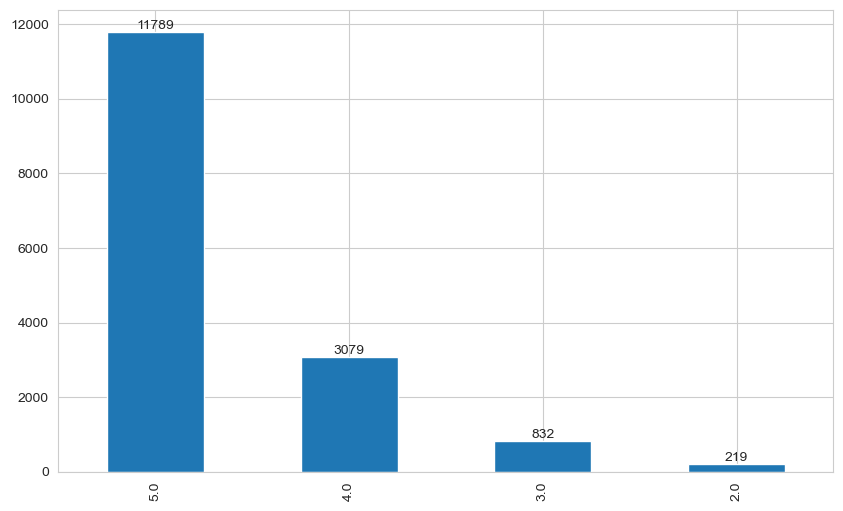

In [ ]:
fig, ax = plt.subplots()

df.Nr_of_Doors.value_counts(dropna = False).plot.bar()

for container in ax.containers:
    ax.bar_label(container);

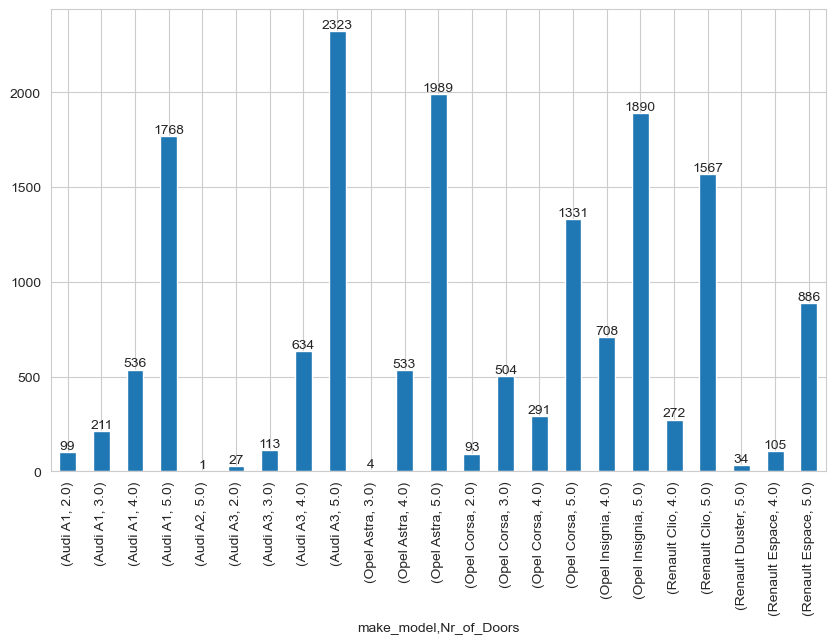

In [ ]:
fig, ax = plt.subplots()

df.groupby(["make_model", "Nr_of_Doors"]).Nr_of_Doors.count().plot.bar()

for container in ax.containers:
    ax.bar_label(container);

In [ ]:
df.drop("Nr_of_Doors", axis=1, inplace=True)

## Nr_of_Seats

In [ ]:
first_looking("Nr_of_Seats")

column name    :  Nr_of_Seats
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  6
--------------------------------
5.000    14308
4.000     1127
7.000      362
2.000      119
6.000        2
3.000        1
Name: Nr_of_Seats, dtype: int64


In [ ]:
df.Nr_of_Seats.replace([3, 6], np.nan, inplace=True)

In [ ]:
df.Nr_of_Seats.isnull().sum()

3

In [ ]:
fill(df, "make_model", "body_type", "Nr_of_Seats", "mode")

Number of NaN :  0
------------------
5.000    14311
4.000     1127
7.000      362
2.000      119
Name: Nr_of_Seats, dtype: int64


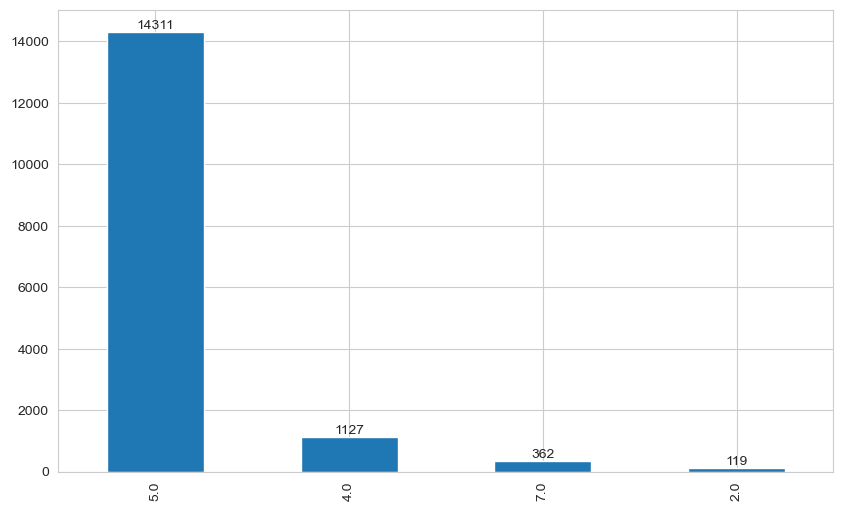

In [ ]:
fig, ax = plt.subplots()

df.Nr_of_Seats.value_counts(dropna=False).plot.bar()

for container in ax.containers:
    ax.bar_label(container);

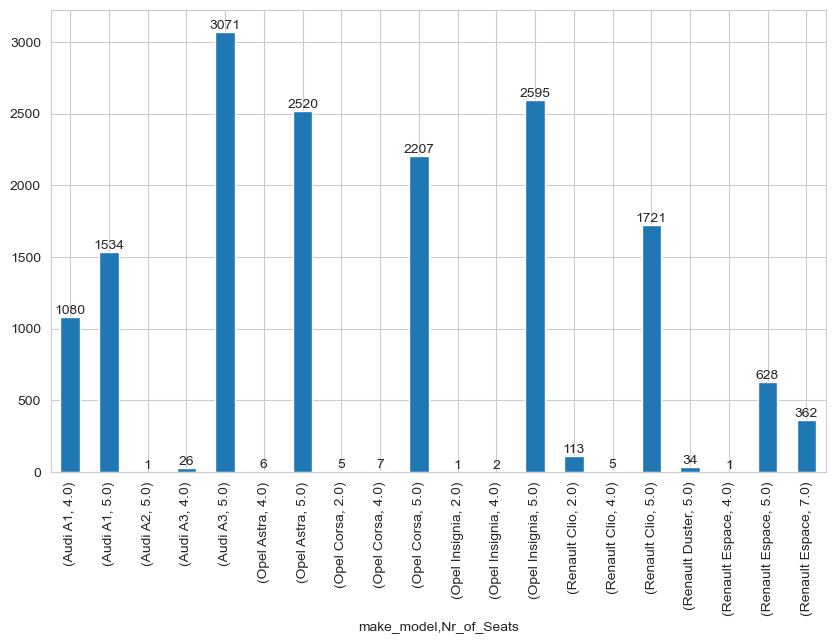

In [ ]:
fig, ax = plt.subplots()

df.groupby(["make_model", "Nr_of_Seats"]).Nr_of_Seats.count().plot.bar()

for container in ax.containers:
    ax.bar_label(container);

In [ ]:
df.drop("Nr_of_Seats", axis=1, inplace=True)

## price

In [ ]:
first_looking("price")

column name    :  price
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2956
--------------------------------
14990    154
15990    151
10990    139
15900    106
17990    102
        ... 
17559      1
17560      1
17570      1
17575      1
39875      1
Name: price, Length: 2956, dtype: int64


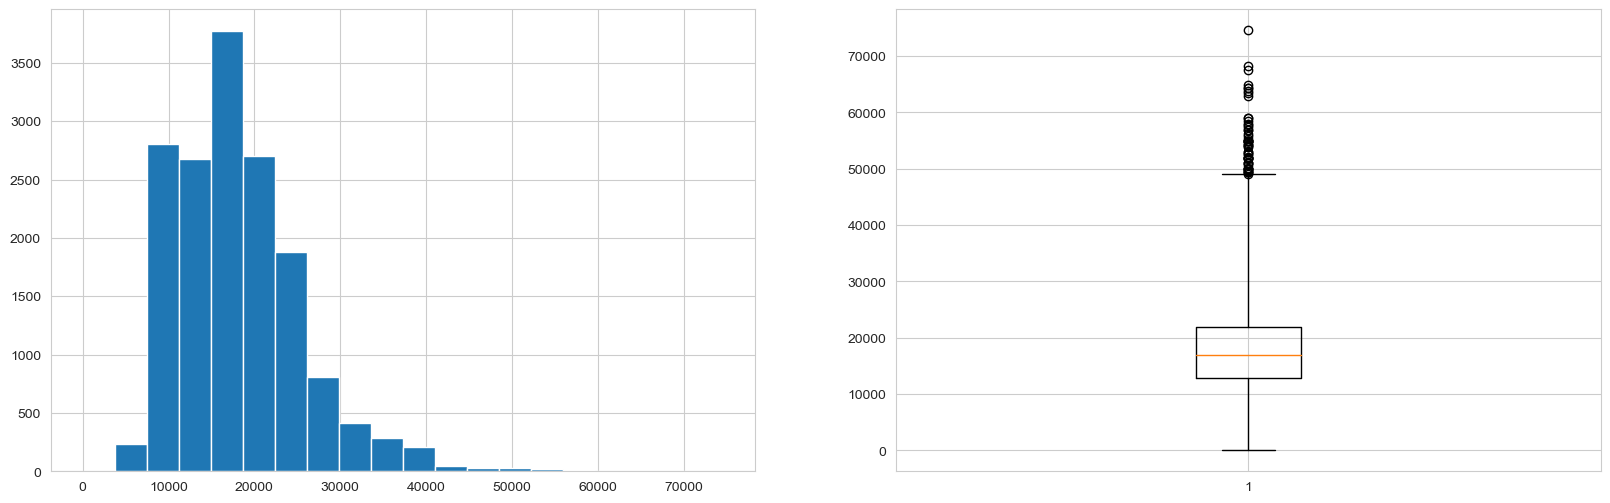

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.price, bins=20)

plt.subplot(122)
plt.boxplot(df.price, whis=3)

plt.show()

In [ ]:
df.price.describe()

count   15919.000
mean    18019.897
std      7386.169
min        13.000
25%     12850.000
50%     16900.000
75%     21900.000
max     74600.000
Name: price, dtype: float64

In [ ]:
df.price.sort_values().head(5)

8594      13
8828     120
6066     255
8829     331
8827    4950
Name: price, dtype: int64

In [ ]:
drop_index = df.price.sort_values().index[:4]
drop_index

Int64Index([8594, 8828, 6066, 8829], dtype='int64')

In [ ]:
df.drop(drop_index, axis=0, inplace=True)

In [ ]:
df.shape

(15915, 23)

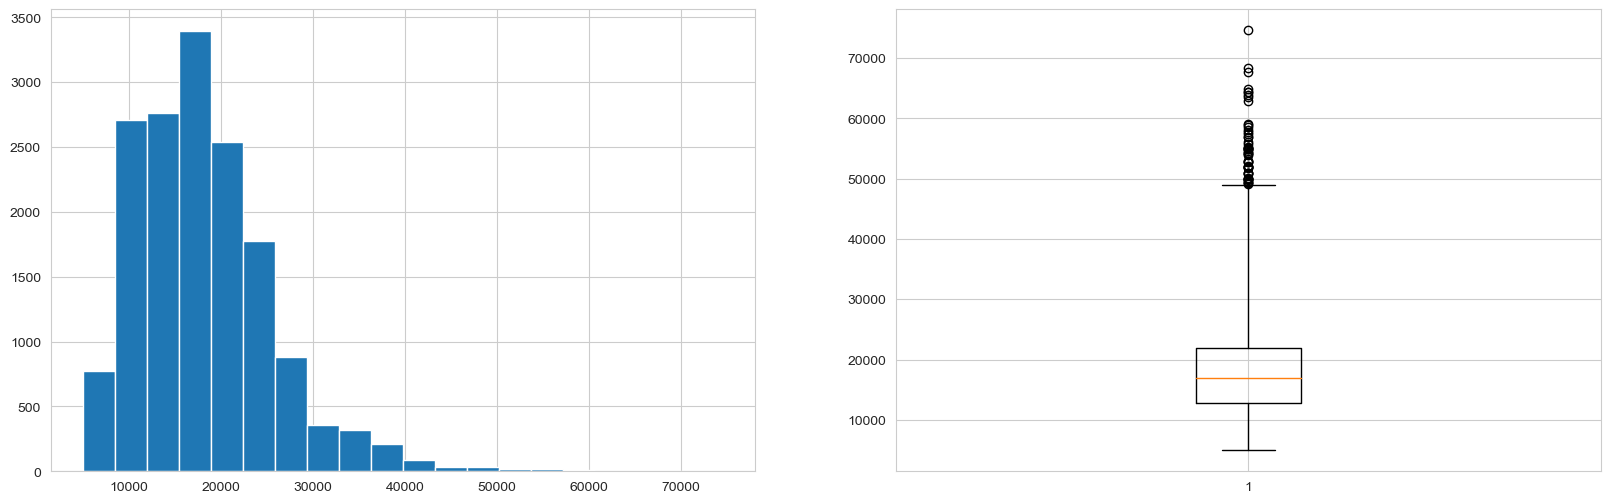

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.price, bins=20)

plt.subplot(122)
plt.boxplot(df.price, whis=3)

plt.show()

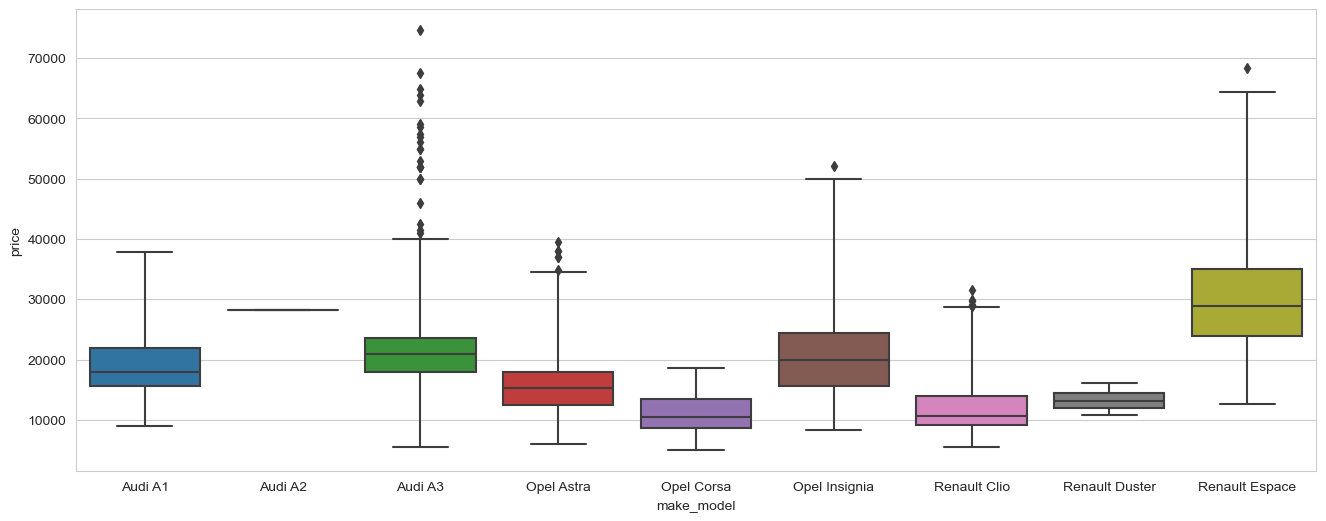

In [ ]:
plt.figure(figsize=(16, 6))
sns.boxplot(x="make_model", y="price", data=df, whis=3)
plt.show()

## make_model

In [ ]:
first_looking("make_model")

column name    :  make_model
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  9
--------------------------------
Audi A3           3097
Audi A1           2614
Opel Insignia     2598
Opel Astra        2525
Opel Corsa        2216
Renault Clio      1839
Renault Espace     991
Renault Duster      34
Audi A2              1
Name: make_model, dtype: int64


In [ ]:
df[df.make_model=="Audi A2"]

make_model body_type  price        km            Type    Fuel  \
2614    Audi A2  Off-Road  28200 26166.000  Employee's car  Diesel   

            Extras  Gears   age  Previous_Owners  hp_kW  Inspection_new  \
2614  Alloy wheels  6.000 1.000            1.000 85.000               0   

     Paint_Type Upholstery_type Gearing_Type  Displacement_cc  Weight_kg  \
2614   Metallic           Cloth       Manual         1598.000   1135.000   

     Drive_chain  cons_comb  CO2_Emission Comfort_Convenience_Package  \
2614       front      4.900       117.000                    Standard   

     Entertainment_Media_Package Safety_Security_Package  
2614                        Plus  Safety Premium Package

The **``Audi A2``** (internally designated Typ 8Z) is a compact MPV-styled supermini car, with a five-door hatchback body style and four or five seats, produced by the German manufacturer Audi **from November 1999 (for the 2000 model year) to August 2005** [Source](https://en.wikipedia.org/wiki/Audi_A2). **So it is impossible to be a 1-year old Audi A2**.

In [ ]:
drop_index = df[df.make_model == "Audi A2"].index
drop_index

Int64Index([2614], dtype='int64')

In [ ]:
df.drop(drop_index, axis=0, inplace=True)

In [ ]:
df.shape

(15914, 23)

## Fuel

In [ ]:
first_looking("Fuel")

column name    :  Fuel
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  4
--------------------------------
Benzine     8548
Diesel      7297
LPG/CNG       64
Electric       5
Name: Fuel, dtype: int64


In [ ]:
df[df.Fuel == "Electric"][["make_model", "body_type", "CO2_Emission", "Gears", "hp_kW", "cons_comb", "price"]]

make_model body_type  CO2_Emission  Gears   hp_kW  cons_comb  price
3356        Audi A3   Compact        36.000  6.000 150.000      1.600  24950
3612        Audi A3    Sedans        36.000  6.000 110.000      1.600  38450
3615        Audi A3    Sedans        36.000  6.000 110.000      1.600  35899
3617        Audi A3    Sedans        36.000  6.000 110.000      1.600  38000
13397  Renault Clio    Sedans        36.000  6.000  55.000      1.600   8490

In [ ]:
drop_index = df[df.Fuel == "Electric"].index
drop_index

Int64Index([3356, 3612, 3615, 3617, 13397], dtype='int64')

In [ ]:
df.drop(drop_index, axis=0, inplace=True)

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df.shape

(15909, 23)

## Final_Step

In [ ]:
df.head(3).T

0  \
make_model                                                            Audi A1   
body_type                                                              Sedans   
price                                                                   15770   
km                                                                  56013.000   
Type                                                                     Used   
Fuel                                                                   Diesel   
Extras                       Alloy wheels, Catalytic Converter, Voice Control   
Gears                                                                   7.000   
age                                                                     3.000   
Previous_Owners                                                         2.000   
hp_kW                                                                  66.000   
Inspection_new                                                              1   
Paint_Type                                                           Metallic   
Upholstery_type                                                         Cloth   
Gearing_Type                                                        Automatic   
Displacement_cc                                                      1422.000   
Weight_kg                                                            1220.000   
Drive_chain                                                             front   
cons_comb                                                               3.800   
CO2_Emission                                                           99.000   
Comfort_Convenience_Package                                           Premium   
Entertainment_Media_Package                                              Plus   
Safety_Security_Package                                Safety Premium Package   

                                                                             1  \
make_model                                                             Audi A1   
body_type                                                               Sedans   
price                                                                    14500   
km                                                                   80000.000   
Type                                                                      Used   
Fuel                                                                   Benzine   
Extras                       Alloy wheels, Sport seats, Sport suspension, V...   
Gears                                                                    7.000   
age                                                                      2.000   
Previous_Owners                                                          1.000   
hp_kW                                                                  141.000   
Inspection_new                                                               0   
Paint_Type                                                            Metallic   
Upholstery_type                                                          Cloth   
Gearing_Type                                                         Automatic   
Displacement_cc                                                       1798.000   
Weight_kg                                                             1255.000   
Drive_chain                                                              front   
cons_comb                                                                5.600   
CO2_Emission                                                           129.000   
Comfort_Convenience_Package                                           Standard   
Entertainment_Media_Package                                               Plus   
Safety_Security_Package                                 Safety Premium Package   

                                                       2  
make_model                                       Audi A1  
body_type                                   

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15909 entries, 0 to 15908
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   make_model                   15909 non-null  object 
 1   body_type                    15909 non-null  object 
 2   price                        15909 non-null  int64  
 3   km                           15909 non-null  float64
 4   Type                         15909 non-null  object 
 5   Fuel                         15909 non-null  object 
 6   Extras                       15909 non-null  object 
 7   Gears                        15909 non-null  float64
 8   age                          15909 non-null  float64
 9   Previous_Owners              15909 non-null  float64
 10  hp_kW                        15909 non-null  float64
 11  Inspection_new               15909 non-null  int64  
 12  Paint_Type                   15909 non-null  object 
 13  Upholstery_type 

In [ ]:
df_num = df.select_dtypes("number")
df_num

price        km  Gears   age  Previous_Owners   hp_kW  Inspection_new  \
0      15770 56013.000  7.000 3.000            2.000  66.000               1   
1      14500 80000.000  7.000 2.000            1.000 141.000               0   
2      14640 83450.000  7.000 3.000            1.000  85.000               0   
3      14500 73000.000  6.000 3.000            1.000  66.000               0   
4      16790 16200.000  7.000 3.000            1.000  66.000               1   
...      ...       ...    ...   ...              ...     ...             ...   
15904  39950  1647.363  6.000 0.000            1.000 147.000               0   
15905  39885  9900.000  7.000 0.000            1.000 165.000               0   
15906  39875    15.000  6.000 0.000            1.000 146.000               1   
15907  39700    10.000  6.000 0.000            1.000 147.000               0   
15908  40999  1647.363  6.000 0.000            1.000 165.000               1   

       Displacement_cc  Weight_kg  cons_comb  CO2_Emission  
0             1422.000   1220.000      3.800        99.000  
1             1798.000   1255.000      5.600       129.000  
2             1598.000   1135.000      3.800        99.000  
3             1422.000   1195.000      3.800        99.000  
4             1422.000   1135.000      4.100       109.000  
...                ...        ...        ...           ...  
15904         1997.000   1758.000      5.300       139.000  
15905         1798.000   1708.000      7.400       168.000  
15906         1997.000   1734.000      5.300       139.000  
15907         1997.000   1758.000      5.300       139.000  
15908         1798.000   1685.000      6.800       153.000  

[15909 rows x 11 columns]

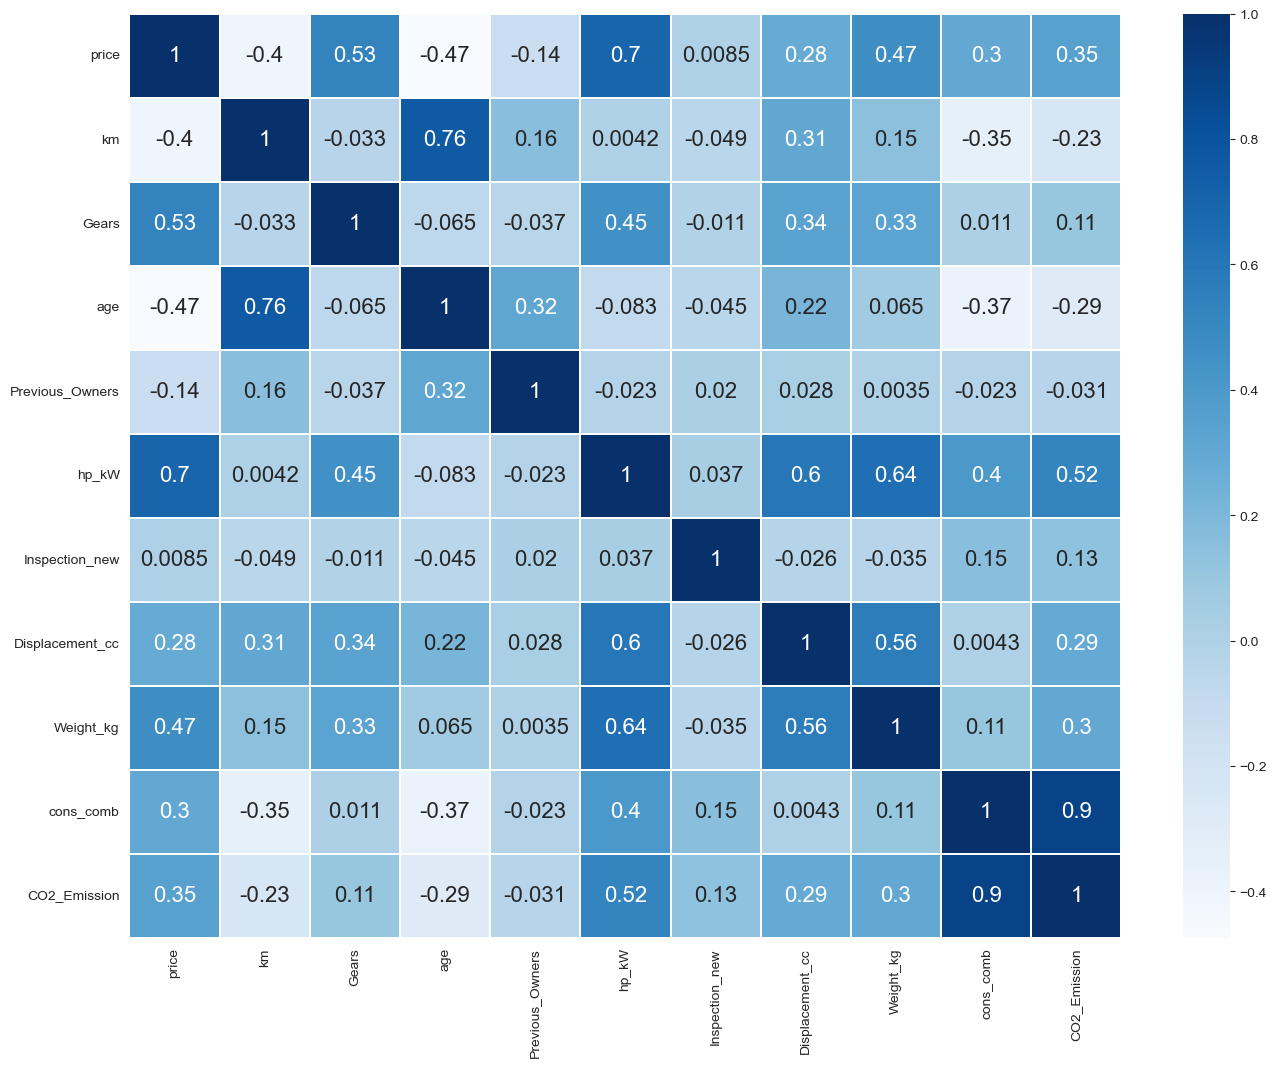

In [ ]:
plt.figure(figsize=(16, 12))

sns.heatmap(df_num.corr(), annot=True, cmap="Blues", linewidths=0.2, annot_kws={"size": 16});

In [ ]:
# function for set text color of correlation values in Dataframes

def color_correlation(val):
    """
    Takes a scalar and returns a string with
    the css property in a variety of color scales 
    for different correlations.
    """
    if val >= 0.6 and val < 0.99999 or val <= -0.6 and val > -0.99999:
        color = 'red'
    elif val < 0.6 and val >= 0.3 or val > -0.6 and val <= -0.3:
        color = 'blue'
    elif val == 1:
        color = 'cyan'    
    else:
        color = 'black'
    return 'color: %s' % color
 
df_num.corr().style.applymap(color_correlation)

In [ ]:
# sns.pairplot(df_num, size=2.5);

## <p style="background-color:#9d4f8c; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">Some Specific Questions on Analysis</p>

<a id="3"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>

### 1. What is the average kilometer of the vehicles according to their body types?

In [ ]:
avg_km = df.groupby(["make_model", "body_type"]).km.mean()
avg_km

make_model      body_type    
Audi A1         Compact         20668.668
                Coupe           38650.000
                Sedans          22706.169
                Station wagon   22421.048
                Van              3000.000
Audi A3         Compact         62481.837
                Convertible     20532.875
                Coupe           26876.500
                Sedans          37194.306
                Station wagon   34814.260
Opel Astra      Compact         28041.784
                Coupe           11293.681
                Off-Road        12607.000
                Sedans          26394.506
                Station wagon   46588.099
Opel Corsa      Compact         19848.416
                Coupe           33260.105
                Off-Road        50729.000
                Sedans          31992.909
                Transporter     52018.623
                Van             33633.000
Opel Insignia   Compact         21232.828
                Coupe           28142.000
    

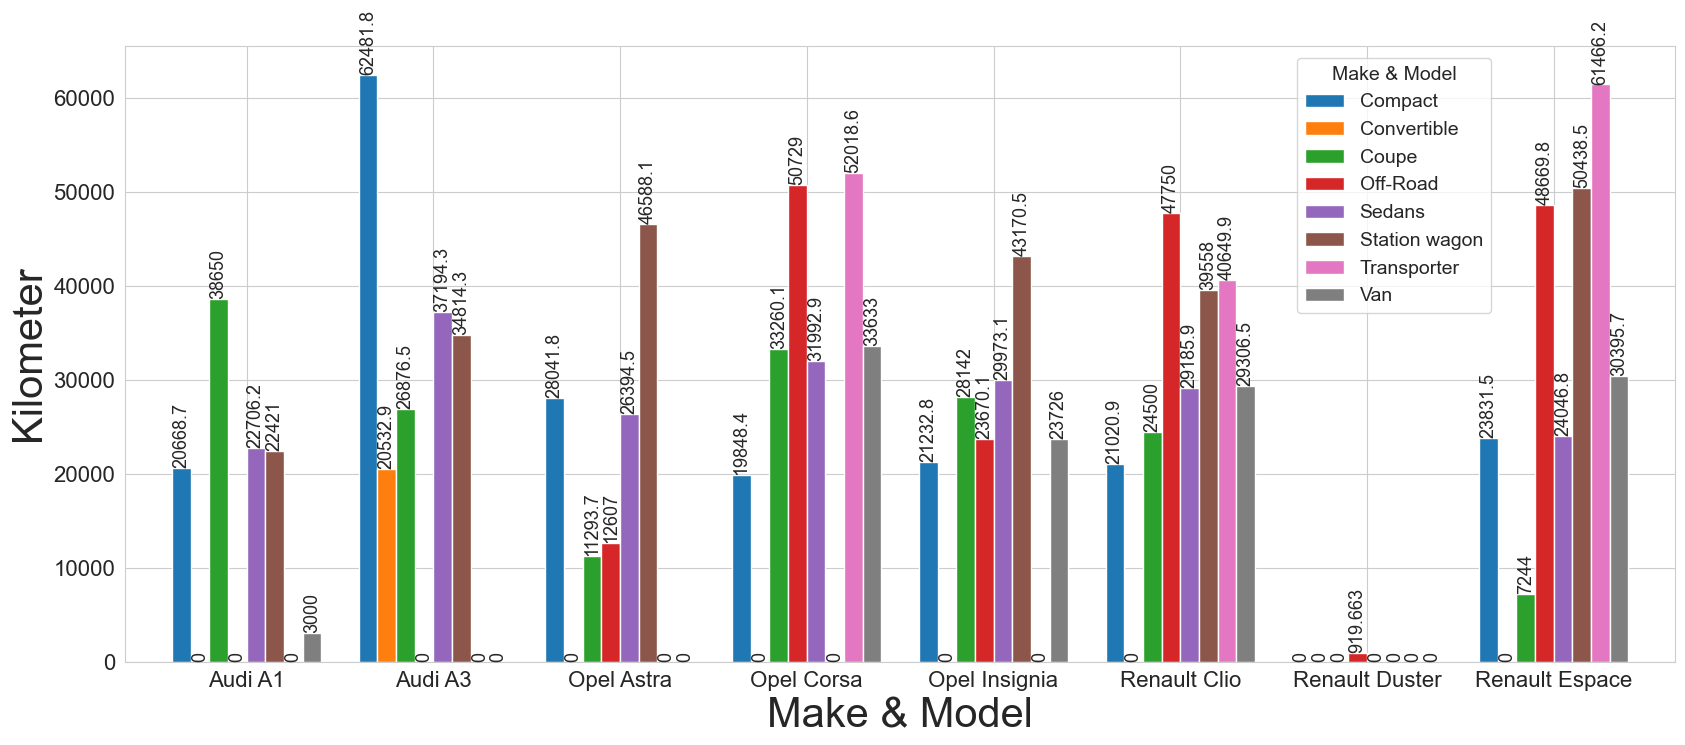

In [ ]:
ax = avg_km.unstack(level=1).plot.bar(figsize=(20, 8), fontsize=16, width=0.8, rot=0)

for container in ax.containers:
    ax.bar_label(container, fontsize=13, rotation=90)
    
ax.set_xlabel('Make & Model', fontsize=30)
ax.set_ylabel('Kilometer', fontsize=30)
plt.legend(title="Make & Model", title_fontsize=14, prop={'size': 14}, bbox_to_anchor=(0.75, 0.55));

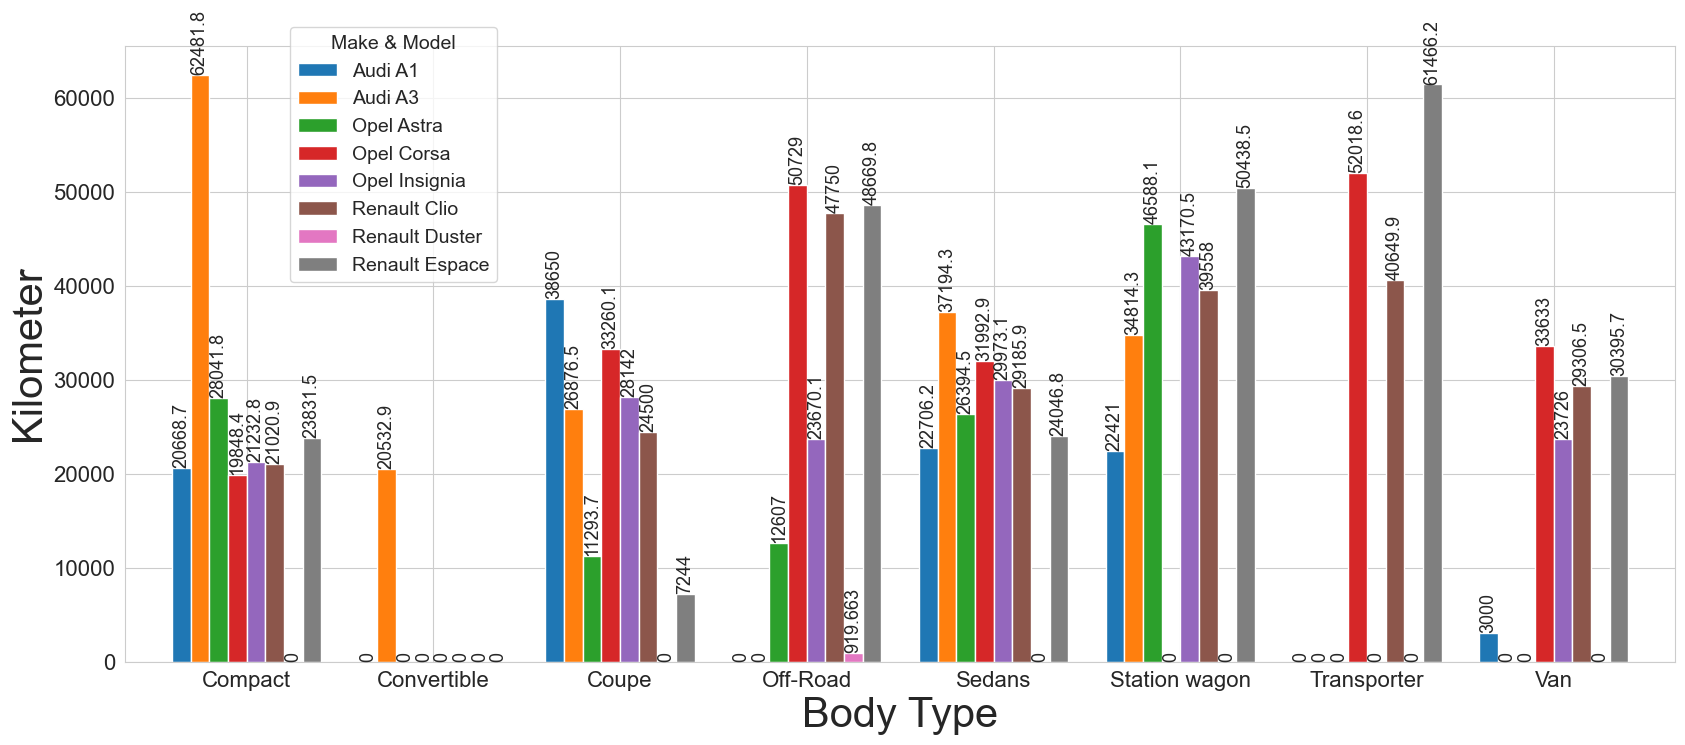

In [ ]:
ax = avg_km.unstack(level=0).plot.bar(figsize=(20, 8), fontsize=16, width=0.8, rot=0)

for container in ax.containers:
    ax.bar_label(container, fontsize=13, rotation=90)
    
ax.set_xlabel('Body Type', fontsize=30)
ax.set_ylabel('Kilometer', fontsize=30)
plt.legend(title="Make & Model", title_fontsize=14, prop={'size': 14}, bbox_to_anchor=(0.1, 0.6));

### 2. What is the average price of the vehicles according to the gear types they use?

In [ ]:
avg_price1 = df.groupby(["make_model", "Gearing_Type"]).price.mean()
avg_price1

make_model      Gearing_Type  
Audi A1         Automatic        21451.658
                Manual           16659.505
                Semi-automatic   20936.526
Audi A3         Automatic        21490.719
                Manual           19433.989
                Semi-automatic   27180.000
Opel Astra      Automatic        18843.303
                Manual           13516.257
                Semi-automatic   16132.722
Opel Corsa      Automatic        14051.363
                Manual            9021.493
                Semi-automatic   11930.000
Opel Insignia   Automatic        23114.156
                Manual           19747.963
Renault Clio    Automatic        16238.258
                Manual            9502.069
                Semi-automatic   16507.756
Renault Duster  Automatic        14641.500
                Manual           12795.923
Renault Espace  Automatic        30904.995
                Manual           23691.402
                Semi-automatic   25114.077
Name: price, dtype: flo

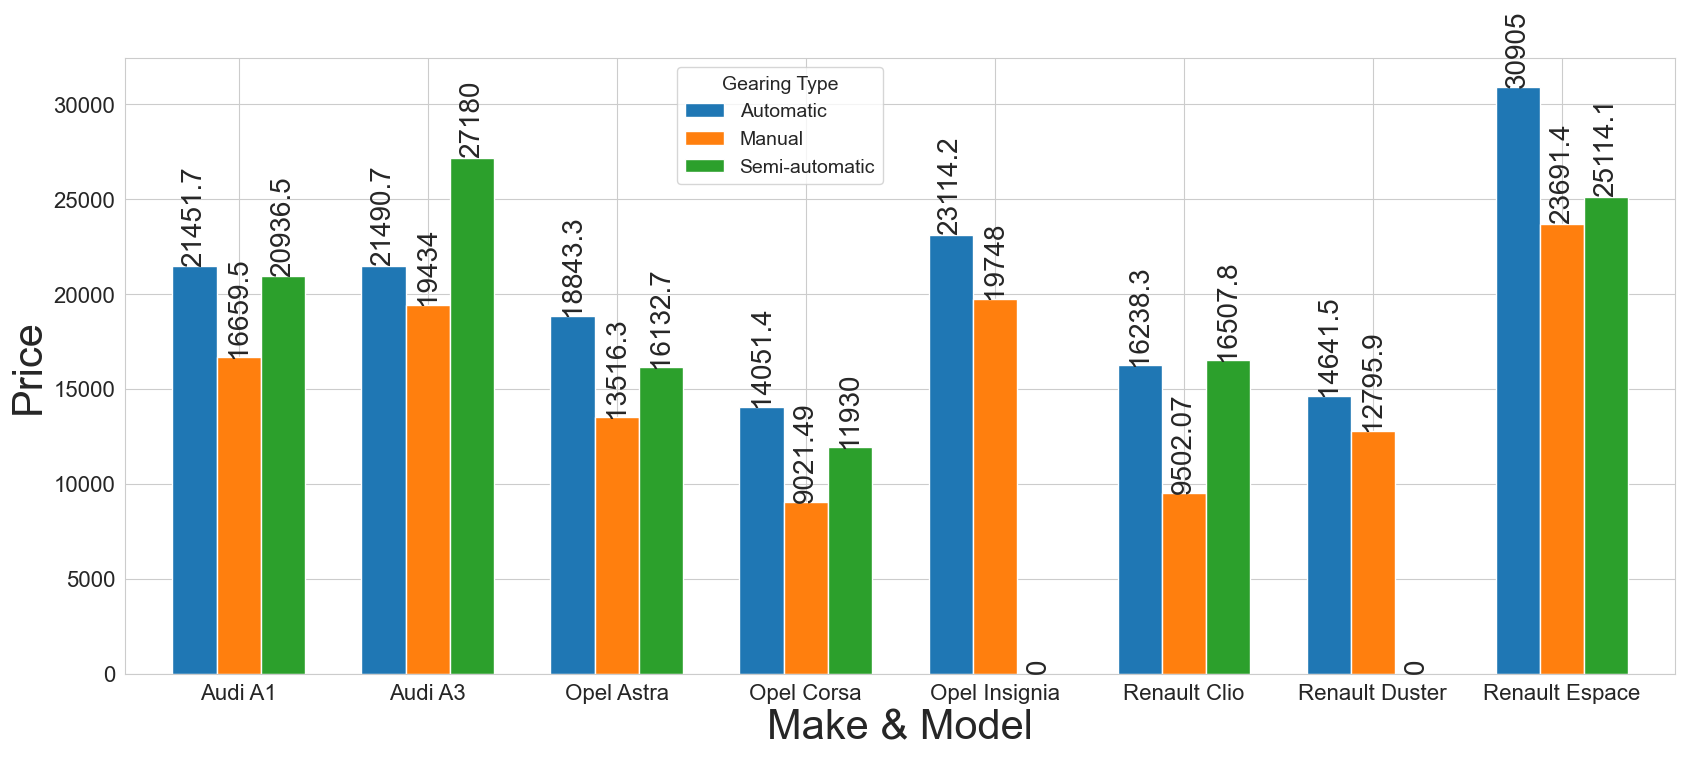

In [ ]:
ax = avg_price1.unstack(level=1).plot.bar(figsize=(20, 8), fontsize=16, width=0.7, rot=0)

for container in ax.containers:
    ax.bar_label(container, fontsize=20, rotation=90)
    
ax.set_xlabel('Make & Model', fontsize=30)
ax.set_ylabel('Price', fontsize=30)
plt.legend(title="Gearing Type", title_fontsize=14, prop={'size': 14}, bbox_to_anchor=(0.35, 1));

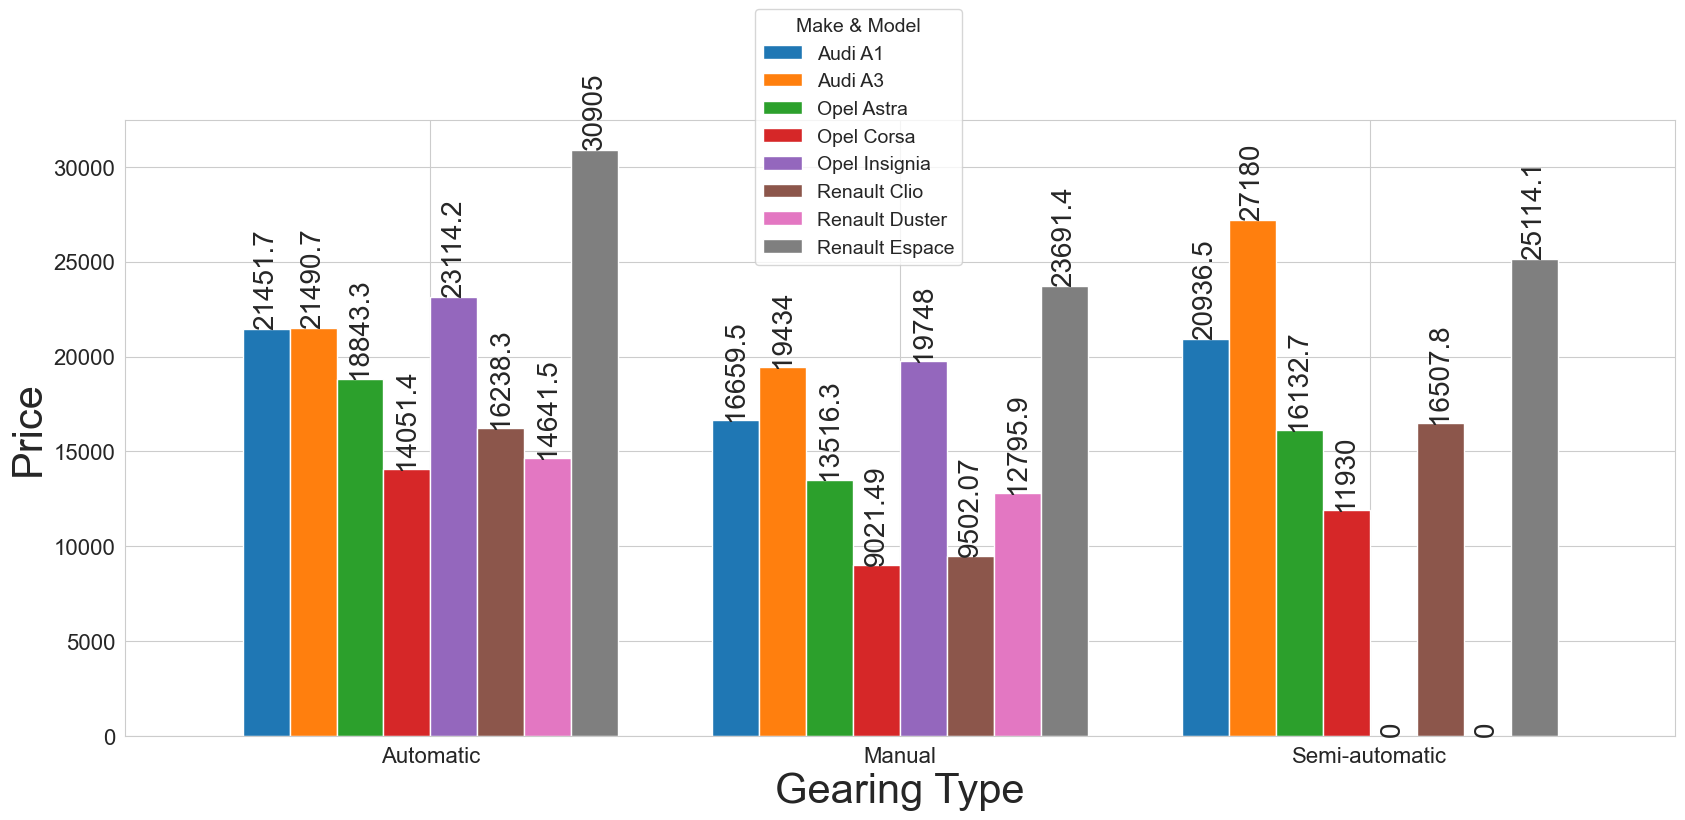

In [ ]:
ax = avg_price1.unstack(level=0).plot.bar(figsize=(20, 8), fontsize=16, width=0.8, rot=0)

for container in ax.containers:
    ax.bar_label(container, fontsize=20, rotation=90)
    
ax.set_xlabel('Gearing Type', fontsize=30)
ax.set_ylabel('Price', fontsize=30)
plt.legend(title="Make & Model", title_fontsize=14, prop={'size': 14}, bbox_to_anchor=(0.4, 0.75));

### 3. What is the average price of the vehicles according to the fuel types they use?

In [ ]:
avg_price2 = df.groupby(["make_model", "Fuel"]).price.mean()
avg_price2

make_model      Fuel   
Audi A1         Benzine   20037.974
                Diesel    16135.981
Audi A3         Benzine   22916.431
                Diesel    20110.062
                LPG/CNG   21684.083
Opel Astra      Benzine   17816.946
                Diesel    13435.740
                LPG/CNG   15882.000
Opel Corsa      Benzine   11313.743
                Diesel     7796.086
                LPG/CNG    9503.769
Opel Insignia   Benzine   24890.695
                Diesel    19698.871
Renault Clio    Benzine   13034.561
                Diesel    10120.655
                LPG/CNG    8545.385
Renault Duster  Benzine   13230.176
Renault Espace  Benzine   34814.026
                Diesel    28280.308
Name: price, dtype: float64

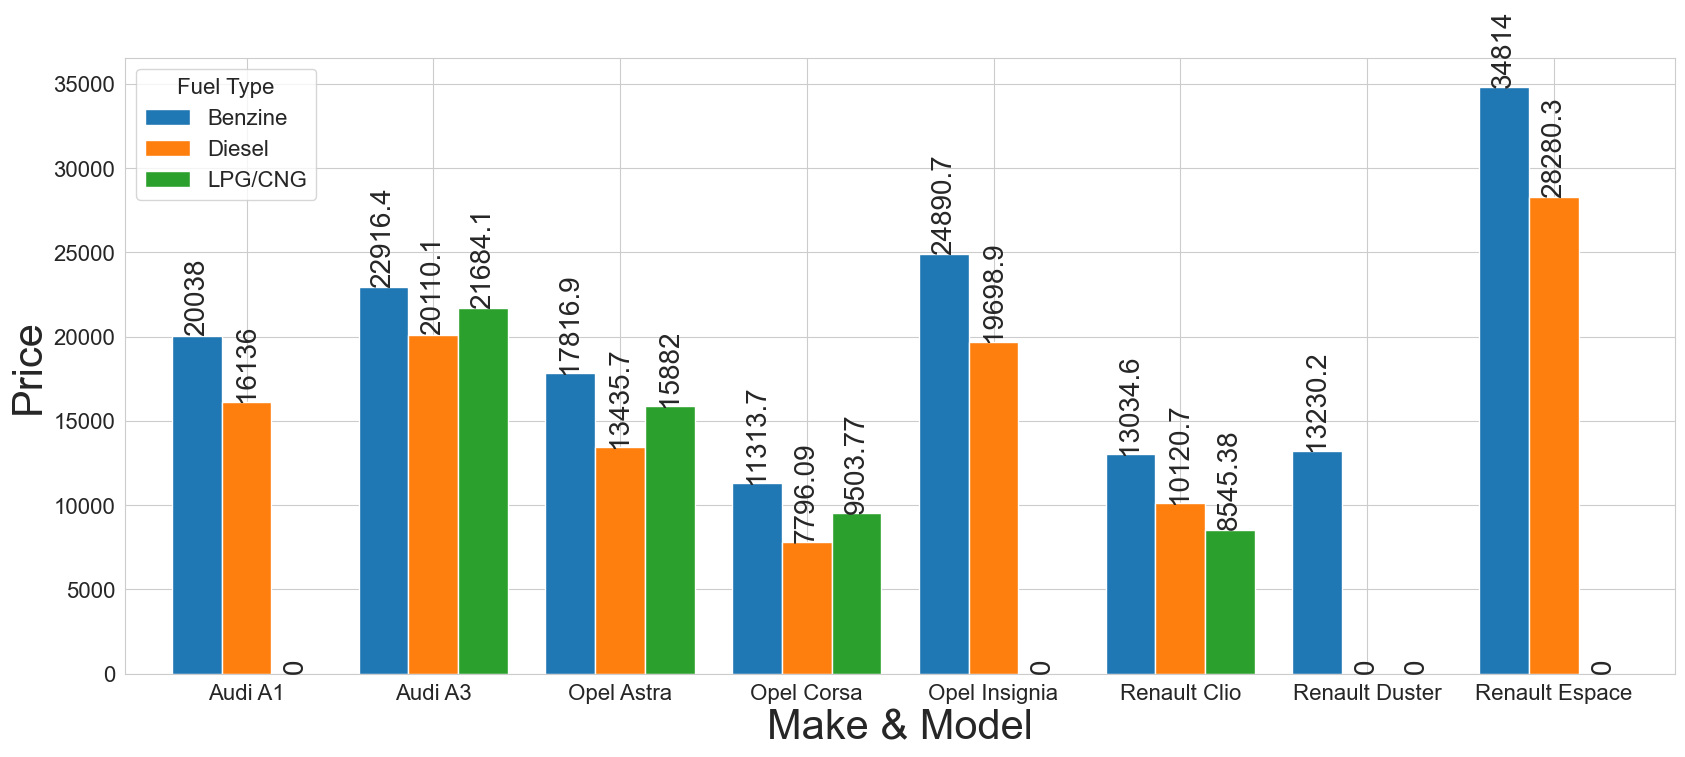

In [ ]:
ax = avg_price2.unstack(level=1).plot.bar(figsize=(20, 8), fontsize=16, width=0.8, rot=0)

for container in ax.containers:
    ax.bar_label(container, fontsize=20, rotation=90)
    
ax.set_xlabel('Make & Model', fontsize=30)
ax.set_ylabel('Price', fontsize=30)
plt.legend(title="Fuel Type", title_fontsize=16, prop={'size': 16}, loc='best');

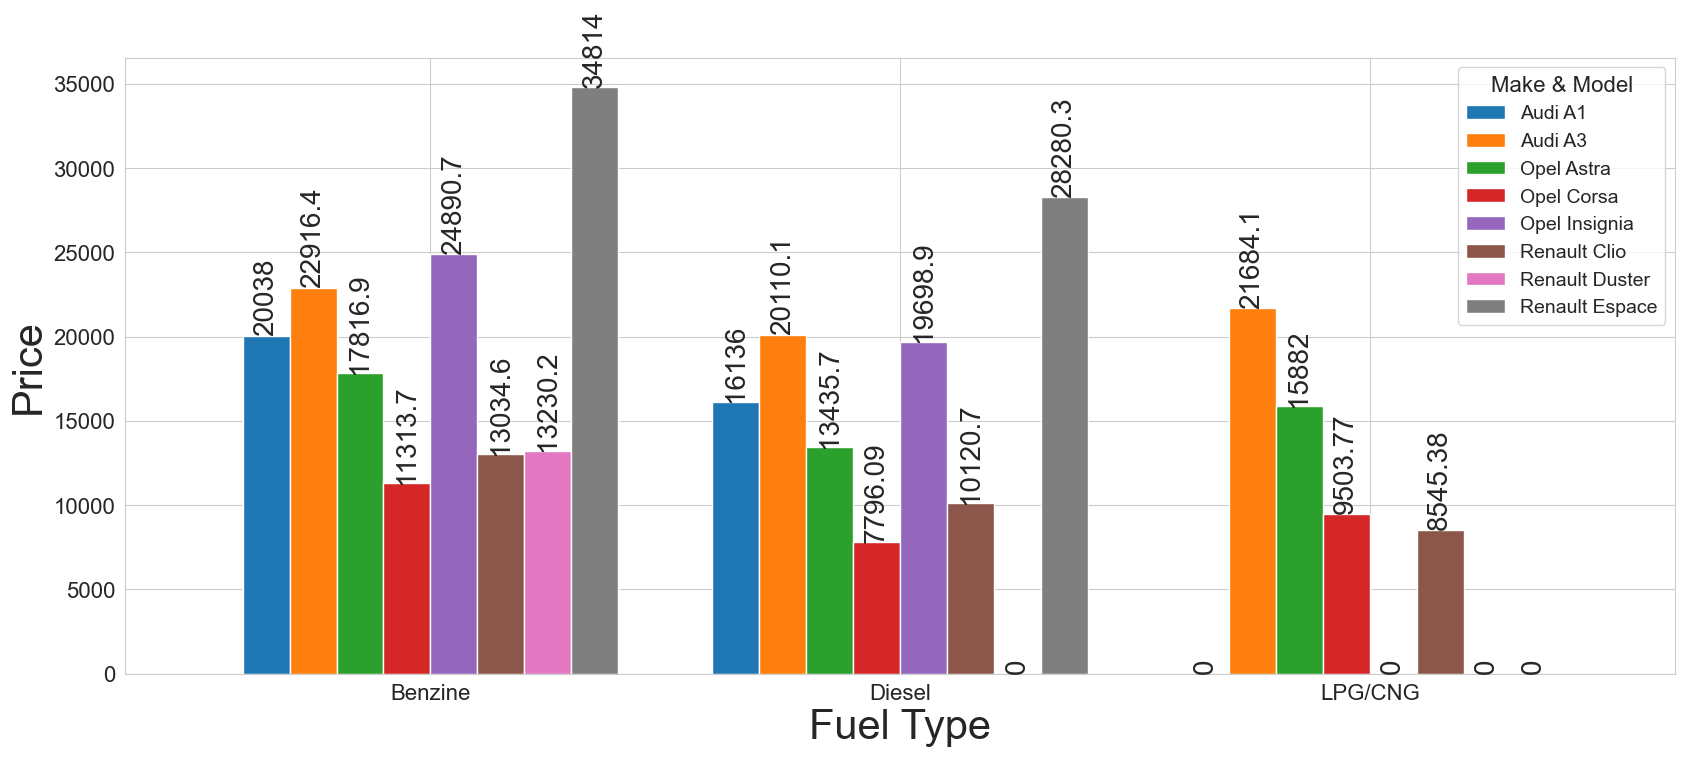

In [ ]:
ax = avg_price2.unstack(level=0).plot.bar(figsize=(20, 8), fontsize=16, width=0.8, rot=0)

for container in ax.containers:
    ax.bar_label(container, fontsize=20, rotation=90)
    
ax.set_xlabel('Fuel Type', fontsize=30)
ax.set_ylabel('Price', fontsize=30)
plt.legend(title="Make & Model", title_fontsize=16, prop={'size': 14}, loc='best');

### 4. Which make & model has the highest number of vehicles for sale?

In [ ]:
df["make_model"].value_counts().nlargest(1)

Audi A3    3093
Name: make_model, dtype: int64

In [ ]:
num_sale = df["make_model"].value_counts()
num_sale

Audi A3           3093
Audi A1           2614
Opel Insignia     2598
Opel Astra        2525
Opel Corsa        2216
Renault Clio      1838
Renault Espace     991
Renault Duster      34
Name: make_model, dtype: int64

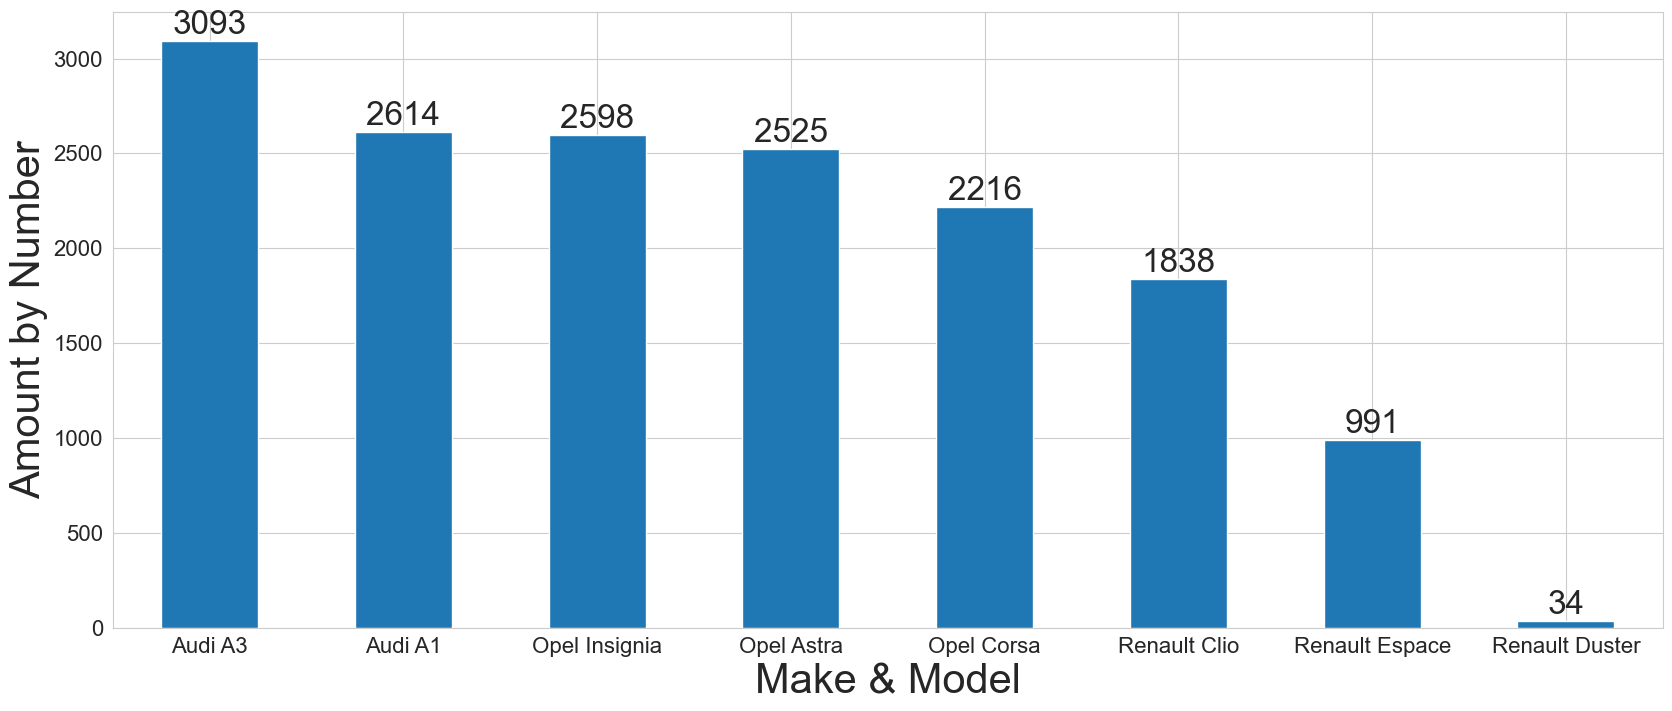

In [ ]:
ax = num_sale.plot.bar(figsize=(20, 8), fontsize=16, rot=0)

for container in ax.containers:
    ax.bar_label(container, fontsize=24)
    
ax.set_xlabel('Make & Model', fontsize=30)
ax.set_ylabel('Amount by Number', fontsize=30);

### 5. Which vehicle make & models has the lowest fuel consumption by body type and What are their fuel types?

In [ ]:
cons = df.groupby(["make_model", "body_type", "Fuel"]).cons_comb.min()
cons

make_model      body_type      Fuel   
Audi A1         Compact        Benzine   4.000
                               Diesel    3.000
                Coupe          Benzine   4.200
                               Diesel    4.200
                Sedans         Benzine   3.900
                               Diesel    3.000
                Station wagon  Benzine   4.200
                               Diesel    3.400
                Van            Benzine   4.400
Audi A3         Compact        Benzine   4.500
                               Diesel    3.000
                Convertible    Benzine   4.900
                               Diesel    3.800
                Coupe          Benzine   4.600
                               Diesel    3.800
                Sedans         Benzine   3.500
                               Diesel    3.000
                               LPG/CNG   3.300
                Station wagon  Benzine   4.400
                               Diesel    3.300
                     

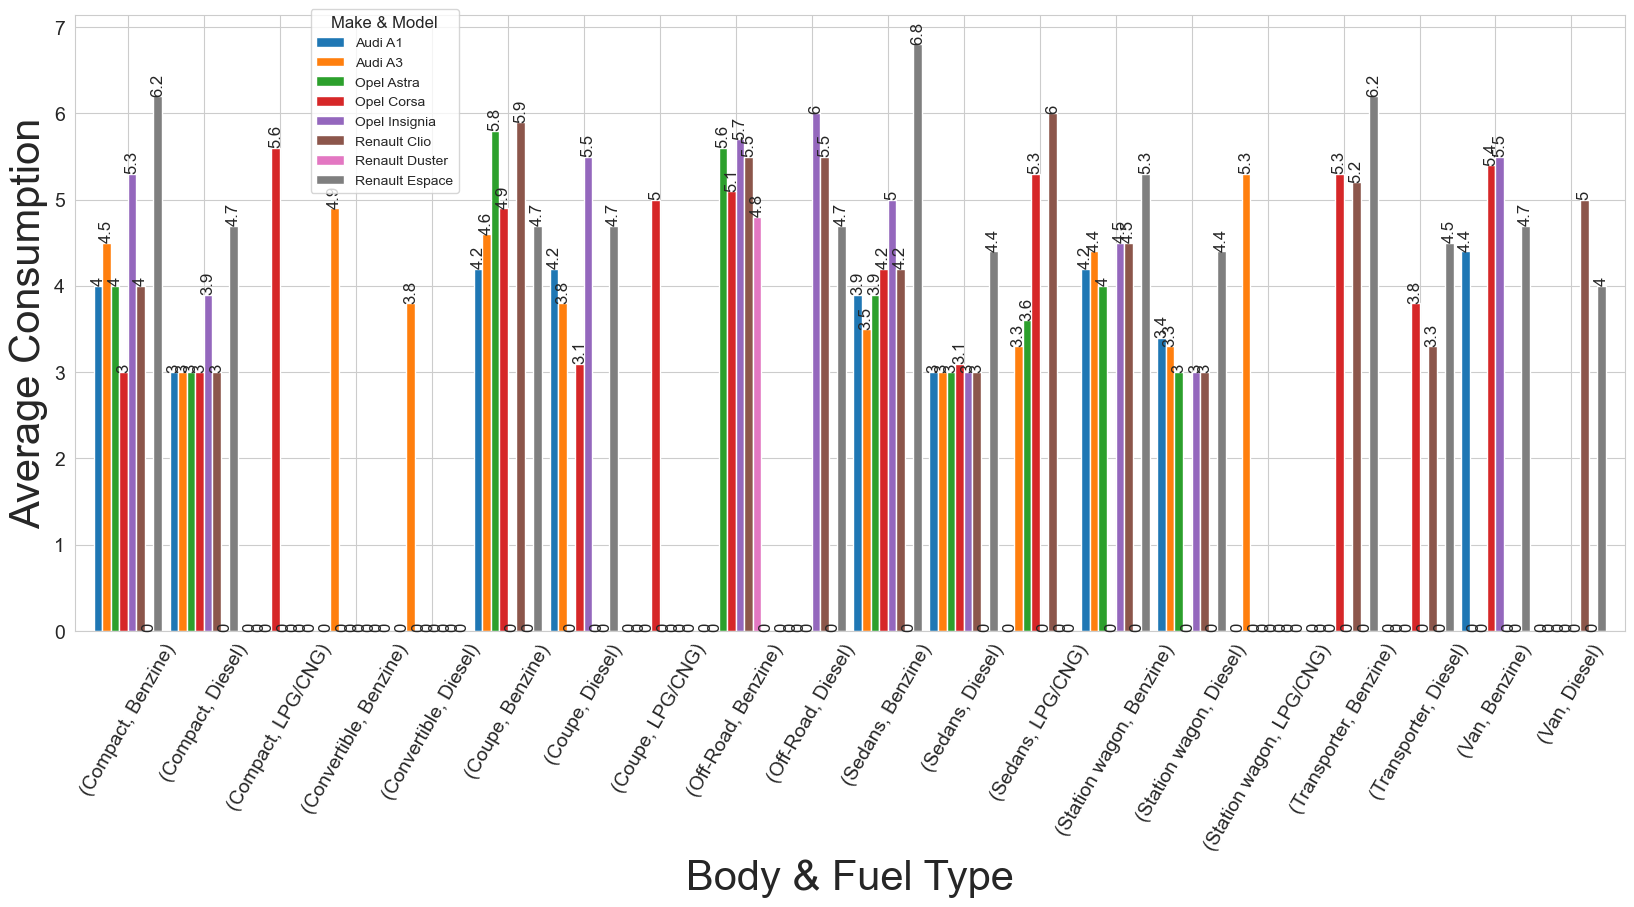

In [ ]:
ax = cons.unstack(level=0).plot.bar(figsize=(20, 8), fontsize=14, width=0.9, rot=60)

for container in ax.containers:
    ax.bar_label(container, fontsize=12, rotation=90)
    
ax.set_xlabel('Body & Fuel Type', fontsize=30)
ax.set_ylabel('Average Consumption', fontsize=30)
plt.legend(title="Make & Model", title_fontsize=12, prop={'size': 10}, bbox_to_anchor=(0.2, 0.7));

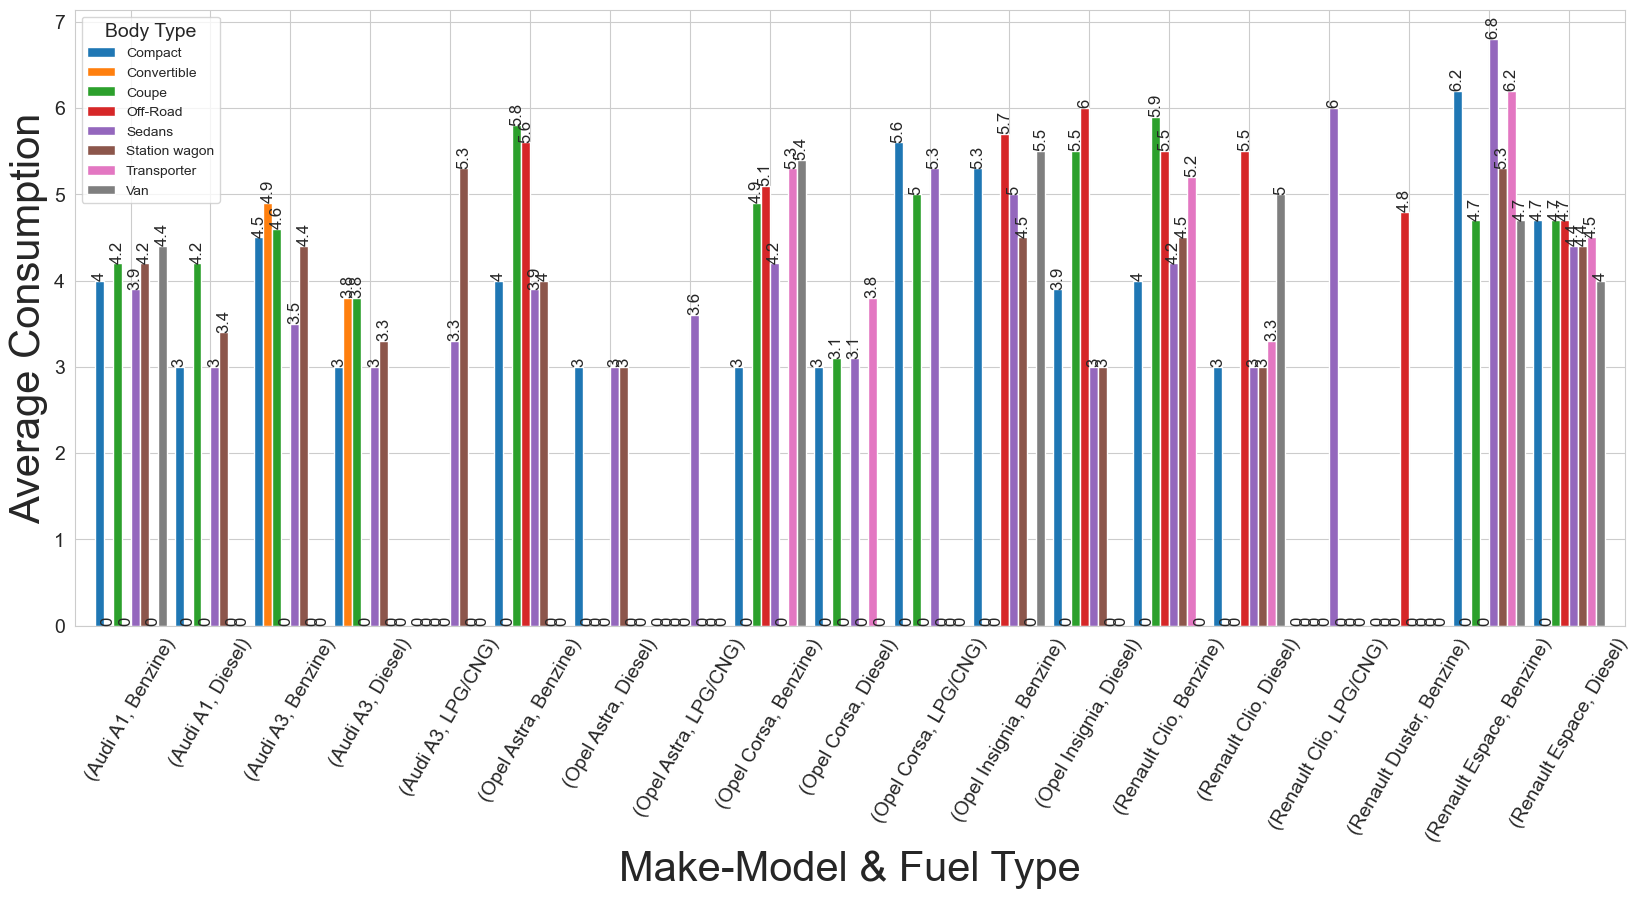

In [ ]:
ax = cons.unstack(level=1).plot.bar(figsize=(20, 8), fontsize=14, width=0.9, rot=60)

for container in ax.containers:
    ax.bar_label(container, fontsize=12, rotation=90)
    
ax.set_xlabel('Make-Model & Fuel Type', fontsize=30)
ax.set_ylabel('Average Consumption', fontsize=30)
plt.legend(title="Body Type", title_fontsize=14, prop={'size': 10});

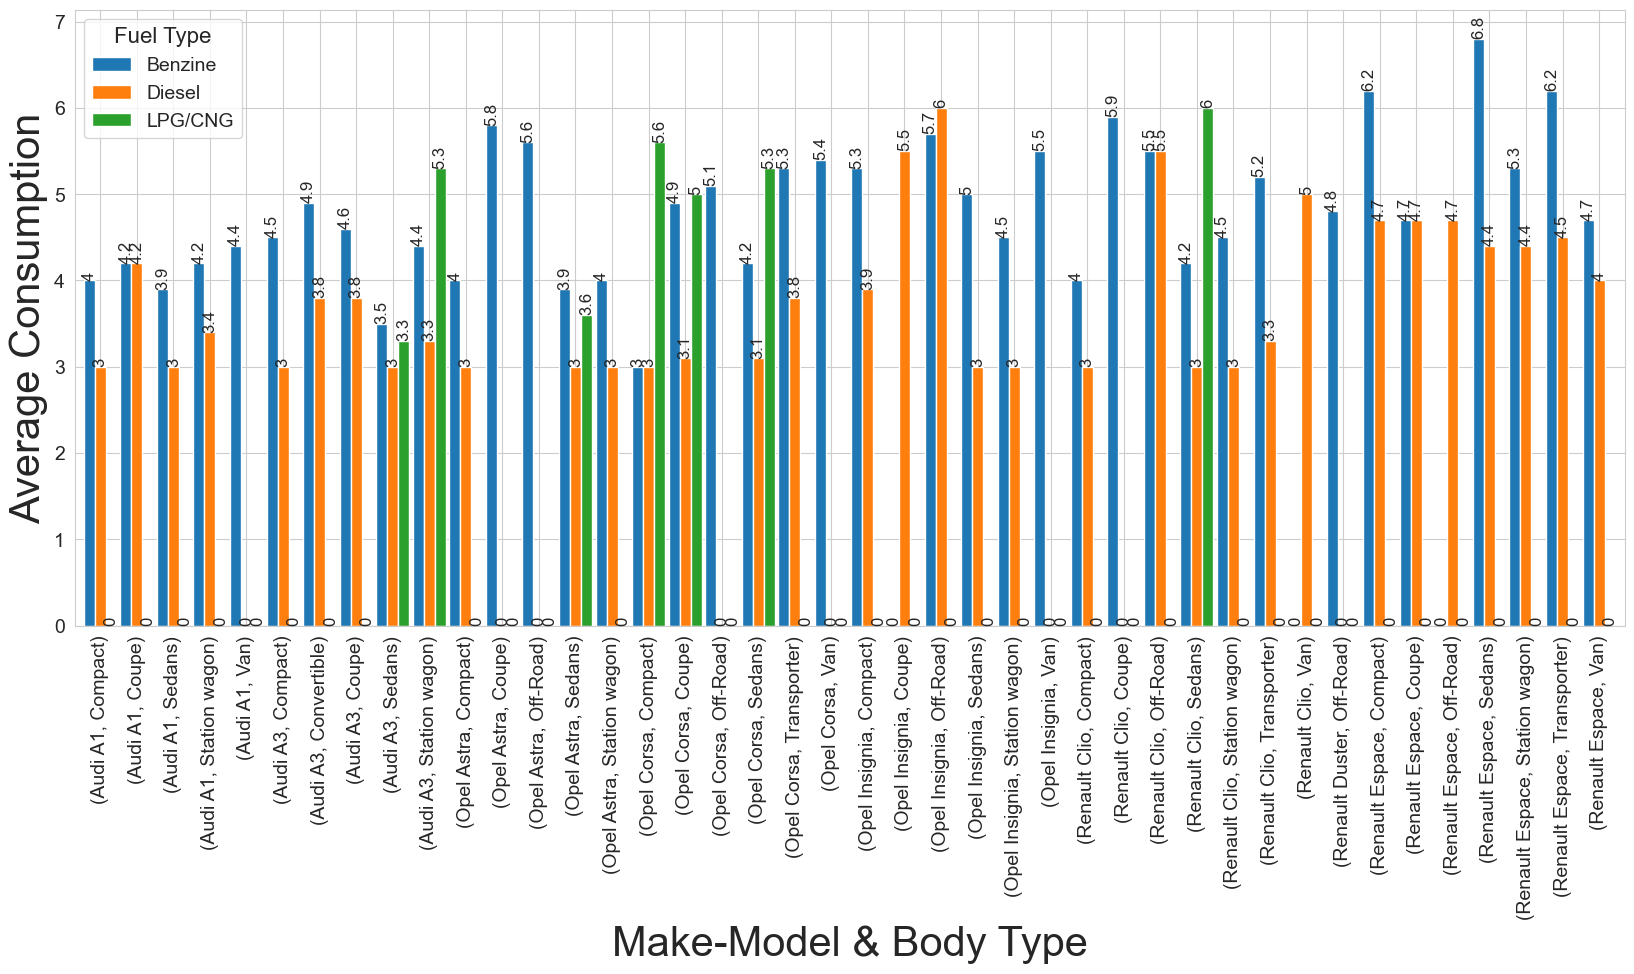

In [ ]:
ax = cons.unstack(level=2).plot.bar(figsize=(20, 8), fontsize=14, width=0.9, rot=90)

for container in ax.containers:
    ax.bar_label(container, fontsize=12, rotation=90)
    
ax.set_xlabel('Make-Model & Body Type', fontsize=30)
ax.set_ylabel('Average Consumption', fontsize=30)
plt.legend(title="Fuel Type", title_fontsize=16, prop={'size': 14});

### 6. What are the lowest and highest sales prices of the vehicles according to the make & model? And find the selling price difference for each make & model group. Which vehicle group has the biggest price difference?

In [ ]:
df.groupby(["make_model"]).price.min()

make_model
Audi A1            8999
Audi A3            5555
Opel Astra         6000
Opel Corsa         4950
Opel Insignia      8290
Renault Clio       5445
Renault Duster    10850
Renault Espace    12614
Name: price, dtype: int64

In [ ]:
df.groupby(["make_model"]).price.max()

make_model
Audi A1           37900
Audi A3           74600
Opel Astra        39433
Opel Corsa        18622
Opel Insignia     52120
Renault Clio      31500
Renault Duster    16033
Renault Espace    68320
Name: price, dtype: int64

In [ ]:
min_max_price = df.groupby(["make_model"]).agg({'price': ['max', 'min']}).reset_index()
min_max_price

make_model  price       
                     max    min
0         Audi A1  37900   8999
1         Audi A3  74600   5555
2      Opel Astra  39433   6000
3      Opel Corsa  18622   4950
4   Opel Insignia  52120   8290
5    Renault Clio  31500   5445
6  Renault Duster  16033  10850
7  Renault Espace  68320  12614

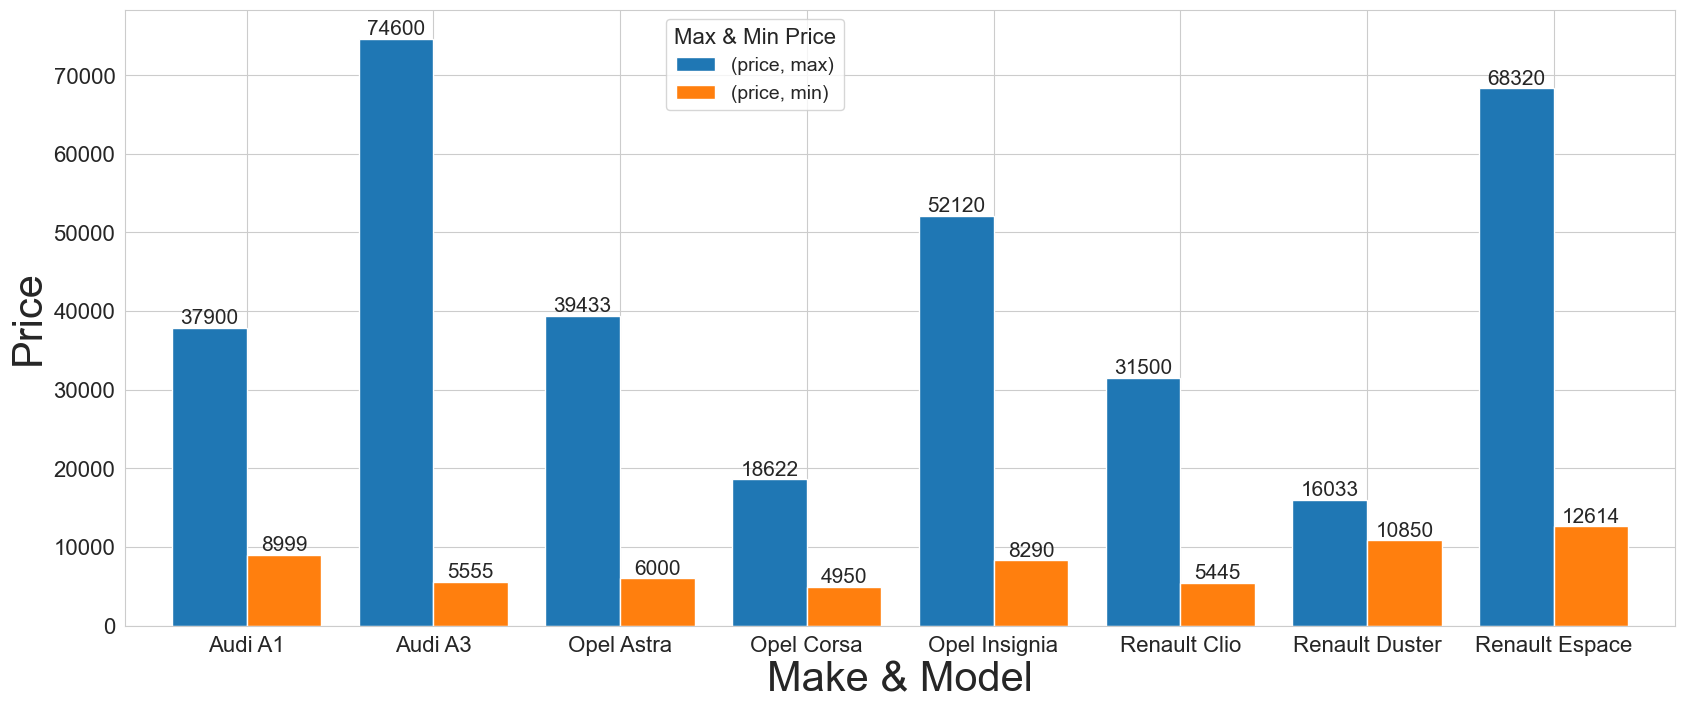

In [ ]:
ax = min_max_price.plot.bar(figsize=(20, 8), fontsize=16, width=0.8, rot=0)

for container in ax.containers:
    ax.bar_label(container, fontsize=15)
    
ax.set_xticklabels(min_max_price.make_model)
ax.set_xlabel('Make & Model', fontsize=30)
ax.set_ylabel('Price', fontsize=30)
plt.legend(title="Max & Min Price", title_fontsize=16, prop={'size': 14}, bbox_to_anchor=(0.47, 1));

**Let us also see the Price differences for each Make & Model in the plot.**

In [ ]:
min_max_price.columns

MultiIndex([('make_model',    ''),
            (     'price', 'max'),
            (     'price', 'min')],
           )

In [ ]:
min_max_price['price', 'difference'] = min_max_price['price', 'max'] - min_max_price['price', 'min']
min_max_price.sort_values(by=('price', 'difference'), ascending=False)

make_model  price                  
                     max    min difference
1         Audi A3  74600   5555      69045
7  Renault Espace  68320  12614      55706
4   Opel Insignia  52120   8290      43830
2      Opel Astra  39433   6000      33433
0         Audi A1  37900   8999      28901
5    Renault Clio  31500   5445      26055
3      Opel Corsa  18622   4950      13672
6  Renault Duster  16033  10850       5183

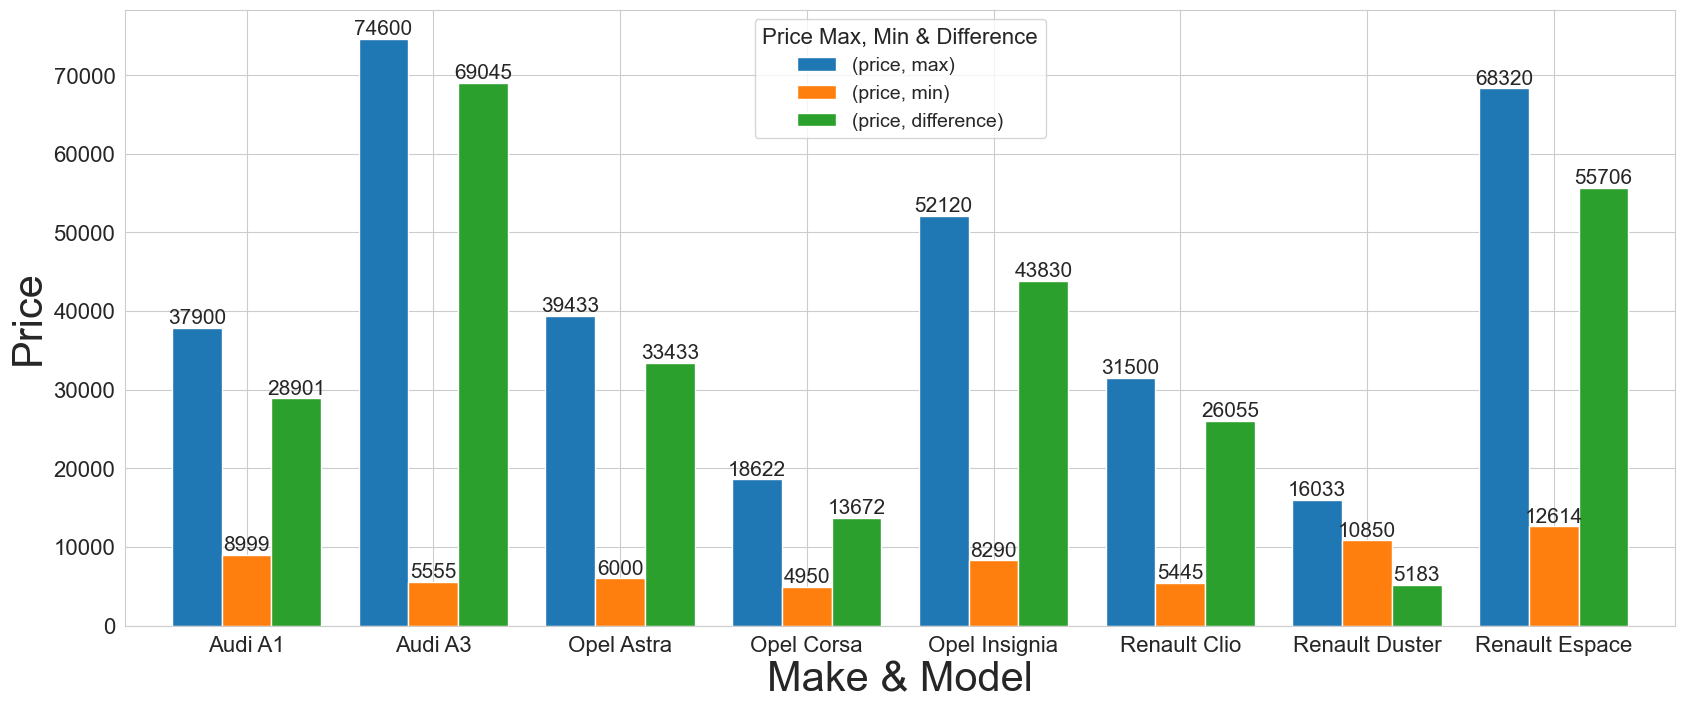

In [ ]:
ax = min_max_price.plot.bar(figsize=(20, 8), fontsize=16, width=0.8, rot=0)

for container in ax.containers:
    ax.bar_label(container, fontsize=15)
    
ax.set_xticklabels(min_max_price.make_model)
ax.set_xlabel('Make & Model', fontsize=30)
ax.set_ylabel('Price', fontsize=30)
plt.legend(title="Price Max, Min & Difference", title_fontsize=16, prop={'size': 14});

### 7. What is the average selling price of vehicles whose make & model is Opel Corsa and body is sedan?

In [ ]:
df[(df["make_model"] == "Opel Corsa") & (df["body_type"] == "Sedans")].price.mean()

10217.443935926773

### 8. What are the average, minimum and maximum selling prices of vehicles by body type?

In [ ]:
df.groupby(['make_model', 'body_type']).agg({'price': ['mean', 'min', 'max']})

price              
                                  mean    min    max
make_model     body_type                            
Audi A1        Compact       19189.373   9950  31990
               Coupe         14925.000  13950  15900
               Sedans        18659.993   8999  37900
               Station wagon 17811.381  12950  28999
               Van           29000.000  29000  29000
Audi A3        Compact       18991.735  12900  67600
               Convertible   27905.375  10893  56100
               Coupe         17745.000  16990  19000
               Sedans        21132.447  10550  74600
               Station wagon 20684.355   5555  63900
Opel Astra     Compact       16199.762   8450  39433
               Coupe         22240.000  14490  29990
               Off-Road      18590.000  18590  18590
               Sedans        15963.179   6500  32950
               Station wagon 15676.677   6000  34900
Opel Corsa     Compact       11674.339   4990  18622
               Coupe          8772.308   6900  11100
               Off-Road       8166.667   7900   8700
               Sedans        10217.444   4950  18490
               Transporter    7650.000   5250  10500
               Van            7900.000   7900   7900
Opel Insignia  Compact       28590.074  10350  49884
               Coupe         17094.000  17094  17094
               Off-Road      29451.286  12750  34776
               Sedans        21263.470   8600  49350
               Station wagon 21425.247   8290  52120
               Van           20980.000  20980  20980
Renault Clio   Compact       12649.634   5800  29740
               Coupe         17990.000  17990  17990
               Off-Road      12845.000   7700  17990
               Sedans        11971.913   5445  31500
               Station wagon 11126.861   5900  20800
               Transporter    8490.172   5900  10798
               Van            9650.000   9400   9900
Renault Duster Off-Road      13230.176  10850  16033
Renault Espace Compact       30046.667  17900  43000
               Coupe         30567.000  26994  34140
               Off-Road      25762.500  14900  32900
               Sedans        30052.429  18999  48498
               Station wagon 27314.659  16900  52990
               Transporter   22606.481  14999  32700
               Van           30912.089  12614  68320

### 9. What is the brand of the vehicles whose sales price is between 5000 and 10000 Euros (exclusive)?

In [ ]:
df[(df.price > 5000) & (df.price < 6000)]["make_model"].unique()

array(['Audi A3', 'Opel Corsa', 'Renault Clio'], dtype=object)

### 10. What is the most common paint type among the vehicles for sale whose make & model is Audi A3 and body is Sedan?

In [ ]:
df[(df["make_model"] == "Audi A3") & (df["body_type"] == "Sedans")].Paint_Type.mode()

0    Metallic
Name: Paint_Type, dtype: object

## 🔥 🧐 Special Remaks on Dummy Operation (Encoding) Before Going Further 🧐 🔥

At this point, you can save your cleaned dataset and, as we did above, use it for other simple analyses where you might be able to apply ``pd.get_dummies()`` method as well, which is a bit more convenient. Although most of the Data Analysts prefer applying ``pd.get_dummies`` for the modelling algoritms before continuing to Machine Leraning; however, for Machine Learning, you almost definitely want to use ``sklearn.OneHotEncoder`` **due to some concerns explained below**. 


**What is Encoding in Data Analytics?**

Encoding categorical data is a process (the transformation of categorical variables) of converting categorical data into integer format (binary or numerical counterparts). In this part of our notebook, we will discuss categorical data encoding and we will try to understand why we need the process of categorical data encoding. The following are the some of approaches/methods that we will discuss in our study. 

🧐 **[A Complete Guide to Categorical Data Encoding](https://analyticsindiamag.com/a-complete-guide-to-categorical-data-encoding/)**

In [ ]:
df.to_csv("final_scout_not_dummy.csv", index=False)

In [ ]:
df = pd.read_csv("final_scout_not_dummy.csv")
df.head()

make_model body_type  price        km  Type     Fuel  \
0    Audi A1    Sedans  15770 56013.000  Used   Diesel   
1    Audi A1    Sedans  14500 80000.000  Used  Benzine   
2    Audi A1    Sedans  14640 83450.000  Used   Diesel   
3    Audi A1    Sedans  14500 73000.000  Used   Diesel   
4    Audi A1    Sedans  16790 16200.000  Used   Diesel   

                                              Extras  Gears   age  \
0   Alloy wheels, Catalytic Converter, Voice Control  7.000 3.000   
1  Alloy wheels, Sport seats, Sport suspension, V...  7.000 2.000   
2                        Alloy wheels, Voice Control  7.000 3.000   
3           Alloy wheels, Sport seats, Voice Control  6.000 3.000   
4  Alloy wheels, Sport package, Sport suspension,...  7.000 3.000   

   Previous_Owners   hp_kW  Inspection_new Paint_Type Upholstery_type  \
0            2.000  66.000               1   Metallic           Cloth   
1            1.000 141.000               0   Metallic           Cloth   
2            1.000  85.000               0   Metallic           Cloth   
3            1.000  66.000               0   Metallic           Cloth   
4            1.000  66.000               1   Metallic           Cloth   

  Gearing_Type  Displacement_cc  Weight_kg Drive_chain  cons_comb  \
0    Automatic         1422.000   1220.000       front      3.800   
1    Automatic         1798.000   1255.000       front      5.600   
2    Automatic         1598.000   1135.000       front      3.800   
3    Automatic         1422.000   1195.000       front      3.800   
4    Automatic         1422.000   1135.000       front      4.100   

   CO2_Emission Comfort_Convenience_Package Entertainment_Media_Package  \
0        99.000                     Premium                        Plus   
1       129.000                    Standard                        Plus   
2        99.000                     Premium                    Standard   
3        99.000                    Standard                        Plus   
4       109.000                     Premium                        Plus   

  Safety_Security_Package  
0  Safety Premium Package  
1  Safety Premium Package  
2  Safety Premium Package  
3  Safety Premium Package  
4  Safety Premium Package

## <p style="background-color:#9d4f8c; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">Dummy Operation</p>

<a id="4"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>

A typical data scientist spends 70 – 80% of his time cleaning and preparing the data. And converting categorical data is an unavoidable activity. It not only elevates the model quality but also helps in better feature engineering. Now the question is, how do we proceed? Which categorical data encoding method should we use? In this part of our study, we will be explaining various types of categorical data encoding methods with implementation in Python.

🧐 **[Here’s All you Need to Know About Encoding Categorical Data (with Python code)](https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/)**

**What is a dummy variable?** 

A dummy variable is a variable that takes values of 0 and 1, where the values indicate the presence or absence of something (e.g., a 0 may indicate a placebo and 1 may indicate a drug). Where a categorical variable has more than two categories, it can be represented by a set of dummy variables, with one variable for each category. Dummy variables are also known as indicator variables, design variables, contrasts, one-hot coding, and binary basis variables. Dummy data is kind a safety mechanism for data integrity.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15909 entries, 0 to 15908
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   make_model                   15909 non-null  object 
 1   body_type                    15909 non-null  object 
 2   price                        15909 non-null  int64  
 3   km                           15909 non-null  float64
 4   Type                         15909 non-null  object 
 5   Fuel                         15909 non-null  object 
 6   Extras                       15909 non-null  object 
 7   Gears                        15909 non-null  float64
 8   age                          15909 non-null  float64
 9   Previous_Owners              15909 non-null  float64
 10  hp_kW                        15909 non-null  float64
 11  Inspection_new               15909 non-null  int64  
 12  Paint_Type                   15909 non-null  object 
 13  Upholstery_type 

In [ ]:
df.shape

(15909, 23)

## Aproach 1: Using factorize() method for some categorical features:

Pandas is the best python module for manipulating dataframes. It has many useful functions. The pandas ``factorize()`` method is one of them. So what does it do? It finds out the uniques values in the array and returns it as a numerical value. This method is useful for obtaining a numeric representation of an array when all that matters is identifying distinct values.

**[Pandas: How to Use factorize() to Encode Strings as Numbers](https://www.statology.org/pandas-factorize/)**<br>
**[Pandas factorize: a fast track from text to numbers](https://towardsdatascience.com/pandas-factorize-a-fast-track-from-text-to-numbers-2a343d91b1f9)**<br>
**[Pandas Factorize Implementation in Python with Examples](https://www.datasciencelearner.com/pandas-factorize-python-examples/)**<br>

**Let us examine how Pandas factorize() method works on our DataFrame:**

In [ ]:
# Encoding the object as an enumerated type or categorical variable.

pd.factorize(df["make_model"])

(array([0, 0, 0, ..., 7, 7, 7], dtype=int64),
 Index(['Audi A1', 'Audi A3', 'Opel Astra', 'Opel Corsa', 'Opel Insignia',
        'Renault Clio', 'Renault Duster', 'Renault Espace'],
       dtype='object'))

In [ ]:
df["make_model"].apply(lambda x: pd.factorize(x))

0                       ([0, 0, 0, 0, 0, 0, 0], [Audi A1])
1                       ([0, 0, 0, 0, 0, 0, 0], [Audi A1])
2                       ([0, 0, 0, 0, 0, 0, 0], [Audi A1])
3                       ([0, 0, 0, 0, 0, 0, 0], [Audi A1])
4                       ([0, 0, 0, 0, 0, 0, 0], [Audi A1])
                               ...                        
15904    ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [...
15905    ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [...
15906    ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [...
15907    ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [...
15908    ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [...
Name: make_model, Length: 15909, dtype: object

In [ ]:
# Encoding all categorical variable (except for "Extras", , "Comfort_Convenience_Package", "Entertainment_Media_Package", "Safety_Security_Package") in our DataFrame.

df[["make_model_ordinal", "body_type_ordinal", "Type_ordinal", "Fuel_ordinal", "Paint_Type_ordinal", "Upholstery_type_ordinal", "Gearing_Type_ordinal"]] = df[["make_model", "body_type", "Type", "Fuel", "Paint_Type", "Upholstery_type", "Gearing_Type"]].apply(lambda x: pd.factorize(x)[0])
df.head()

make_model body_type  price        km  Type     Fuel  \
0    Audi A1    Sedans  15770 56013.000  Used   Diesel   
1    Audi A1    Sedans  14500 80000.000  Used  Benzine   
2    Audi A1    Sedans  14640 83450.000  Used   Diesel   
3    Audi A1    Sedans  14500 73000.000  Used   Diesel   
4    Audi A1    Sedans  16790 16200.000  Used   Diesel   

                                              Extras  Gears   age  \
0   Alloy wheels, Catalytic Converter, Voice Control  7.000 3.000   
1  Alloy wheels, Sport seats, Sport suspension, V...  7.000 2.000   
2                        Alloy wheels, Voice Control  7.000 3.000   
3           Alloy wheels, Sport seats, Voice Control  6.000 3.000   
4  Alloy wheels, Sport package, Sport suspension,...  7.000 3.000   

   Previous_Owners   hp_kW  Inspection_new Paint_Type Upholstery_type  \
0            2.000  66.000               1   Metallic           Cloth   
1            1.000 141.000               0   Metallic           Cloth   
2            1.000  85.000               0   Metallic           Cloth   
3            1.000  66.000               0   Metallic           Cloth   
4            1.000  66.000               1   Metallic           Cloth   

  Gearing_Type  Displacement_cc  Weight_kg Drive_chain  cons_comb  \
0    Automatic         1422.000   1220.000       front      3.800   
1    Automatic         1798.000   1255.000       front      5.600   
2    Automatic         1598.000   1135.000       front      3.800   
3    Automatic         1422.000   1195.000       front      3.800   
4    Automatic         1422.000   1135.000       front      4.100   

   CO2_Emission Comfort_Convenience_Package Entertainment_Media_Package  \
0        99.000                     Premium                        Plus   
1       129.000                    Standard                        Plus   
2        99.000                     Premium                    Standard   
3        99.000                    Standard                        Plus   
4       109.000                     Premium                        Plus   

  Safety_Security_Package  make_model_ordinal  body_type_ordinal  \
0  Safety Premium Package                   0                  0   
1  Safety Premium Package                   0                  0   
2  Safety Premium Package                   0                  0   
3  Safety Premium Package                   0                  0   
4  Safety Premium Package                   0                  0   

   Type_ordinal  Fuel_ordinal  Paint_Type_ordinal  Upholstery_type_ordinal  \
0             0             0                   0                        0   
1             0             1                   0                        0   
2             0             0                   0                        0   
3             0             0                   0                        0   
4             0             0                   0                        0   

   Gearing_Type_ordinal  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [ ]:
make_model_ordinal = df.pop("make_model_ordinal")
df.insert(1, 'make_model_ordinal', make_model_ordinal)
df.head()

make_model  make_model_ordinal body_type  price        km  Type     Fuel  \
0    Audi A1                   0    Sedans  15770 56013.000  Used   Diesel   
1    Audi A1                   0    Sedans  14500 80000.000  Used  Benzine   
2    Audi A1                   0    Sedans  14640 83450.000  Used   Diesel   
3    Audi A1                   0    Sedans  14500 73000.000  Used   Diesel   
4    Audi A1                   0    Sedans  16790 16200.000  Used   Diesel   

                                              Extras  Gears   age  \
0   Alloy wheels, Catalytic Converter, Voice Control  7.000 3.000   
1  Alloy wheels, Sport seats, Sport suspension, V...  7.000 2.000   
2                        Alloy wheels, Voice Control  7.000 3.000   
3           Alloy wheels, Sport seats, Voice Control  6.000 3.000   
4  Alloy wheels, Sport package, Sport suspension,...  7.000 3.000   

   Previous_Owners   hp_kW  Inspection_new Paint_Type Upholstery_type  \
0            2.000  66.000               1   Metallic           Cloth   
1            1.000 141.000               0   Metallic           Cloth   
2            1.000  85.000               0   Metallic           Cloth   
3            1.000  66.000               0   Metallic           Cloth   
4            1.000  66.000               1   Metallic           Cloth   

  Gearing_Type  Displacement_cc  Weight_kg Drive_chain  cons_comb  \
0    Automatic         1422.000   1220.000       front      3.800   
1    Automatic         1798.000   1255.000       front      5.600   
2    Automatic         1598.000   1135.000       front      3.800   
3    Automatic         1422.000   1195.000       front      3.800   
4    Automatic         1422.000   1135.000       front      4.100   

   CO2_Emission Comfort_Convenience_Package Entertainment_Media_Package  \
0        99.000                     Premium                        Plus   
1       129.000                    Standard                        Plus   
2        99.000                     Premium                    Standard   
3        99.000                    Standard                        Plus   
4       109.000                     Premium                        Plus   

  Safety_Security_Package  body_type_ordinal  Type_ordinal  Fuel_ordinal  \
0  Safety Premium Package                  0             0             0   
1  Safety Premium Package                  0             0             1   
2  Safety Premium Package                  0             0             0   
3  Safety Premium Package                  0             0             0   
4  Safety Premium Package                  0             0             0   

   Paint_Type_ordinal  Upholstery_type_ordinal  Gearing_Type_ordinal  
0                   0                        0                     0  
1                   0                        0                     0  
2                   0                        0                     0  
3                   0                        0                     0  
4                   0                        0                     0

**Since this is the first time, let us check how factorize() method made changes on the DataFrame:** 

In [ ]:
df["make_model"].unique()

array(['Audi A1', 'Audi A3', 'Opel Astra', 'Opel Corsa', 'Opel Insignia',
       'Renault Clio', 'Renault Duster', 'Renault Espace'], dtype=object)

In [ ]:
display(df[df["make_model"] == "Audi A1"][["make_model", "make_model_ordinal"]].sample(5))
display(df[df["make_model"] == "Audi A3"][["make_model", "make_model_ordinal"]].sample(5))
display(df[df["make_model"] == "Opel Astra"][["make_model", "make_model_ordinal"]].sample(5))
display(df[df["make_model"] == "Opel Corsa"][["make_model", "make_model_ordinal"]].sample(5))
display(df[df["make_model"] == "Opel Insignia"][["make_model", "make_model_ordinal"]].sample(5))
display(df[df["make_model"] == "Renault Clio"][["make_model", "make_model_ordinal"]].sample(5))
display(df[df["make_model"] == "Renault Duster"][["make_model", "make_model_ordinal"]].sample(5))
display(df[df["make_model"] == "Renault Espace"][["make_model", "make_model_ordinal"]].sample(5))

make_model  make_model_ordinal
1923    Audi A1                   0
218     Audi A1                   0
418     Audi A1                   0
2350    Audi A1                   0
1448    Audi A1                   0

make_model  make_model_ordinal
4886    Audi A3                   1
3383    Audi A3                   1
5437    Audi A3                   1
3208    Audi A3                   1
5700    Audi A3                   1

make_model  make_model_ordinal
6086  Opel Astra                   2
6806  Opel Astra                   2
8182  Opel Astra                   2
6108  Opel Astra                   2
6338  Opel Astra                   2

make_model  make_model_ordinal
8935   Opel Corsa                   3
8540   Opel Corsa                   3
9969   Opel Corsa                   3
10187  Opel Corsa                   3
10283  Opel Corsa                   3

make_model  make_model_ordinal
12659  Opel Insignia                   4
12024  Opel Insignia                   4
12235  Opel Insignia                   4
12907  Opel Insignia                   4
10829  Opel Insignia                   4

make_model  make_model_ordinal
14092  Renault Clio                   5
14226  Renault Clio                   5
14320  Renault Clio                   5
14759  Renault Clio                   5
14131  Renault Clio                   5

make_model  make_model_ordinal
14907  Renault Duster                   6
14900  Renault Duster                   6
14908  Renault Duster                   6
14912  Renault Duster                   6
14909  Renault Duster                   6

make_model  make_model_ordinal
15010  Renault Espace                   7
15190  Renault Espace                   7
14934  Renault Espace                   7
15757  Renault Espace                   7
15361  Renault Espace                   7

**It's time to change the location of all features factorized:**

In [ ]:
df.columns

Index(['make_model', 'make_model_ordinal', 'body_type', 'price', 'km', 'Type',
       'Fuel', 'Extras', 'Gears', 'age', 'Previous_Owners', 'hp_kW',
       'Inspection_new', 'Paint_Type', 'Upholstery_type', 'Gearing_Type',
       'Displacement_cc', 'Weight_kg', 'Drive_chain', 'cons_comb',
       'CO2_Emission', 'Comfort_Convenience_Package',
       'Entertainment_Media_Package', 'Safety_Security_Package',
       'body_type_ordinal', 'Type_ordinal', 'Fuel_ordinal',
       'Paint_Type_ordinal', 'Upholstery_type_ordinal',
       'Gearing_Type_ordinal'],
      dtype='object')

In [ ]:
# list_of_ordinal_features = ["body_type_ordinal", "Type_ordinal", "Fuel_ordinal", "Paint_Type_ordinal", "Upholstery_type_ordinal", "Gearing_Type_ordinal", "Drive_chain_ordinal", "Comfort_Convenience_Package_ordinal", "Entertainment_Media_Package_ordinal", "Safety_Security_Package_ordinal"]

# pop() method works for a single column and returns a Series
body_type_ordinal = df.pop("body_type_ordinal")
Type_ordinal = df.pop("Type_ordinal")
Fuel_ordinal = df.pop("Fuel_ordinal")
Paint_Type_ordinal = df.pop("Paint_Type_ordinal")
Upholstery_type_ordinal = df.pop("Upholstery_type_ordinal")
Gearing_Type_ordinal = df.pop("Gearing_Type_ordinal")
# Drive_chain_ordinal = df.pop("Drive_chain_ordinal")

# Let's insert the columns we have popped
df.insert(3, "body_type_ordinal", body_type_ordinal)
df.insert(7, "Type_ordinal", Type_ordinal)
df.insert( 9, "Fuel_ordinal", Fuel_ordinal)
df.insert(17, "Paint_Type_ordinal", Paint_Type_ordinal)
df.insert(19, "Upholstery_type_ordinal", Upholstery_type_ordinal)
df.insert(21, "Gearing_Type_ordinal", Gearing_Type_ordinal)
# df.insert(25, "Drive_chain_ordinal", Drive_chain_ordinal)

df.head()

make_model  make_model_ordinal body_type  body_type_ordinal  price  \
0    Audi A1                   0    Sedans                  0  15770   
1    Audi A1                   0    Sedans                  0  14500   
2    Audi A1                   0    Sedans                  0  14640   
3    Audi A1                   0    Sedans                  0  14500   
4    Audi A1                   0    Sedans                  0  16790   

         km  Type  Type_ordinal     Fuel  Fuel_ordinal  \
0 56013.000  Used             0   Diesel             0   
1 80000.000  Used             0  Benzine             1   
2 83450.000  Used             0   Diesel             0   
3 73000.000  Used             0   Diesel             0   
4 16200.000  Used             0   Diesel             0   

                                              Extras  Gears   age  \
0   Alloy wheels, Catalytic Converter, Voice Control  7.000 3.000   
1  Alloy wheels, Sport seats, Sport suspension, V...  7.000 2.000   
2                        Alloy wheels, Voice Control  7.000 3.000   
3           Alloy wheels, Sport seats, Voice Control  6.000 3.000   
4  Alloy wheels, Sport package, Sport suspension,...  7.000 3.000   

   Previous_Owners   hp_kW  Inspection_new Paint_Type  Paint_Type_ordinal  \
0            2.000  66.000               1   Metallic                   0   
1            1.000 141.000               0   Metallic                   0   
2            1.000  85.000               0   Metallic                   0   
3            1.000  66.000               0   Metallic                   0   
4            1.000  66.000               1   Metallic                   0   

  Upholstery_type  Upholstery_type_ordinal Gearing_Type  Gearing_Type_ordinal  \
0           Cloth                        0    Automatic                     0   
1           Cloth                        0    Automatic                     0   
2           Cloth                        0    Automatic                     0   
3           Cloth                        0    Automatic                     0   
4           Cloth                        0    Automatic                     0   

   Displacement_cc  Weight_kg Drive_chain  cons_comb  CO2_Emission  \
0         1422.000   1220.000       front      3.800        99.000   
1         1798.000   1255.000       front      5.600       129.000   
2         1598.000   1135.000       front      3.800        99.000   
3         1422.000   1195.000       front      3.800        99.000   
4         1422.000   1135.000       front      4.100       109.000   

  Comfort_Convenience_Package Entertainment_Media_Package  \
0                     Premium                        Plus   
1                    Standard                        Plus   
2                     Premium                    Standard   
3                    Standard                        Plus   
4                     Premium                        Plus   

  Safety_Security_Package  
0  Safety Premium Package  
1  Safety Premium Package  
2  Safety Premium Package  
3  Safety Premium Package  
4  Safety Premium Package

**Let us drop unnecassary features from our DataFrame.**

In [ ]:
df.columns

Index(['make_model', 'make_model_ordinal', 'body_type', 'body_type_ordinal',
       'price', 'km', 'Type', 'Type_ordinal', 'Fuel', 'Fuel_ordinal', 'Extras',
       'Gears', 'age', 'Previous_Owners', 'hp_kW', 'Inspection_new',
       'Paint_Type', 'Paint_Type_ordinal', 'Upholstery_type',
       'Upholstery_type_ordinal', 'Gearing_Type', 'Gearing_Type_ordinal',
       'Displacement_cc', 'Weight_kg', 'Drive_chain', 'cons_comb',
       'CO2_Emission', 'Comfort_Convenience_Package',
       'Entertainment_Media_Package', 'Safety_Security_Package'],
      dtype='object')

In [ ]:
df.drop(['make_model', 'body_type', 'Type', 'Fuel', 'Paint_Type', 'Upholstery_type', 'Gearing_Type'], 
        axis=1, inplace=True)

df.head()

make_model_ordinal  body_type_ordinal  price        km  Type_ordinal  \
0                   0                  0  15770 56013.000             0   
1                   0                  0  14500 80000.000             0   
2                   0                  0  14640 83450.000             0   
3                   0                  0  14500 73000.000             0   
4                   0                  0  16790 16200.000             0   

   Fuel_ordinal                                             Extras  Gears  \
0             0   Alloy wheels, Catalytic Converter, Voice Control  7.000   
1             1  Alloy wheels, Sport seats, Sport suspension, V...  7.000   
2             0                        Alloy wheels, Voice Control  7.000   
3             0           Alloy wheels, Sport seats, Voice Control  6.000   
4             0  Alloy wheels, Sport package, Sport suspension,...  7.000   

    age  Previous_Owners   hp_kW  Inspection_new  Paint_Type_ordinal  \
0 3.000            2.000  66.000               1                   0   
1 2.000            1.000 141.000               0                   0   
2 3.000            1.000  85.000               0                   0   
3 3.000            1.000  66.000               0                   0   
4 3.000            1.000  66.000               1                   0   

   Upholstery_type_ordinal  Gearing_Type_ordinal  Displacement_cc  Weight_kg  \
0                        0                     0         1422.000   1220.000   
1                        0                     0         1798.000   1255.000   
2                        0                     0         1598.000   1135.000   
3                        0                     0         1422.000   1195.000   
4                        0                     0         1422.000   1135.000   

  Drive_chain  cons_comb  CO2_Emission Comfort_Convenience_Package  \
0       front      3.800        99.000                     Premium   
1       front      5.600       129.000                    Standard   
2       front      3.800        99.000                     Premium   
3       front      3.800        99.000                    Standard   
4       front      4.100       109.000                     Premium   

  Entertainment_Media_Package Safety_Security_Package  
0                        Plus  Safety Premium Package  
1                        Plus  Safety Premium Package  
2                    Standard  Safety Premium Package  
3                        Plus  Safety Premium Package  
4                        Plus  Safety Premium Package

In [ ]:
df.dtypes

make_model_ordinal               int64
body_type_ordinal                int64
price                            int64
km                             float64
Type_ordinal                     int64
Fuel_ordinal                     int64
Extras                          object
Gears                          float64
age                            float64
Previous_Owners                float64
hp_kW                          float64
Inspection_new                   int64
Paint_Type_ordinal               int64
Upholstery_type_ordinal          int64
Gearing_Type_ordinal             int64
Displacement_cc                float64
Weight_kg                      float64
Drive_chain                     object
cons_comb                      float64
CO2_Emission                   float64
Comfort_Convenience_Package     object
Entertainment_Media_Package     object
Safety_Security_Package         object
dtype: object

In [ ]:
from termcolor import colored

for column in df.columns:
    print(colored("****"*10, "green"))
    print(colored(f"Column Name: {column}", "blue"))
    print(df[column].value_counts(dropna=False))

****************************************
Column Name: make_model_ordinal
1    3093
0    2614
4    2598
2    2525
3    2216
5    1838
7     991
6      34
Name: make_model_ordinal, dtype: int64
****************************************
Column Name: body_type_ordinal
0    8000
1    3677
2    3239
4     817
7      88
6      55
3      25
5       8
Name: body_type_ordinal, dtype: int64
****************************************
Column Name: price
14990    154
15990    151
10990    139
15900    106
17990    102
        ... 
17559      1
17560      1
17570      1
17575      1
39875      1
Name: price, Length: 2951, dtype: int64
****************************************
Column Name: km
10.000       1044
1647.363      985
1.000         367
5.000         170
50.000        148
             ... 
67469.000       1
43197.000       1
10027.000       1
35882.000       1
57.000          1
Name: km, Length: 6689, dtype: int64
****************************************
Column Name: Type_ordinal
0    11090
2    

## Aproach 2: Using ``count()`` method for "Extras" feature

In [ ]:
df.Extras.str.count(",").add(1)

0        3
1        4
2        2
3        3
4        4
        ..
15904    2
15905    3
15906    1
15907    2
15908    2
Name: Extras, Length: 15909, dtype: int64

In [ ]:
df["Extras"].apply(lambda x: x.count(",")).add(1)

0        3
1        4
2        2
3        3
4        4
        ..
15904    2
15905    3
15906    1
15907    2
15908    2
Name: Extras, Length: 15909, dtype: int64

In [ ]:
df["Num_of_Extras"] = df["Extras"].apply(lambda x: x.count(",")).add(1)
df.head()

make_model_ordinal  body_type_ordinal  price        km  Type_ordinal  \
0                   0                  0  15770 56013.000             0   
1                   0                  0  14500 80000.000             0   
2                   0                  0  14640 83450.000             0   
3                   0                  0  14500 73000.000             0   
4                   0                  0  16790 16200.000             0   

   Fuel_ordinal                                             Extras  Gears  \
0             0   Alloy wheels, Catalytic Converter, Voice Control  7.000   
1             1  Alloy wheels, Sport seats, Sport suspension, V...  7.000   
2             0                        Alloy wheels, Voice Control  7.000   
3             0           Alloy wheels, Sport seats, Voice Control  6.000   
4             0  Alloy wheels, Sport package, Sport suspension,...  7.000   

    age  Previous_Owners   hp_kW  Inspection_new  Paint_Type_ordinal  \
0 3.000            2.000  66.000               1                   0   
1 2.000            1.000 141.000               0                   0   
2 3.000            1.000  85.000               0                   0   
3 3.000            1.000  66.000               0                   0   
4 3.000            1.000  66.000               1                   0   

   Upholstery_type_ordinal  Gearing_Type_ordinal  Displacement_cc  Weight_kg  \
0                        0                     0         1422.000   1220.000   
1                        0                     0         1798.000   1255.000   
2                        0                     0         1598.000   1135.000   
3                        0                     0         1422.000   1195.000   
4                        0                     0         1422.000   1135.000   

  Drive_chain  cons_comb  CO2_Emission Comfort_Convenience_Package  \
0       front      3.800        99.000                     Premium   
1       front      5.600       129.000                    Standard   
2       front      3.800        99.000                     Premium   
3       front      3.800        99.000                    Standard   
4       front      4.100       109.000                     Premium   

  Entertainment_Media_Package Safety_Security_Package  Num_of_Extras  
0                        Plus  Safety Premium Package              3  
1                        Plus  Safety Premium Package              4  
2                    Standard  Safety Premium Package              2  
3                        Plus  Safety Premium Package              3  
4                        Plus  Safety Premium Package              4

In [ ]:
df.drop("Extras", axis=1, inplace=True)
df.head().T

0                       1  \
make_model_ordinal                                0                       0   
body_type_ordinal                                 0                       0   
price                                         15770                   14500   
km                                        56013.000               80000.000   
Type_ordinal                                      0                       0   
Fuel_ordinal                                      0                       1   
Gears                                         7.000                   7.000   
age                                           3.000                   2.000   
Previous_Owners                               2.000                   1.000   
hp_kW                                        66.000                 141.000   
Inspection_new                                    1                       0   
Paint_Type_ordinal                                0                       0   
Upholstery_type_ordinal                           0                       0   
Gearing_Type_ordinal                              0                       0   
Displacement_cc                            1422.000                1798.000   
Weight_kg                                  1220.000                1255.000   
Drive_chain                                   front                   front   
cons_comb                                     3.800                   5.600   
CO2_Emission                                 99.000                 129.000   
Comfort_Convenience_Package                 Premium                Standard   
Entertainment_Media_Package                    Plus                    Plus   
Safety_Security_Package      Safety Premium Package  Safety Premium Package   
Num_of_Extras                                     3                       4   

                                                  2                       3  \
make_model_ordinal                                0                       0   
body_type_ordinal                                 0                       0   
price                                         14640                   14500   
km                                        83450.000               73000.000   
Type_ordinal                                      0                       0   
Fuel_ordinal                                      0                       0   
Gears                                         7.000                   6.000   
age                                           3.000                   3.000   
Previous_Owners                               1.000                   1.000   
hp_kW                                        85.000                  66.000   
Inspection_new                                    0                       0   
Paint_Type_ordinal                                0                       0   
Upholstery_type_ordinal                           0                       0   
Gearing_Type_ordinal                              0                       0   
Displacement_cc                            1598.000                1422.000   
Weight_kg                                  1135.000                1195.000   
Drive_chain                                   front                   front   
cons_comb                                     3.800                   3.800   
CO2_Emission                                 99.000                  99.000   
Comfort_Convenience_Package                 Premium                Standard   
Entertainment_Media_Package                Standard                    Plus   
Safety_Security_Package      Safety Premium Package  Safety Premium Package   
Num_of_Extras                                     2                       3   

                                                  4  
make_model_ordinal                                0  
body_type_ordinal                                 0  
price                                         16790  
km                                      

In [ ]:
df.dtypes

make_model_ordinal               int64
body_type_ordinal                int64
price                            int64
km                             float64
Type_ordinal                     int64
Fuel_ordinal                     int64
Gears                          float64
age                            float64
Previous_Owners                float64
hp_kW                          float64
Inspection_new                   int64
Paint_Type_ordinal               int64
Upholstery_type_ordinal          int64
Gearing_Type_ordinal             int64
Displacement_cc                float64
Weight_kg                      float64
Drive_chain                     object
cons_comb                      float64
CO2_Emission                   float64
Comfort_Convenience_Package     object
Entertainment_Media_Package     object
Safety_Security_Package         object
Num_of_Extras                    int64
dtype: object

## Aproach 3: Using ``map()`` for 'Drive_chain' feature

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15909 entries, 0 to 15908
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   make_model_ordinal           15909 non-null  int64  
 1   body_type_ordinal            15909 non-null  int64  
 2   price                        15909 non-null  int64  
 3   km                           15909 non-null  float64
 4   Type_ordinal                 15909 non-null  int64  
 5   Fuel_ordinal                 15909 non-null  int64  
 6   Gears                        15909 non-null  float64
 7   age                          15909 non-null  float64
 8   Previous_Owners              15909 non-null  float64
 9   hp_kW                        15909 non-null  float64
 10  Inspection_new               15909 non-null  int64  
 11  Paint_Type_ordinal           15909 non-null  int64  
 12  Upholstery_type_ordinal      15909 non-null  int64  
 13  Gearing_Type_ord

In [ ]:
df["Drive_chain"].value_counts()

front    15701
4WD        204
rear         4
Name: Drive_chain, dtype: int64

In [ ]:
df["Drive_chain"] = df["Drive_chain"].map({"rear":0, "4WD":1, "front":2})
df.head()

make_model_ordinal  body_type_ordinal  price        km  Type_ordinal  \
0                   0                  0  15770 56013.000             0   
1                   0                  0  14500 80000.000             0   
2                   0                  0  14640 83450.000             0   
3                   0                  0  14500 73000.000             0   
4                   0                  0  16790 16200.000             0   

   Fuel_ordinal  Gears   age  Previous_Owners   hp_kW  Inspection_new  \
0             0  7.000 3.000            2.000  66.000               1   
1             1  7.000 2.000            1.000 141.000               0   
2             0  7.000 3.000            1.000  85.000               0   
3             0  6.000 3.000            1.000  66.000               0   
4             0  7.000 3.000            1.000  66.000               1   

   Paint_Type_ordinal  Upholstery_type_ordinal  Gearing_Type_ordinal  \
0                   0                        0                     0   
1                   0                        0                     0   
2                   0                        0                     0   
3                   0                        0                     0   
4                   0                        0                     0   

   Displacement_cc  Weight_kg  Drive_chain  cons_comb  CO2_Emission  \
0         1422.000   1220.000            2      3.800        99.000   
1         1798.000   1255.000            2      5.600       129.000   
2         1598.000   1135.000            2      3.800        99.000   
3         1422.000   1195.000            2      3.800        99.000   
4         1422.000   1135.000            2      4.100       109.000   

  Comfort_Convenience_Package Entertainment_Media_Package  \
0                     Premium                        Plus   
1                    Standard                        Plus   
2                     Premium                    Standard   
3                    Standard                        Plus   
4                     Premium                        Plus   

  Safety_Security_Package  Num_of_Extras  
0  Safety Premium Package              3  
1  Safety Premium Package              4  
2  Safety Premium Package              2  
3  Safety Premium Package              3  
4  Safety Premium Package              4

In [ ]:
df.dtypes

make_model_ordinal               int64
body_type_ordinal                int64
price                            int64
km                             float64
Type_ordinal                     int64
Fuel_ordinal                     int64
Gears                          float64
age                            float64
Previous_Owners                float64
hp_kW                          float64
Inspection_new                   int64
Paint_Type_ordinal               int64
Upholstery_type_ordinal          int64
Gearing_Type_ordinal             int64
Displacement_cc                float64
Weight_kg                      float64
Drive_chain                      int64
cons_comb                      float64
CO2_Emission                   float64
Comfort_Convenience_Package     object
Entertainment_Media_Package     object
Safety_Security_Package         object
Num_of_Extras                    int64
dtype: object

## Aproach 4: Using ``cat.codes`` for 'Comfort_Convenience_Package' feature

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15909 entries, 0 to 15908
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   make_model_ordinal           15909 non-null  int64  
 1   body_type_ordinal            15909 non-null  int64  
 2   price                        15909 non-null  int64  
 3   km                           15909 non-null  float64
 4   Type_ordinal                 15909 non-null  int64  
 5   Fuel_ordinal                 15909 non-null  int64  
 6   Gears                        15909 non-null  float64
 7   age                          15909 non-null  float64
 8   Previous_Owners              15909 non-null  float64
 9   hp_kW                        15909 non-null  float64
 10  Inspection_new               15909 non-null  int64  
 11  Paint_Type_ordinal           15909 non-null  int64  
 12  Upholstery_type_ordinal      15909 non-null  int64  
 13  Gearing_Type_ord

In [ ]:
df["Comfort_Convenience_Package"].value_counts()

Standard        10778
Premium          5043
Premium Plus       88
Name: Comfort_Convenience_Package, dtype: int64

In [ ]:
df["Comfort_Convenience_Package"] = df["Comfort_Convenience_Package"].astype("category")
df.dtypes

make_model_ordinal                int64
body_type_ordinal                 int64
price                             int64
km                              float64
Type_ordinal                      int64
Fuel_ordinal                      int64
Gears                           float64
age                             float64
Previous_Owners                 float64
hp_kW                           float64
Inspection_new                    int64
Paint_Type_ordinal                int64
Upholstery_type_ordinal           int64
Gearing_Type_ordinal              int64
Displacement_cc                 float64
Weight_kg                       float64
Drive_chain                       int64
cons_comb                       float64
CO2_Emission                    float64
Comfort_Convenience_Package    category
Entertainment_Media_Package      object
Safety_Security_Package          object
Num_of_Extras                     int64
dtype: object

In [ ]:
# We can access the codes of the categories by running df["Comfort_Convenience_Package"].cat.codes

df["Comfort_Convenience_Package"] = df["Comfort_Convenience_Package"].cat.codes
df.head()

make_model_ordinal  body_type_ordinal  price        km  Type_ordinal  \
0                   0                  0  15770 56013.000             0   
1                   0                  0  14500 80000.000             0   
2                   0                  0  14640 83450.000             0   
3                   0                  0  14500 73000.000             0   
4                   0                  0  16790 16200.000             0   

   Fuel_ordinal  Gears   age  Previous_Owners   hp_kW  Inspection_new  \
0             0  7.000 3.000            2.000  66.000               1   
1             1  7.000 2.000            1.000 141.000               0   
2             0  7.000 3.000            1.000  85.000               0   
3             0  6.000 3.000            1.000  66.000               0   
4             0  7.000 3.000            1.000  66.000               1   

   Paint_Type_ordinal  Upholstery_type_ordinal  Gearing_Type_ordinal  \
0                   0                        0                     0   
1                   0                        0                     0   
2                   0                        0                     0   
3                   0                        0                     0   
4                   0                        0                     0   

   Displacement_cc  Weight_kg  Drive_chain  cons_comb  CO2_Emission  \
0         1422.000   1220.000            2      3.800        99.000   
1         1798.000   1255.000            2      5.600       129.000   
2         1598.000   1135.000            2      3.800        99.000   
3         1422.000   1195.000            2      3.800        99.000   
4         1422.000   1135.000            2      4.100       109.000   

   Comfort_Convenience_Package Entertainment_Media_Package  \
0                            0                        Plus   
1                            2                        Plus   
2                            0                    Standard   
3                            2                        Plus   
4                            0                        Plus   

  Safety_Security_Package  Num_of_Extras  
0  Safety Premium Package              3  
1  Safety Premium Package              4  
2  Safety Premium Package              2  
3  Safety Premium Package              3  
4  Safety Premium Package              4

In [ ]:
df.dtypes

make_model_ordinal               int64
body_type_ordinal                int64
price                            int64
km                             float64
Type_ordinal                     int64
Fuel_ordinal                     int64
Gears                          float64
age                            float64
Previous_Owners                float64
hp_kW                          float64
Inspection_new                   int64
Paint_Type_ordinal               int64
Upholstery_type_ordinal          int64
Gearing_Type_ordinal             int64
Displacement_cc                float64
Weight_kg                      float64
Drive_chain                      int64
cons_comb                      float64
CO2_Emission                   float64
Comfort_Convenience_Package       int8
Entertainment_Media_Package     object
Safety_Security_Package         object
Num_of_Extras                    int64
dtype: object

## Aproach 5: Using ``LabelEncoder()`` method for 'Safety_Security_Package' & 'Entertainment_Media_Package' features

Before going further, it's important to say somthing about label encoding. In label encoding in Python, we replace the categorical value with a numeric value between 0 and the number of classes minus 1. For example, if the categorical variable, such as "Type" in our DataFrame, contains 5 distinct classes that is not very machine-friendly, 0, 1, 2, 3, and 4 are used to identify these classes (sub-categories).

Label Encoding can be performed in 2 ways namely:
- LabelEncoder class using scikit-learn library 
- Category codes (We did it at "Approach 4"

As seen above, it can be noticed that the datatype of ``'Safety_Security_Package'`` & ``'Entertainment_Media_Package'`` features is an object. Now we can proceed with LabelEncoding.

🧐 **[Categorical encoding using Label-Encoding and One-Hot-Encoder](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd)**

In [ ]:
for column in df[["Safety_Security_Package", "Entertainment_Media_Package"]]:
    print(colored("****"*10, "green"))
    print(colored(f"Column Name: {column}", "blue"))
    print(df[column].value_counts(dropna=False))

****************************************
Column Name: Safety_Security_Package
Safety Premium Package         14612
Safety Premium Plus Package      798
Safety Standard Package          499
Name: Safety_Security_Package, dtype: int64
****************************************
Column Name: Entertainment_Media_Package
Plus        10803
Standard     5106
Name: Entertainment_Media_Package, dtype: int64


### Label Encoding using ``sklearn`` Machine Learning library:

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Creating an instance of LabelEncoder() and storing it in labelencoder variable/object
labelencoder = LabelEncoder()

# Applying LabelEncoder for the columns of "Safety_Security_Package" & "Entertainment_Media_Package"
df[["Safety_Security_Package_Labeled", "Entertainment_Media_Package_Labeled"]] = df[["Safety_Security_Package", "Entertainment_Media_Package"]].apply(labelencoder.fit_transform)
df[["Safety_Security_Package", "Safety_Security_Package_Labeled", "Entertainment_Media_Package", "Entertainment_Media_Package_Labeled"]]

Safety_Security_Package  Safety_Security_Package_Labeled  \
0      Safety Premium Package                                0   
1      Safety Premium Package                                0   
2      Safety Premium Package                                0   
3      Safety Premium Package                                0   
4      Safety Premium Package                                0   
...                       ...                              ...   
15904  Safety Premium Package                                0   
15905  Safety Premium Package                                0   
15906  Safety Premium Package                                0   
15907  Safety Premium Package                                0   
15908  Safety Premium Package                                0   

      Entertainment_Media_Package  Entertainment_Media_Package_Labeled  
0                            Plus                                    0  
1                            Plus                                    0  
2                        Standard                                    1  
3                            Plus                                    0  
4                            Plus                                    0  
...                           ...                                  ...  
15904                        Plus                                    0  
15905                        Plus                                    0  
15906                        Plus                                    0  
15907                        Plus                                    0  
15908                    Standard                                    1  

[15909 rows x 4 columns]

In [ ]:
columns = ["Safety_Security_Package", "Safety_Security_Package_Labeled", "Entertainment_Media_Package", "Entertainment_Media_Package_Labeled"]
for column in columns:
    print(colored("****"*13, "green"))
    print(colored(f"Column Name: {column}", "blue"))
    print(df[column].value_counts(dropna=False))

****************************************************
Column Name: Safety_Security_Package
Safety Premium Package         14612
Safety Premium Plus Package      798
Safety Standard Package          499
Name: Safety_Security_Package, dtype: int64
****************************************************
Column Name: Safety_Security_Package_Labeled
0    14612
1      798
2      499
Name: Safety_Security_Package_Labeled, dtype: int64
****************************************************
Column Name: Entertainment_Media_Package
Plus        10803
Standard     5106
Name: Entertainment_Media_Package, dtype: int64
****************************************************
Column Name: Entertainment_Media_Package_Labeled
0    10803
1     5106
Name: Entertainment_Media_Package_Labeled, dtype: int64


In [ ]:
display(df[df["Safety_Security_Package"] == "Safety Premium Package"][["Safety_Security_Package", "Safety_Security_Package_Labeled"]].sample(5))
display(df[df["Safety_Security_Package"] == "Safety Premium Plus Package"][["Safety_Security_Package", "Safety_Security_Package_Labeled"]].sample(5))
display(df[df["Safety_Security_Package"] == "Safety Standard Package"][["Safety_Security_Package", "Safety_Security_Package_Labeled"]].sample(5))
display(df[df["Entertainment_Media_Package"] == "Plus"][["Entertainment_Media_Package", "Entertainment_Media_Package_Labeled"]].sample(5))
display(df[df["Entertainment_Media_Package"] == "Standard"][["Entertainment_Media_Package", "Entertainment_Media_Package_Labeled"]].sample(5))

Safety_Security_Package  Safety_Security_Package_Labeled
15302  Safety Premium Package                                0
5137   Safety Premium Package                                0
5453   Safety Premium Package                                0
1151   Safety Premium Package                                0
15070  Safety Premium Package                                0

Safety_Security_Package  Safety_Security_Package_Labeled
789   Safety Premium Plus Package                                1
5604  Safety Premium Plus Package                                1
4808  Safety Premium Plus Package                                1
7492  Safety Premium Plus Package                                1
8791  Safety Premium Plus Package                                1

Safety_Security_Package  Safety_Security_Package_Labeled
713    Safety Standard Package                                2
13955  Safety Standard Package                                2
15785  Safety Standard Package                                2
6104   Safety Standard Package                                2
6853   Safety Standard Package                                2

Entertainment_Media_Package  Entertainment_Media_Package_Labeled
348                          Plus                                    0
5611                         Plus                                    0
11985                        Plus                                    0
12097                        Plus                                    0
14710                        Plus                                    0

Entertainment_Media_Package  Entertainment_Media_Package_Labeled
13913                    Standard                                    1
15578                    Standard                                    1
6088                     Standard                                    1
8899                     Standard                                    1
2245                     Standard                                    1

### Label Encoding with Python code:

In [ ]:
# !pip install category_encoders

In [ ]:
import category_encoders as ce

# Creating an Object for Label (Ordinal) Encoding
encoder= ce.OrdinalEncoder(cols=['Safety_Security_Package'], return_df=True, 
                           mapping=[{'col':'Safety_Security_Package', 'mapping':{'Safety Standard Package':0, 'Safety Premium Package':1, 'Safety Premium Plus Package':2}}])

In [ ]:
data_encoded_LE = encoder.fit_transform(df["Safety_Security_Package"])
data_encoded_LE

Safety_Security_Package
0                            1
1                            1
2                            1
3                            1
4                            1
...                        ...
15904                        1
15905                        1
15906                        1
15907                        1
15908                        1

[15909 rows x 1 columns]

In [ ]:
data_encoded_LE.value_counts(dropna=False)

Safety_Security_Package
1                          14612
2                            798
0                            499
dtype: int64

## Aproach 6: Using OneHotEncoder() method for 'Safety_Security_Package' & 'Entertainment_Media_Package' features

### One-Hot Encoding using ``sklearn`` Machine Learning library:

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

In [ ]:
data_encoded_LE = pd.DataFrame(encoder.fit_transform(df[["Entertainment_Media_Package"]]))
data_encoded_LE.columns = encoder.get_feature_names(["Entertainment_Media_Package"])
data_encoded_LE = df[["Entertainment_Media_Package"]].join(data_encoded_LE)
data_encoded_LE

Entertainment_Media_Package  Entertainment_Media_Package_Plus  \
0                            Plus                             1.000   
1                            Plus                             1.000   
2                        Standard                             0.000   
3                            Plus                             1.000   
4                            Plus                             1.000   
...                           ...                               ...   
15904                        Plus                             1.000   
15905                        Plus                             1.000   
15906                        Plus                             1.000   
15907                        Plus                             1.000   
15908                    Standard                             0.000   

       Entertainment_Media_Package_Standard  
0                                     0.000  
1                                     0.000  
2                                     1.000  
3                                     0.000  
4                                     0.000  
...                                     ...  
15904                                 0.000  
15905                                 0.000  
15906                                 0.000  
15907                                 0.000  
15908                                 1.000  

[15909 rows x 3 columns]

### One-Hot Encoding with Python code:

In [ ]:
import category_encoders as ce

# Creating an Object for One-Hot Encoding
encoder = ce.OneHotEncoder(cols='Entertainment_Media_Package', handle_unknown='return_nan', return_df=True, use_cat_names=True)

In [ ]:
#Fit and transform Data
data_encoded_OHE = encoder.fit_transform(df['Entertainment_Media_Package'])
data_encoded_OHE

Entertainment_Media_Package_Plus  Entertainment_Media_Package_Standard
0                                 1.000                                 0.000
1                                 1.000                                 0.000
2                                 0.000                                 1.000
3                                 1.000                                 0.000
4                                 1.000                                 0.000
...                                 ...                                   ...
15904                             1.000                                 0.000
15905                             1.000                                 0.000
15906                             1.000                                 0.000
15907                             1.000                                 0.000
15908                             0.000                                 1.000

[15909 rows x 2 columns]

**Now it's time to drop unnecassary columns.**

In [ ]:
df.head(3)

make_model_ordinal  body_type_ordinal  price        km  Type_ordinal  \
0                   0                  0  15770 56013.000             0   
1                   0                  0  14500 80000.000             0   
2                   0                  0  14640 83450.000             0   

   Fuel_ordinal  Gears   age  Previous_Owners   hp_kW  Inspection_new  \
0             0  7.000 3.000            2.000  66.000               1   
1             1  7.000 2.000            1.000 141.000               0   
2             0  7.000 3.000            1.000  85.000               0   

   Paint_Type_ordinal  Upholstery_type_ordinal  Gearing_Type_ordinal  \
0                   0                        0                     0   
1                   0                        0                     0   
2                   0                        0                     0   

   Displacement_cc  Weight_kg  Drive_chain  cons_comb  CO2_Emission  \
0         1422.000   1220.000            2      3.800        99.000   
1         1798.000   1255.000            2      5.600       129.000   
2         1598.000   1135.000            2      3.800        99.000   

   Comfort_Convenience_Package Entertainment_Media_Package  \
0                            0                        Plus   
1                            2                        Plus   
2                            0                    Standard   

  Safety_Security_Package  Num_of_Extras  Safety_Security_Package_Labeled  \
0  Safety Premium Package              3                                0   
1  Safety Premium Package              4                                0   
2  Safety Premium Package              2                                0   

   Entertainment_Media_Package_Labeled  
0                                    0  
1                                    0  
2                                    1

In [ ]:
df.drop(["Safety_Security_Package", "Entertainment_Media_Package"], axis=1, inplace=True)

In [ ]:
df.head(3)

make_model_ordinal  body_type_ordinal  price        km  Type_ordinal  \
0                   0                  0  15770 56013.000             0   
1                   0                  0  14500 80000.000             0   
2                   0                  0  14640 83450.000             0   

   Fuel_ordinal  Gears   age  Previous_Owners   hp_kW  Inspection_new  \
0             0  7.000 3.000            2.000  66.000               1   
1             1  7.000 2.000            1.000 141.000               0   
2             0  7.000 3.000            1.000  85.000               0   

   Paint_Type_ordinal  Upholstery_type_ordinal  Gearing_Type_ordinal  \
0                   0                        0                     0   
1                   0                        0                     0   
2                   0                        0                     0   

   Displacement_cc  Weight_kg  Drive_chain  cons_comb  CO2_Emission  \
0         1422.000   1220.000            2      3.800        99.000   
1         1798.000   1255.000            2      5.600       129.000   
2         1598.000   1135.000            2      3.800        99.000   

   Comfort_Convenience_Package  Num_of_Extras  \
0                            0              3   
1                            2              4   
2                            0              2   

   Safety_Security_Package_Labeled  Entertainment_Media_Package_Labeled  
0                                0                                    0  
1                                0                                    0  
2                                0                                    1

🤔 🔥 **``One potential issue with label encoding``** is that most of the time, there is no relationship of any kind between categories, while label encoding introduces a relationship. 

In our DataFrame above, three (3) classes’ example for ``“Fuel”`` column, the relationship looks as follows: 0 < 1 < 2. It means that numeric values can be misjudged by algorithms as having some sort of order in them. This does not make much sense if the categories indicate, for example, types of Fuel. 

In the above scenario, the Fuel's classes do not have an order or rank. But, when label encoding is performed, the type of Fuel will be ranked based on the alphabets. Due to this, there is a very high probability that the model captures the relationship between countries such as Benzine < Diesel < LPG/CNG.

🧐 Also Read: **[5 common errors to avoid while working with ML](https://www.mygreatlearning.com/blog/5-common-mistakes-while-working-with-machine-learning-algorithms/)**

In fact, there is no such relation in the original data with the actual Fuel types, but, by using numerical values as we did above, a number-related connection between the encoded data might be made. To overcome this kind of problem, it is recommended that we SHOULD use **``One-Hot Encoding (OHE)``** which will be explained in your Machine Learning Module.

For Machine Learning, you almost definitely want to use ``sklearn.OneHotEncoder``. For other tasks like simple analyses, you might be able to use ``pd.get_dummies``, which is a bit more convenient.

The crux of it is that the sklearn encoder creates a function which persists and can then be applied to new data sets which use the same categorical variables, with consistent results.

Note how we apply the same encoder we created via X_train to the new data set X_test.

Consider what happens if X_test contains different levels than X_train for one of its variables. For example, let's say X_train["color"] contains only "red" and "green", but in addition to those, X_test["color"] sometimes contains "blue".

If we use pd.get_dummies, X_test will end up with an additional "color_blue" column which X_train doesn't have, and the inconsistency will probably break our code later on, especially if we are feeding X_test to an sklearn model which we trained on X_train.

And if we want to process the data like this in production, where we're receiving a single example at a time, pd.get_dummies won't be of use.

With sklearn.OneHotEncoder on the other hand, once we've created the encoder, we can reuse it to produce the same output every time, with columns only for "red" and "green". And we can explicitly control what happens when it encounters the new level "blue": if we think that's impossible, then we can tell it to throw an error with handle_unknown="error"; otherwise we can tell it to continue and simply set the red and green columns to 0, with handle_unknown="ignore".

The real magic is handling unknown categorical features which are bound to pop up in production.

If you use ``pandas.get_dummies`` on the train and test data separately you will likely run into issues because it is likely that there are new values in the test dataset which are not in the training dataset. It is, therefore, better to use something like ``sklearn.preprocessing.OneHotEncoder`` which can save state and encode the test dataset based on the values that were seen in the training dataset.

🧐 **[When To Use One Hot Encoding?](https://analyticsindiamag.com/when-to-use-one-hot-encoding-in-deep-learning/)**

We should prefer using the One Hot Encoding method when :

- The categorical features present in the data is not ordinal (like the countries above)
- When the number of categorical features present in the dataset is less so that the one-hot encoding technique can be effectively applied while building the model.

**We should not use the One Hot Encoding method when:**

- When the categorical features present in the dataset are ordinal i.e for the data being like Junior, Senior, Executive, Owner. 
- When the number of categories in the dataset is quite large. One Hot Encoding should be avoided in this case as it can lead to high memory consumption.

### 🔥 👉 HOT REMARK ON ENCODING CATEGORICAL VARIABLES 

If you perform the encoding before the split, it will lead to data leakage (train-test contamination) In the sense, you will introduce new data (integers of Label Encoders) and use it for your models thus it will affect the end predictions results (good validation scores but poor in deployment).

**If you train the encoder model on the whole dataset before you split it into train/validation/test sets you will introduce bias into the training. The introduction of bias happens because the encoded categories will now contain information about the samples that will be in your validation and/or test sets.**

This is commonly called **data leakage**, and it is a problem because the purpose of your validation and test sets is to apply your trained model to data that it has not seen before. But this would not be the case if your encoder has information about the data distribution of the entire dataset.

**Always split the data before performing preprocessing steps. If you perform the encoder on the whole dataset before you split it into train/validation/test sets you will introduce bias into the training. The introduction of bias happens because the encoded categories will now contain information about the samples that will be in your validation and/or test sets. This is commonly called data leakage (train-test contamination), and it is a problem because the purpose of your validation and test sets is to apply your trained model to data that it has not seen before. But this would not be the case if your encoder has information about the data distribution of the entire dataset. The steps, such as discretization, grouping categories to a single category to reduce cardinality, converting categorical variables to binary variables, etc. may lead to Data Leakage** Think of the data being organized in rows (instances) and columns (features). Any pre-processing step which mixes information between/across rows may lead to data leakage since you introduce new data (integers of Label Encoders) and use it for your models. As such, it will affect the end predictions results (good validation scores but poor in deployment).

A typical example is standardization or normalization. Applying min-max-scaling, for example, on the whole dataset would leak information since it is an aggregation across rows/instances. Another typical example is encoding categorical variables. When you train your encoder before the split you're taking into considerations values which you should not have seen before. Because when applied on real data, you might be presented unknown data values too.

The guiding principle here is, that your test strategy should resemble the real application in order to estimate the ability of your model to generalize to unseen data.

The safest way to avoid data leakage is to split the data before applying any pre-processing. Moreover, this approach supports designing the pipeline in a way that you can apply it to validation/test and later production data the same way you applied it on training data.

🧐 **[Encoding before vs after train test split?](https://datascience.stackexchange.com/questions/107714/encoding-before-vs-after-train-test-split)**<br>
🧐 **[List of categorical encoding techniques for machine learning](https://ashokpalivela.medium.com/feature-engineering-with-feature-engine-part-1-828d0906e21e#:%7E:text=1.,It%20prevents%20over%2Dfitting)**<br>
🧐 **[Should I encode the categorical data before making a training validation split?]()**<br>
🧐 **[Does label encoding an entire dataset cause data leakage?](https://datascience.stackexchange.com/questions/78146/does-label-encoding-an-entire-dataset-cause-data-leakage)**<br>
🧐 **[Why One-Hot Encode Data in Machine Learning?](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)**<br>
🧐 **[Ordinal and One-Hot Encodings for Categorical Data](https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/)**<br>
🧐 **[Avoid Data Leakage — Split Your Data Before Processing](https://towardsdatascience.com/avoid-data-leakage-split-your-data-before-processing-a7f172632b00)**<br>
🧐 **[Why label encoding before split is data leakage?](https://datascience.stackexchange.com/questions/108663/why-label-encoding-before-split-is-data-leakage)**<br>

Besides, there have been some other ways to encode categorical features as well. The following are some of them:

- Target encoding
- Frequency / count encoding
- Binary encoding
- Feature Hashing

For more information, you can apply to these 🧐 **[Article](https://towardsdatascience.com/6-ways-to-encode-features-for-machine-learning-algorithms-21593f6238b0)**, **[Article](https://medium.com/analytics-vidhya/different-type-of-feature-engineering-encoding-techniques-for-categorical-variable-encoding-214363a016fb)** & **[Kaggle Kernel](https://www.kaggle.com/code/shahules/an-overview-of-encoding-techniques/notebook)**

**Let us check how our DataFrame looks like after the transformation of categorical features**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15909 entries, 0 to 15908
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   make_model_ordinal                   15909 non-null  int64  
 1   body_type_ordinal                    15909 non-null  int64  
 2   price                                15909 non-null  int64  
 3   km                                   15909 non-null  float64
 4   Type_ordinal                         15909 non-null  int64  
 5   Fuel_ordinal                         15909 non-null  int64  
 6   Gears                                15909 non-null  float64
 7   age                                  15909 non-null  float64
 8   Previous_Owners                      15909 non-null  float64
 9   hp_kW                                15909 non-null  float64
 10  Inspection_new                       15909 non-null  int64  
 11  Paint_Type_ordinal          

In [ ]:
df.shape

(15909, 23)

### 🔥 👉 BE CAREFUL: 
**The Dummy Operation done above is for analysis of our DataFrame in the Data Analytics (DA) Module, not for modelling algorithms in the Machine Learning (ML) Module, due to some concerns explained above. Your ML instructors will lecture in detail why and where you exactly will apply Label & One-Hot Encoding for modelling algorithms.**

We can save our DataFrame encoded by Dummy Operation now:

In [ ]:
df.to_csv("final_scout_dummy.csv", index=False)

In [ ]:
pd.read_csv("final_scout_dummy.csv")

make_model_ordinal  body_type_ordinal  price        km  Type_ordinal  \
0                       0                  0  15770 56013.000             0   
1                       0                  0  14500 80000.000             0   
2                       0                  0  14640 83450.000             0   
3                       0                  0  14500 73000.000             0   
4                       0                  0  16790 16200.000             0   
...                   ...                ...    ...       ...           ...   
15904                   7                  4  39950  1647.363             2   
15905                   7                  4  39885  9900.000             0   
15906                   7                  4  39875    15.000             4   
15907                   7                  4  39700    10.000             4   
15908                   7                  4  40999  1647.363             3   

       Fuel_ordinal  Gears   age  Previous_Owners   hp_kW  Inspection_new  \
0                 0  7.000 3.000            2.000  66.000               1   
1                 1  7.000 2.000            1.000 141.000               0   
2                 0  7.000 3.000            1.000  85.000               0   
3                 0  6.000 3.000            1.000  66.000               0   
4                 0  7.000 3.000            1.000  66.000               1   
...             ...    ...   ...              ...     ...             ...   
15904             0  6.000 0.000            1.000 147.000               0   
15905             1  7.000 0.000            1.000 165.000               0   
15906             0  6.000 0.000            1.000 146.000               1   
15907             0  6.000 0.000            1.000 147.000               0   
15908             1  6.000 0.000            1.000 165.000               1   

       Paint_Type_ordinal  Upholstery_type_ordinal  Gearing_Type_ordinal  \
0                       0                        0                     0   
1                       0                        0                     0   
2                       0                        0                     0   
3                       0                        0                     0   
4                       0                        0                     0   
...                   ...                      ...                   ...   
15904                   0                        1                     0   
15905                   0                        0                     0   
15906                   0                        1                     0   
15907                   0                        1                     0   
15908                   0                        1                     0   

       Displacement_cc  Weight_kg  Drive_chain  cons_comb  CO2_Emission  \
0             1422.000   1220.000            2      3.800        99.000   
1             1798.000   1255.000            2      5.600       129.000   
2             1598.000   1135.000            2      3.800        99.000   
3             1422.000   1195.000            2      3.800        99.000   
4             1422.000   1135.000            2      4.100       109.000   
...                ...        ...          ...        ...           ...   
15904         1997.000   1758.000            2      5.300       139.000   
15905         1798.000   1708.000            2      7.400       168.000   
15906         1997.000   1734.000            2      5.300       139.000   
15907         1997.000   1758.000            2      5.300       139.000   
15908         1798.000   1685.000            1      6.800       153.000   

       Comfort_Convenience_Package  Num_of_Extras  \
0                                0              3   
1                                2              4   
2                                0              2   
3                                2              3   
4                                0              4   
.

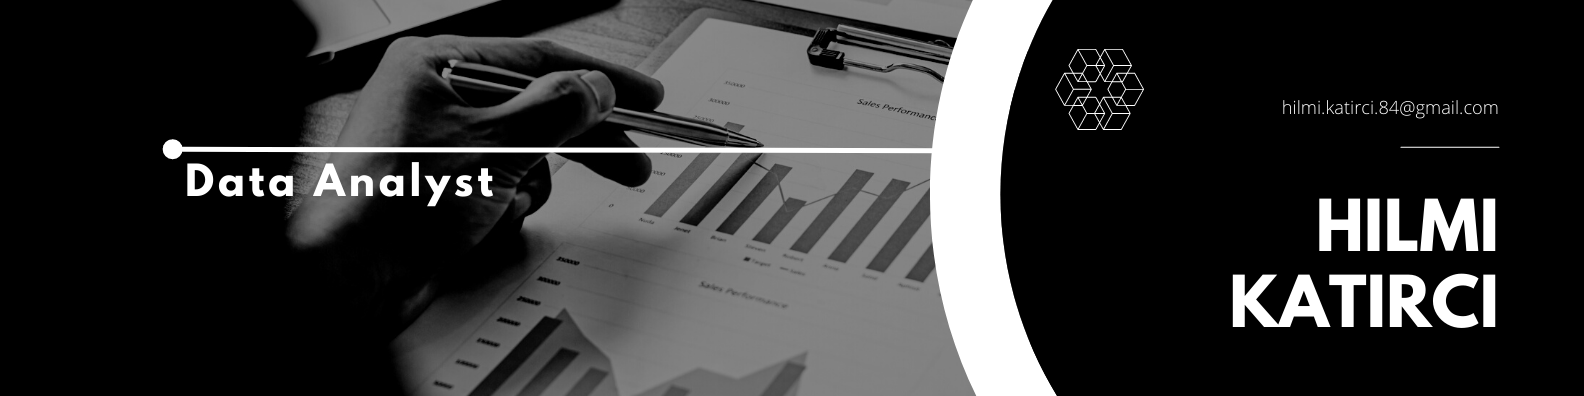